<h1 align="center">Diagnosing Breast Cancer</h1>

This project explores machine learning applied to medical diagnostics, particularly in identifying breast cancer. We use data from the UCI Machine Learning Repository which consist of 569 examples distributed across two distinct classes, those with cancer and those without. As you can see, the data is fairly sparse, especially since each example contains 30 features. The main question this project will attempt to answer is how well different models can perform on a binary classification task given a relatively small amount of data with a large number of features. We might expect the curse of dimensionality to have a negative impact on the results, but perhaps we can work around that with dimensionality reduction. This leads into the second main idea/question: how will the models compare when fitted on a drastically reduced dataset (i.e. in two dimensions) vs. the original dataset.

We will explore various methods of unsupervised learning, including PCA and KPCA as a means of pre-processing our data, and K-Means and GMM as actual learning models. We will then analyze several different supervised learning algorithms on this binary classification task. These are K Nearest Neighbors, Naive Bayes, Logistic Regression, Decision Trees, Neural Networks and Support Vector Machines. Any hyperparameter tuning and/or cross-validation will be reported and discussed. Various performance analytics will also be reported. Visualization will accompany our models whenever possible. All of these algorithms will be implemented with the built-in models from scikit-learn.

We first need to load in a few useful libraries:

In [109]:
%matplotlib inline

import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import mylib as my
import seaborn as sns
import sklearn
from scipy import linalg
from matplotlib.colors import ListedColormap

## The Dataset

The dataset used was created in 1995 by Dr. William H. Wolberg, W. Nick Street, and Olvi L. Mangasarian of the University of Wisconsin. The data examples consist of features computed from a digitized image of a fine needle aspirate (FNA) of a breast mass (tumor). They describe characteristics of the cell nuclei present in the image. <br>
Ten real-valued features are computed for each cell nucleus:

a) radius (mean of distances from center to points on the perimeter) <br>
b) texture (standard deviation of gray-scale values)<br>
c) perimeter<br>
d) area<br>
e) smoothness (local variation in radius lengths)<br>
f) compactness (perimeter^2 / area - 1.0)<br>
g) concavity (severity of concave portions of the contour)<br>
h) concave points (number of concave portions of the contour)<br>
i) symmetry<br>
j) fractal dimension ("coastline approximation" - 1)<br>

Each feature is labeled as either M for malignant, or B for benign. 

We will begin by reading in the data into a dataset.

In [276]:
df = pd.read_csv('./data/breast_cancer.csv')
ds = my.DataSet(df, y = True)
ds

         0      1       2       3        4        5        6        7       8  \
0    17.99  10.38  122.80  1001.0  0.11840  0.27760  0.30010  0.14710  0.2419   
1    20.57  17.77  132.90  1326.0  0.08474  0.07864  0.08690  0.07017  0.1812   
2    19.69  21.25  130.00  1203.0  0.10960  0.15990  0.19740  0.12790  0.2069   
3    11.42  20.38   77.58   386.1  0.14250  0.28390  0.24140  0.10520  0.2597   
4    20.29  14.34  135.10  1297.0  0.10030  0.13280  0.19800  0.10430  0.1809   
..     ...    ...     ...     ...      ...      ...      ...      ...     ...   
564  21.56  22.39  142.00  1479.0  0.11100  0.11590  0.24390  0.13890  0.1726   
565  20.13  28.25  131.20  1261.0  0.09780  0.10340  0.14400  0.09791  0.1752   
566  16.60  28.08  108.30   858.1  0.08455  0.10230  0.09251  0.05302  0.1590   
567  20.60  29.33  140.10  1265.0  0.11780  0.27700  0.35140  0.15200  0.2397   
568   7.76  24.54   47.92   181.0  0.05263  0.04362  0.00000  0.00000  0.1587   

           9  ...     21   

## Feature Engineering

For classification it is often useful or necessary to recode output labels as numbers. Let's do that to our data, we will use 1 for B and -1 for M.

In [277]:
new_col = df['y'].replace({'M': -1, 'B': 1})
df['y'] = new_col

Sometimes it is also useful to normalize your data. Outliers can be an issue in many models, so normalizing each feature can help lessen the effect while still keeping everything more or less proportional. We use the formula `new_value = (old_value - min_value)/(max_value - min_value)` to normalize each feature column.

In [278]:
def normalize(feature_col):
    max_val = np.max(feature_col)
    min_val = np.min(feature_col)
    
    new_col = np.full(len(feature_col), 0, dtype=float)
    for i in range(len(feature_col)):
        new_val = (feature_col[i] - min_val) / (max_val - min_val)
        new_col[i] = new_val
        
    return new_col

In [279]:

# Get list of the feature columns to make a new datafram
columns = df.columns.tolist()
feature_columns = columns.remove('y')

df_norm = pd.DataFrame()

# Normalize each feature column of the dataframe
for col in columns:
    df_norm[col] = normalize(df[col])

# Add the target column back since we didn't normalize it
df_norm['y'] = df['y']

df_norm

,0,1,2,3,4,5,6,7,8,9,...,21,22,23,24,25,26,27,28,29,y
0,0.521037,0.022658,0.545989,0.363733,0.593753,0.792037,0.703140,0.731113,0.686364,0.605518,...,0.141525,0.668310,0.450698,0.601136,0.619292,0.568610,0.912027,0.598462,0.418864,-1
1,0.643144,0.272574,0.615783,0.501591,0.289880,0.181768,0.203608,0.348757,0.379798,0.141323,...,0.303571,0.539818,0.435214,0.347553,0.154563,0.192971,0.639175,0.233590,0.222878,-1
2,0.601496,0.390260,0.595743,0.449417,0.514309,0.431017,0.462512,0.635686,0.509596,0.211247,...,0.360075,0.508442,0.374508,0.483590,0.385375,0.359744,0.835052,0.403706,0.213433,-1
3,0.210090,0.360839,0.233501,0.102906,0.811321,0.811361,0.565604,0.522863,0.776263,1.000000,...,0.385928,0.241347,0.094008,0.915472,0.814012,0.548642,0.884880,1.000000,0.773711,-1
4,0.629893,0.156578,0.630986,0.489290,0.430351,0.347893,0.463918,0.518390,0.378283,0.186816,...,0.123934,0.506948,0.341575,0.437364,0.172415,0.319489,0.558419,0.157500,0.142595,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,0.690000,0.428813,0.678668,0.566490,0.526948,0.296055,0.571462,0.690358,0.336364,0.132056,...,0.383262,0.576174,0.452664,0.461137,0.178527,0.328035,0.761512,0.097575,0.105667,-1
565,0.622320,0.626987,0.604036,0.474019,0.407782,0.257714,0.337395,0.486630,0.349495,0.113100,...,0.699094,0.520892,0.379915,0.300007,0.159997,0.256789,0.559450,0.198502,0.074315,-1
566,0.455251,0.621238,0.445788,0.303118,0.288165,0.254340,0.216753,0.263519,0.267677,0.137321,...,0.589019,0.379949,0.230731,0.282177,0.273705,0.271805,0.487285,0.128721,0.151909,-1
567,0.644564,0.663510,0.665538,0.475716,0.588336,0.790197,0.823336,0.755467,0.675253,0.425442,...,0.730277,0.668310,0.402035,0.619626,0.815758,0.749760,0.910653,0.497142,0.452315,-1


Now that we have our data ready to use, let's put it into a DataSet and split it into training and test sets. Since our data is scarce, we will use k-fold cross validation instead of a validation set to tune any hyperparamers.

In [280]:
ds = my.DataSet(df_norm, y=True)
train, test = ds.train_test_split(test_portion=.25, shuffle=True)

# Part 1: Unsupervised Learning

For the first part of this project, we will look at unsupervised learning. One reason for doing so first is because dimensionality reduction may help us speed up our algorithms and reduce the complexity of the input space, which we alluded to in the introduction. Unsupervised learning is used when examples don't have labels. Since our data does, we will pretend like we don't have those labels first before we look at any unsupervised algorithms.

## Dimensionality Reduction - PCA vs. KPCA

Dimensionality reduction is typically a form of pre-processing and can be very useful for visualizing data or reducing the dimensionality of examples to make algorithms faster, typically at the cost of some information loss. Our data has a lot of dimension to it, but maybe we don't need all 30 of them to get good results. First, let's try reducing our data to two and three dimensions to see if there is any sort of clusters we can make out between the two classes. That will be a good indication of the consistency of the data classes. We will use the 2D-projected examples as our primary comparison to the original dataset throughout part 2 of the notebook.

### Principal Component Analysis

We will first do this using Principal Component Analysis, which centers the data and then seeks a projection in the direction with the highest variance using eigenvectors. The desired dimension corresponds to the number of eigenvectors used in the transformation of the data.

We will start by reducing to just one dimension and plotting the resulting data and classes.

In [78]:
from sklearn.decomposition import PCA

pca = PCA(n_components=1)
X_projected = pca.fit_transform(ds.inputs)
y = ds.target.ravel()

And now plot the projected data onto a line:

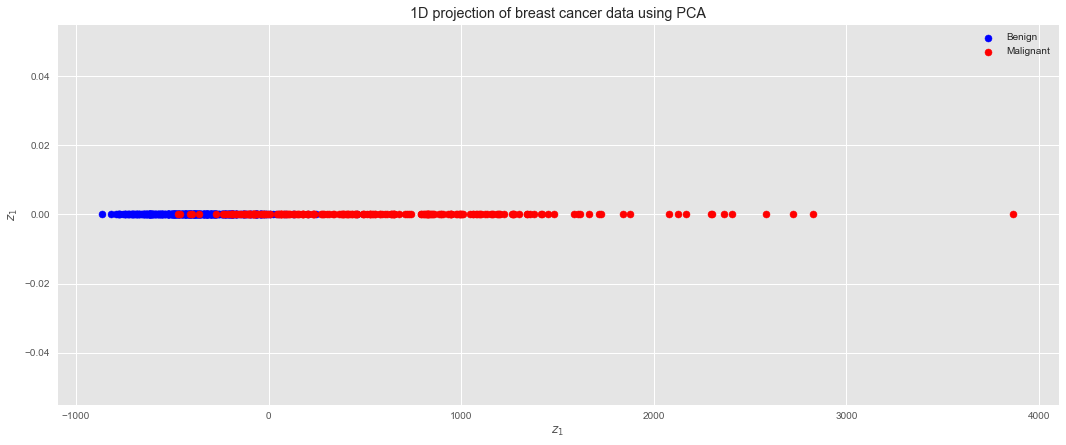

In [79]:
fig = plt.figure(figsize=(16, 7))
plt.style.use('ggplot')

# Benign
plt.scatter(X_projected[y==1], np.zeros(len(X_projected[y==1])), color='blue', label='Benign')
# Malignant
plt.scatter(X_projected[y==-1], np.zeros(len(X_projected[y==-1])), color='red', label='Malignant')
plt.legend(loc='best')
plt.xlabel('$z_1$')
plt.ylabel('$z_1$')
plt.title("1D projection of breast cancer data using PCA")
plt.show()

We can see some distinction in the two classes, but there does appear to be some overlap where the Benign and Malignant meet. The more useful dimension for us to reduce to is 2 dimensions, so we can better visualize the separation of the two classes, if any. Let's use PCA to project the data onto two dimensions:

In [80]:
pca = PCA(n_components=2)
X_projected = pca.fit_transform(ds.inputs)
y = ds.target.ravel()

Now plot the data to visualize any groupings. We use the y values as color to indicate which points belong to each class.

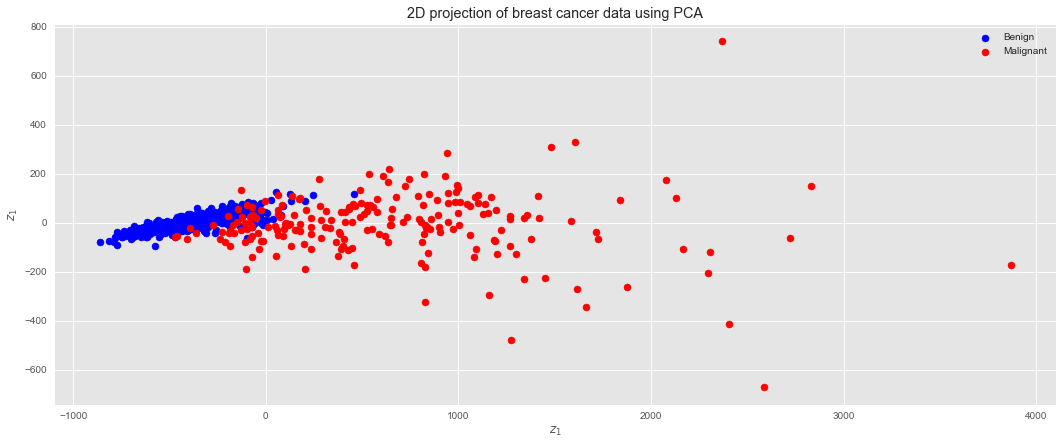

In [81]:
fig = plt.figure(figsize=(16, 7))
plt.style.use('ggplot')
# Benign
plt.scatter(X_projected[y==1, 0], X_projected[y==1, 1], color='blue', label='Benign')
# Malignant
plt.scatter(X_projected[y==-1, 0], X_projected[y==-1, 1], color='red', label='Malignant')
plt.legend(loc='best')
plt.xlabel('$z_1$')
plt.ylabel('$z_1$')
plt.title("2D projection of breast cancer data using PCA")
plt.show()

This is a much better representation of the data than 1D. The results here are interesting. The benign tumors all appear to be grouped very tightly, even in just two dimensions. The malignant ones have much more variance, which makes sense since they are cancerous. It's almost like this mapping reflects the characteristics of the tumors themselves. Very cool!

Now project onto 3 dimensions for one more visualization.

In [82]:
pca = PCA(n_components=3)
X_projected_3 = pca.fit_transform(ds.inputs)

And again plot the data in 3d:

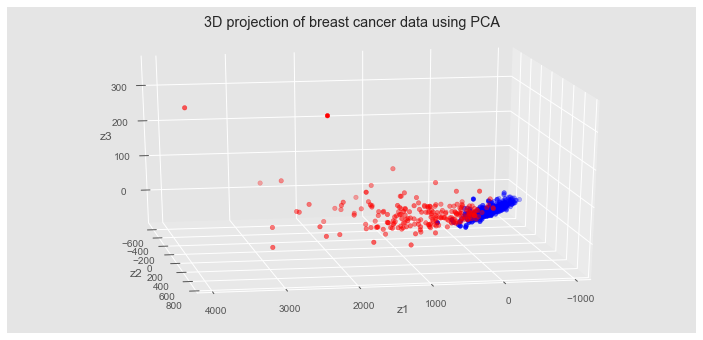

In [83]:
fig = plt.figure(figsize=(11, 6))
plt.style.use('ggplot')
ax = plt.axes(projection='3d')
ax.set_xlabel('z1')
ax.set_ylabel('z2')
ax.set_zlabel('z3')

# Benign
ax.scatter3D(X_projected[y==1,0], X_projected_3[y==1,1], X_projected_3[y==1,2], c='blue')
# Malignant
ax.scatter3D(X_projected[y==-1,0], X_projected_3[y==-1,1], X_projected_3[y==-1,2], c='red')
ax.set_title("3D projection of breast cancer data using PCA")
ax.view_init(20, 80)

One of the most useful ways to identify which components contribute to the most information (variance) in a dataset is to look at the explained variance ratio. The PCA class has a built in property to get these values for each component, so let's plot them and see:

Text(0.5, 0, '# of component')

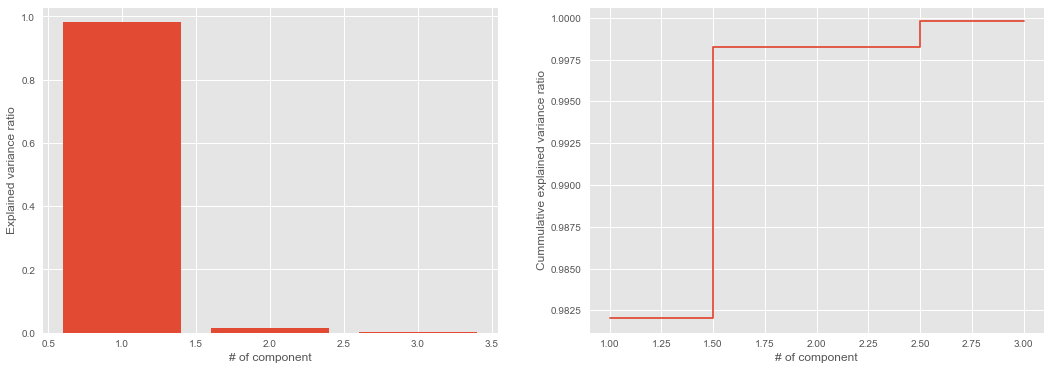

In [84]:
expl_var = pca.explained_variance_ratio_
cum_expl_var = np.cumsum(expl_var)

fig = plt.figure(figsize=(16, 6))
ax1, ax2 = fig.subplots(1, 2)
ax1.bar(range(1, len(expl_var) + 1), expl_var, align='center')

ax1.set_ylabel('Explained variance ratio')
ax1.set_xlabel('# of component')

ax2.step(range(1, len(cum_expl_var) + 1), cum_expl_var, where='mid')

ax2.set_ylabel('Cummulative explained variance ratio')
ax2.set_xlabel('# of component')

It appears, rather suprisingly, that the first two components (features) are the most significant to the data set and they make up over 99% of the cumulative explained variance ratio. In other words, not all of the features contribute to the information and variance of each example and its corresponding class. In fact this means that we should be able to test our supervised classifiers on just two or three features and still get good results. That being said, we will hold on to that X_projected array so we can do just that.

### Kernel Principal Component Analysis

KPCA tends to be more powerful than PCA (in general). The idea is that you can take linearly inseparable data, transform it to a higher dimension using the 'Kernel Trick', and then applying PCA on that higher dimensional data that is (hopefully) now linearly separable. The most popular kernel and the one that we will use is the Radial Basis Function, which is defined by:
$$k(\mathbf{x_i, x_j}) = exp(\frac{-\|\mathbf{x_i} - \mathbf{x}_j\|^2}{r})$$ 
where $\mathbf{x}_i$ is a training example, $\mathbf{x}_j$ is another example, $-\|\mathbf{x_i} - \mathbf{x_j}\|$ is the Euclidean distance, and $r$ is $2 \sigma^2$, which is a hyperparameter that can be tuned to give the desired results.


Let's try projecting our data onto 2 dimensions again. We use a gamma hyperparameter value of .000009, which was simply chosen after testing several different values and choosing the one that looked the best in the projections. Note: The tests are left off to avoid repetition and keep things simple, just know that this value was not chosen totally arbitrarily.

In [85]:
from sklearn.decomposition import KernelPCA

kpca = KernelPCA(n_components=2, kernel='rbf')
kpca.set_params(gamma=.000009) # Set the gamma hyperparamter for the kernel
X_transformed = kpca.fit_transform(ds.inputs)
y = ds.target.ravel()

And now let's plot this 2D data.

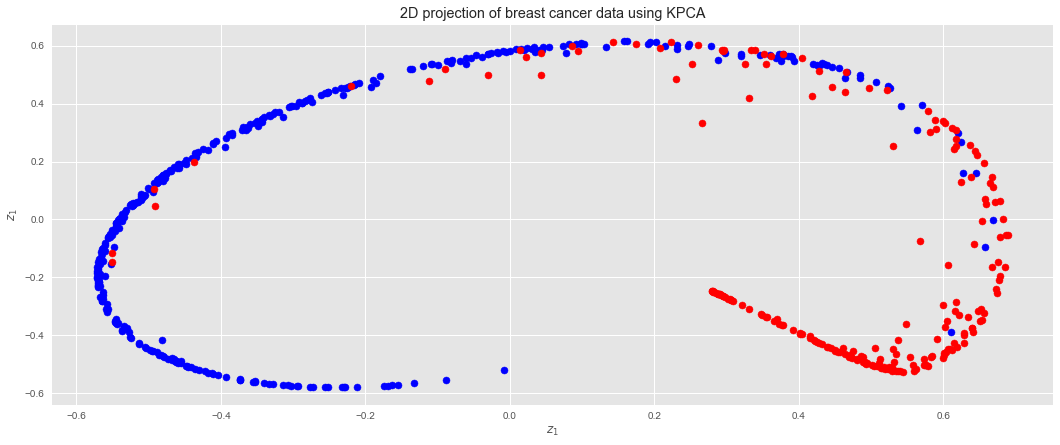

In [86]:
fig = plt.figure(figsize=(16, 7))
plt.style.use('ggplot')
# Benign
plt.scatter(X_transformed[y==1, 0], X_transformed[y==1, 1], color='blue')
# Malignant
plt.scatter(X_transformed[y==-1, 0], X_transformed[y==-1, 1], color='red')
plt.xlabel('$z_1$')
plt.ylabel('$z_1$')
plt.title("2D projection of breast cancer data using KPCA")
plt.show()

Woah, this projection is much different than that of PCA. It doesn't even look remotely similar. Still, we can see some separation of the two classes. The benign examples are mostly grouped together on the left side of this "curve", while the malignant red ones are together on the right. There is still some overlap which may simply be unavoidable due to the similarity of those examples. It is very possible for two tumors to look identical yet one be cancerous and the other not. Unfortunately, a clear separation was not able to be obtained with KPCA. Now let's project onto 3D as well (using the same gamma value).

In [87]:
kpca = KernelPCA(n_components=3, kernel='rbf')
kpca.set_params(gamma=.000009)
X_transformed = kpca.fit_transform(ds.inputs)

And plot it:

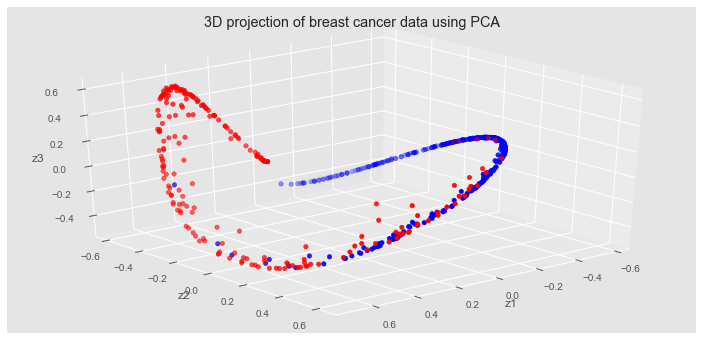

In [88]:
fig = plt.figure(figsize=(11, 6))
plt.style.use('ggplot')

ax = plt.axes(projection='3d')
ax.set_xlabel('z1')
ax.set_ylabel('z2')
ax.set_zlabel('z3')

# Benign
ax.scatter3D(X_transformed[y==1,0], X_transformed[y==1,1], X_transformed[y==1,2], c='blue')
# Malignant
ax.scatter3D(X_transformed[y==-1,0], X_transformed[y==-1,1], X_transformed[y==-1,2], c='red')
ax.set_title("3D projection of breast cancer data using PCA")
ax.view_init(30, 50)

Now we can see some more form to the shape from the 2D projection, taking note of how different KPCA works compared to PCA. Very interesting. When we test our classifiers in Part 2 on 2-dimensional data, we will use the PCA projected examples, not the ones from KPCA.

## Clustering with GMM and K-Means

Aside from dimensionality reduction, the other primary use of unsupervised learning is for clustering. The idea is that although the examples don't have labels, we can look for patterns in the data and group related features into a certain number of clusters. The downside is that we don't always know how many clusters to use. Luckily there are certain metrics we can plot that help us decide on a good number. 

### GMM: 2D Projected data

Gaussian Mixture Models are a form of clustering that involves imagining that the dataset was distributed from a mixture of multivariate normal (Gaussian) distributions, and then clustering them based on which one they are nearest to or most probable under. The number of Gaussians, K, is a hyperparameter. Put simply, GMMs rely on what are called latent variables, which allows us to represent the distribution of the data as:
$$P(x) = {\sum_{k}P(x, z)} = {\sum_{k=1}^K \pi_k N(\mathbf{x} | \mathbf{\mu}_k, \boldsymbol{\Sigma}_k)}$$
The Expectation Maximization algorithm is then used optimize the various parameters of the GMM.

Here we will analyze and evaluate two of the most popular clustering algorithms, Gaussian Mixture Models and K-Means

### Finding K

The biggest problem faced when using GMM is K, the number of clusters to use. This is a hyperparameter and so it needs to be tested with different values. Because we are dealing with unsupervised learning, we can't necessarily use cross-validation becuase we can't compute errors with labels. Instead, we can use a couple of useful metrics for the information criteria. The first is the Akaike Information Criteria (AIC) and it is defined as 

$$\text{AIC} = -2 \times \text{log_likelihood} \times N + \text{n_parameters} \times log(N)$$

where $N$ is the number of examples, $\text{log_likelihood}$ is the mean of $log(likelihood)$ and $\text{n_parameters}$ is the number of adjusted parameters (degrees of freedom):

$$\text{n_parameters} = K \times M \times (M + 1) / 2$$

where $M$ is the number of features and $K$ is the number of clusters. The Bayesian Information Criteria is similar:

$$\text{BIC} = -2 \times \text{log_likelihood} \times N + 2 \times \text{n_parameters}$$

The value of K that gives the lowest for each is typically the best value to use. We can plot both scores for various values of K and find the best one. The GaussianMixture class has built in functions for computing them.

Text(0, 0.5, 'Information criterion')

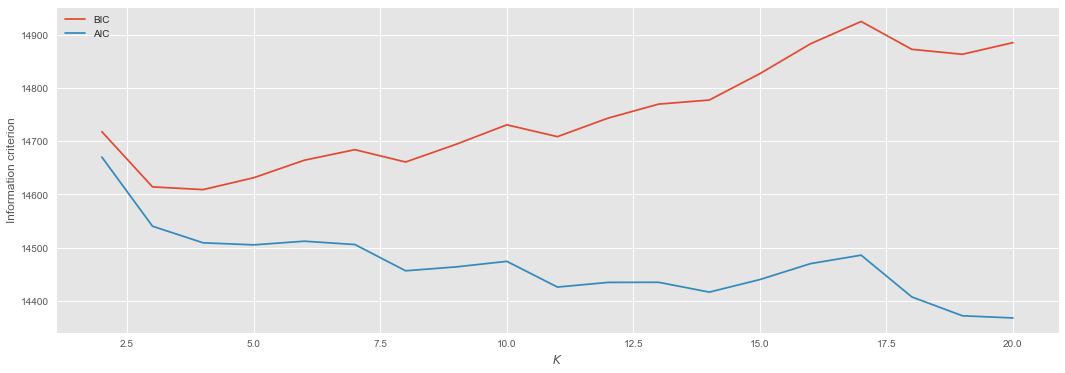

In [89]:
from sklearn.mixture import GaussianMixture

K = np.arange(2, 21)

models = [ GaussianMixture(n_components=k).fit(X_projected) for k in K ]
fig=plt.figure(figsize=(16,6))
plt.style.use('ggplot')
plt.plot(K, [m.bic(X_projected) for m in models], label='BIC')
plt.plot(K, [m.aic(X_projected) for m in models], label='AIC')
plt.legend(loc='best')
plt.xlabel('$K$')
plt.ylabel('Information criterion')

We can see that the AIC get's lower and lower but the BIC starts to increase, so we want a value where they are both decreasing to a minimum. The ideal K appear to be 3 here, with 2 also being a good value. 

Another useful measure to use is the silhouette score which is a measure of how appropriately the data have been clustered. Its value always ranges between 1 and -1, with higher scores corresponding to the best model. Let's do the same thing as above but this time we plot the silhouette score and look for the maximum.

Text(0, 0.5, 'Silhouette score')

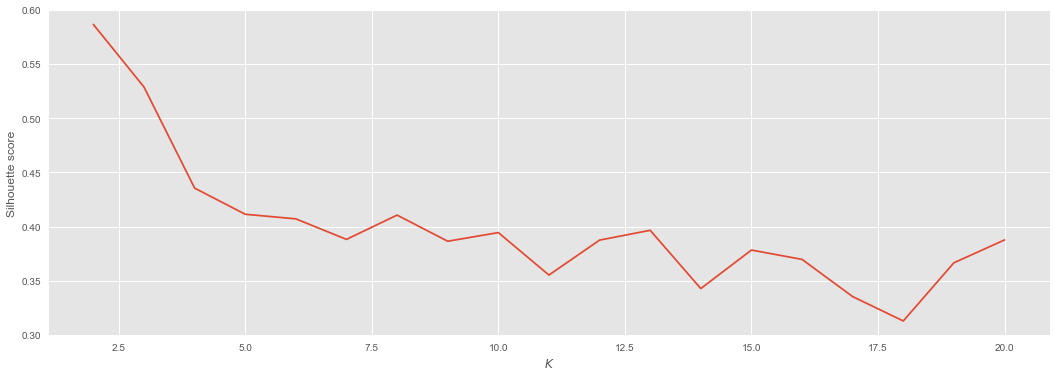

In [90]:
from sklearn.metrics import silhouette_score

K = np.arange(2, 21)
models = [ GaussianMixture(n_components=k).fit(X_projected) for k in K ]
fig=plt.figure(figsize=(16,6))
plt.style.use('ggplot')
plt.plot(K, [silhouette_score(X_projected, m.predict(X_projected)) for m in models])
plt.xlabel('$K$')
plt.ylabel('Silhouette score')

We know that the correct value of K should be 2, but the algorithm doesn't know that. However it did a good job of estimating values close to it. Given the above information, let's cluster the data using both our candidate values of K which are 2 and 3.

Text(0.5, 1.0, 'Reduced dataset with three learned centers using GMM')

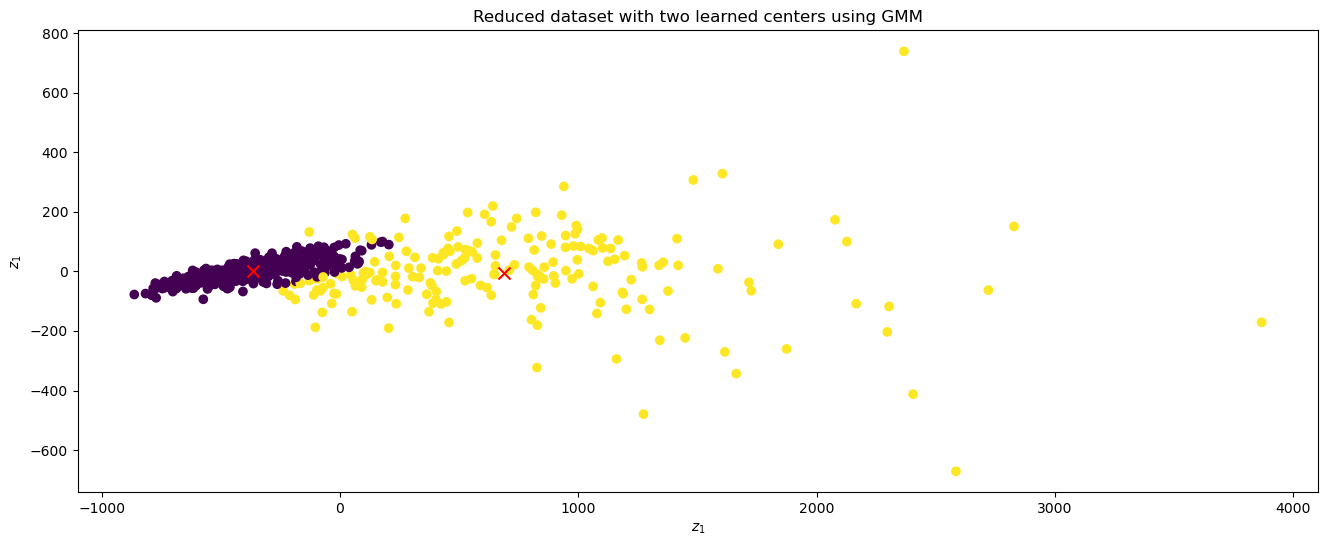

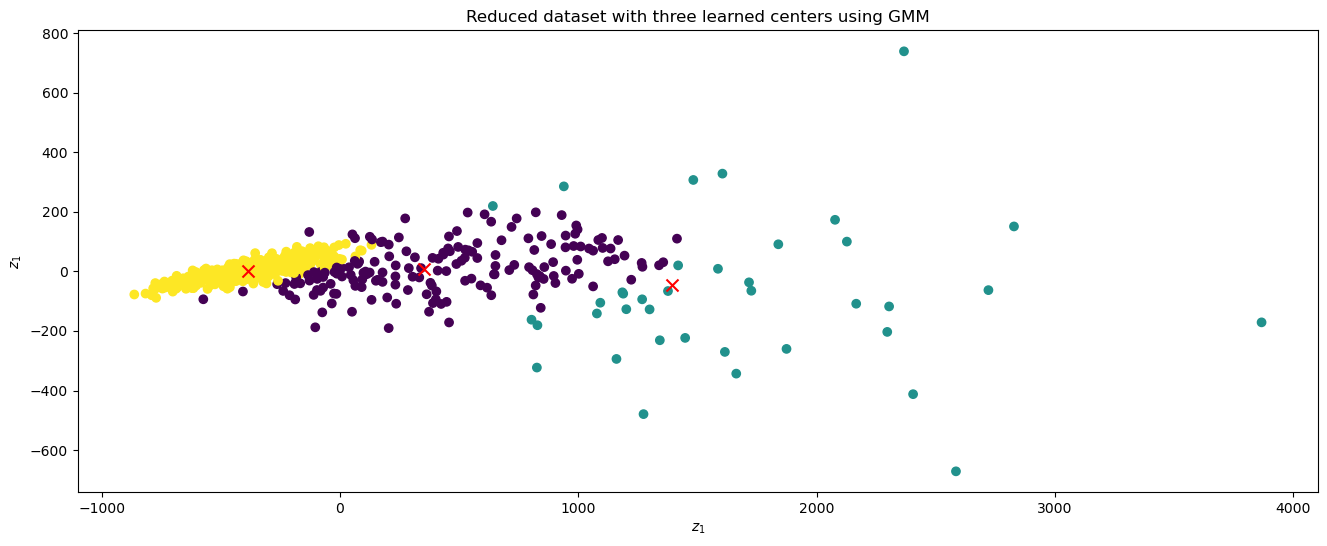

In [100]:
gmm = GaussianMixture(n_components=2).fit(X_projected)
fig=plt.figure(figsize=(16,6))
plt.style.use('default')
ax = fig.add_subplot(1,1,1)
ax.scatter(X_projected[:,0], X_projected[:,1], c=gmm.predict(X_projected[:, :]))
ax.scatter(gmm.means_[:, 0], gmm.means_[:, 1], marker='x', c="red", s=75)
plt.xlabel('$z_1$')
plt.ylabel('$z_1$')
plt.title("Reduced dataset with two learned centers using GMM")

gmm = GaussianMixture(n_components=3).fit(X_projected)
fig=plt.figure(figsize=(16,6))

ax = fig.add_subplot(1,1,1)
ax.scatter(X_projected[:,0], X_projected[:,1], c=gmm.predict(X_projected[:, :]))
ax.scatter(gmm.means_[:, 0], gmm.means_[:, 1], marker='x', c="red", s=75)
plt.xlabel('$z_1$')
plt.ylabel('$z_1$')
plt.title("Reduced dataset with three learned centers using GMM")

### GMM: Original data

For comparisons sake, let's do the same GMM analysis on our original dataset with 30 dimensions to see if the results and best values of K differ. First we plot the AIC and BIC for K from 2-20:

Text(0, 0.5, 'Information criterion')

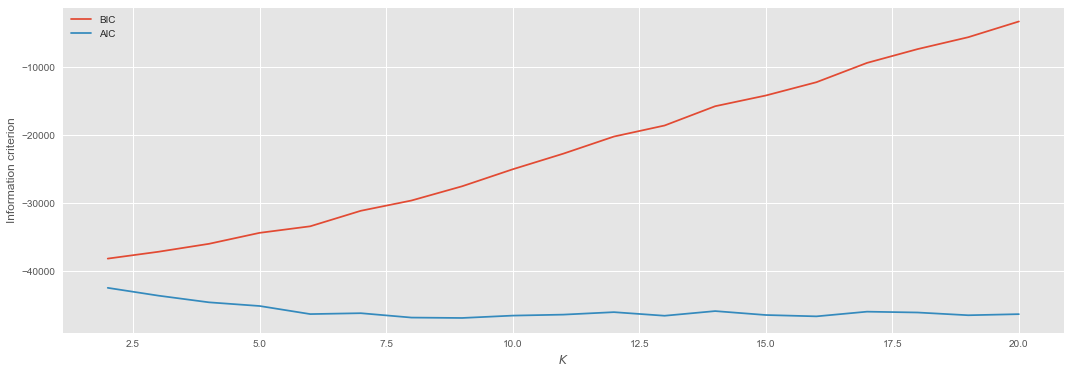

In [93]:
K = np.arange(2, 21)

models = [ GaussianMixture(n_components=k).fit(ds.inputs) for k in K ]
fig=plt.figure(figsize=(16,6))
plt.style.use('ggplot')
plt.plot(K, [m.bic(ds.inputs) for m in models], label='BIC')
plt.plot(K, [m.aic(ds.inputs) for m in models], label='AIC')
plt.legend(loc='best')
plt.xlabel('$K$')
plt.ylabel('Information criterion')

The values of AIC and BIC are much different here, but the shape of the curves is similar and we can see that 2 is the best value for K when looking at this plot. Now we will also plot the silhouette scores for K to look for any differences.

Text(0, 0.5, 'Silhouette score')

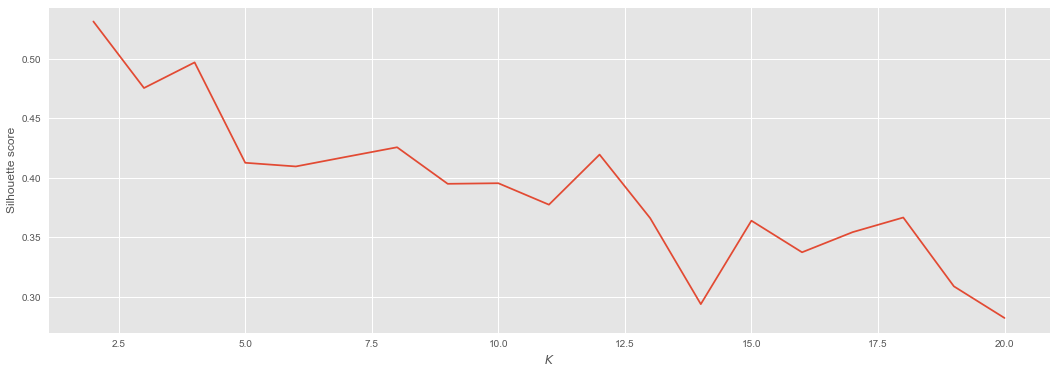

In [94]:
from sklearn.metrics import silhouette_score

K = np.arange(2, 21)
models = [ GaussianMixture(n_components=k).fit(ds.inputs) for k in K ]
fig=plt.figure(figsize=(16,6))
plt.style.use('ggplot')
plt.plot(K, [silhouette_score(ds.inputs, m.predict(ds.inputs)) for m in models])
plt.xlabel('$K$')
plt.ylabel('Silhouette score')

The maximum silhouette score here happens when k=2. As we know that is the best value since we only have two classes. It looks like GMM and the scores on our original data did do a "better" job of finding the best value of K, but the reduced data analysis was surpisingly close and did very well.

### K-Means: 2D projected data

K-Means is another clustering method that is popular among machine-learning practitioners and more simple than the GMM. It is a center-based partitional clustering method that uses a greedy algorithm. Essentially it works by assigning K random centers, denoted by ${\mu_k}$, to the dataset and then assigning examples to their closest center. The algorithm repeats and moves the centers to the new mean of their groupings and ends when the means stop moving.

### Finding K

Just like with GMM, there are a few different ways to find what the best value of K is. We can use the Within-Class Sum of Squares error (WCSS), which is the sum of squares of the difference between each example and every other example in that class or cluster. The AIC can also be used, but it is a little different for K-Means:
$$ \text{AIC}\ =\  \text{WCSS} + 2 \times M \times K$$

where $M$ is the number of features and $K$ is the number of clusters. We will define our own functions to compute these two values for a KMeans classifier.

In [95]:
def wcss(X, kmeans):
    return np.sum((X - kmeans.cluster_centers_[kmeans.predict(X)])**2)

def aic(X, kmeans):
    w = wcss(X, kmeans)
    K, M = kmeans.cluster_centers_.shape

    return(w + 2 * M * K)

Now we need to fit several different models with different values of K and compute and plot these values. As before, we want lower values of each.

Text(0.5, 0, '$K$')

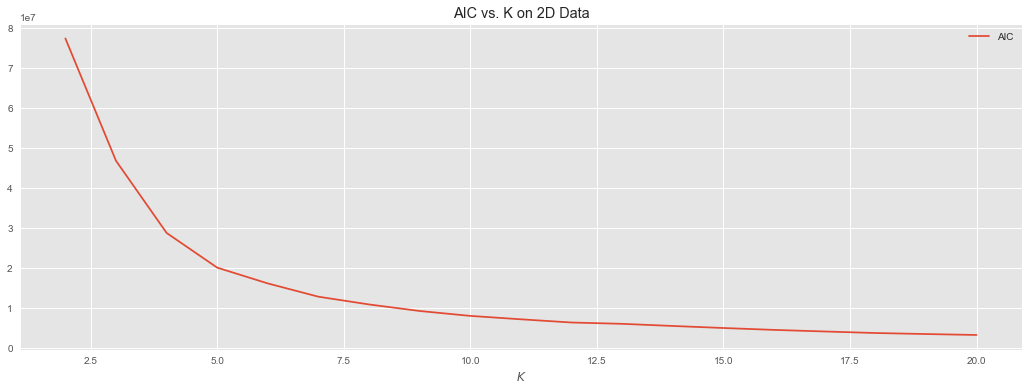

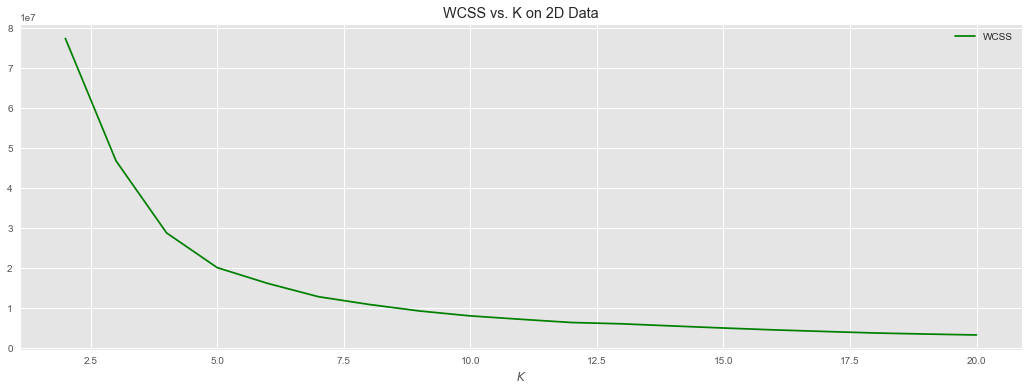

In [96]:
from sklearn.cluster import KMeans

K = np.arange(2, 21)
models = [ KMeans(n_clusters=k).fit(X_projected) for k in K ]

fig=plt.figure(figsize=(16,6))
plt.style.use('ggplot')
plt.plot(K, [aic(X_projected, m) for m in models], label='AIC')
plt.legend(loc='best')
plt.title("AIC vs. K on 2D Data")
plt.xlabel('$K$')

fig=plt.figure(figsize=(16,6))
plt.style.use('ggplot')
plt.plot(K, [wcss(X_projected, m) for m in models], label='WCSS', c='g')
plt.legend(loc='best')
plt.title("WCSS vs. K on 2D Data")
plt.xlabel('$K$')

The values here keep getting lower and lower. This is because the more centers we have, the smaller the distance gets from each example to it's center and so the sum of squares error decreases. This is a sign of overfitting so we want to combine these results with perhaps a more useful metric, the silhouette score. It is the same for KMeans as it is for GMM. Again, we plot several different values.

Text(0, 0.5, 'Silhouette score')

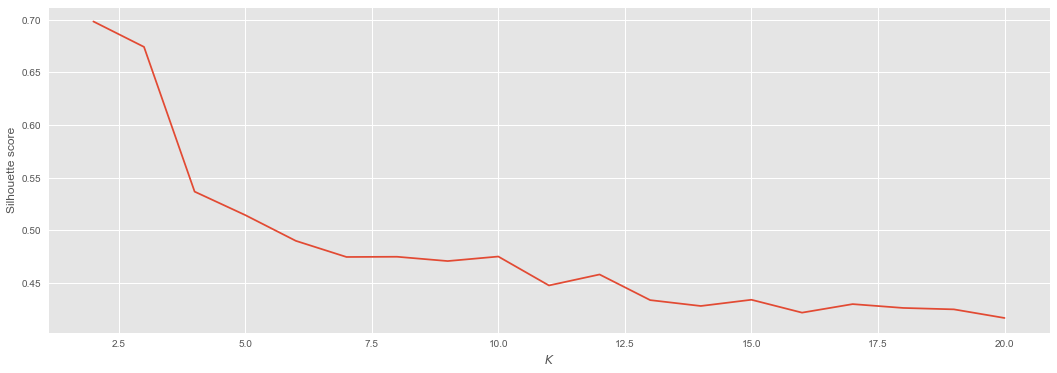

In [97]:
fig=plt.figure(figsize=(16,6))
plt.style.use('ggplot')
plt.plot(K, [silhouette_score(X_projected, m.predict(X_projected)) for m in models])
plt.xlabel('$K$')
plt.ylabel('Silhouette score')

Looks like thei highest scores come when K=2 and K=3. This is a better prediction than what the AIC/WCSS gave us. Let's fit a couple of models with different values of K and plot the data along with the learned centers.

Text(0.5, 1.0, 'Reduced dataset with 4 learned centers using K-Means')

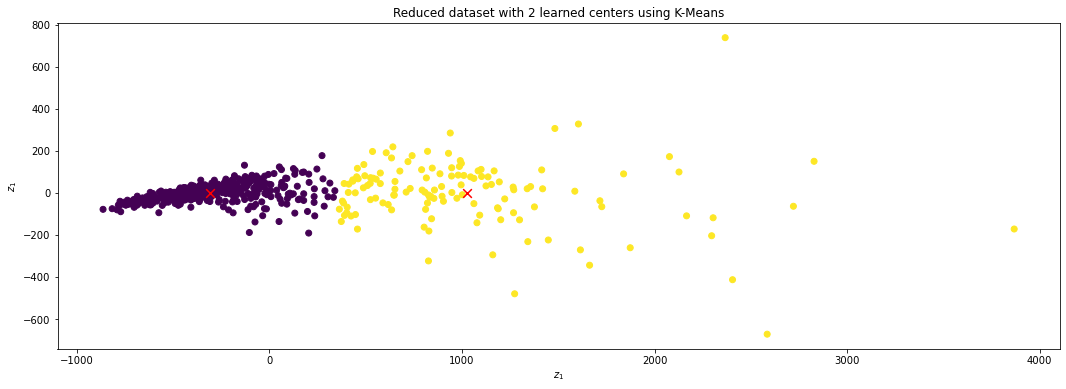

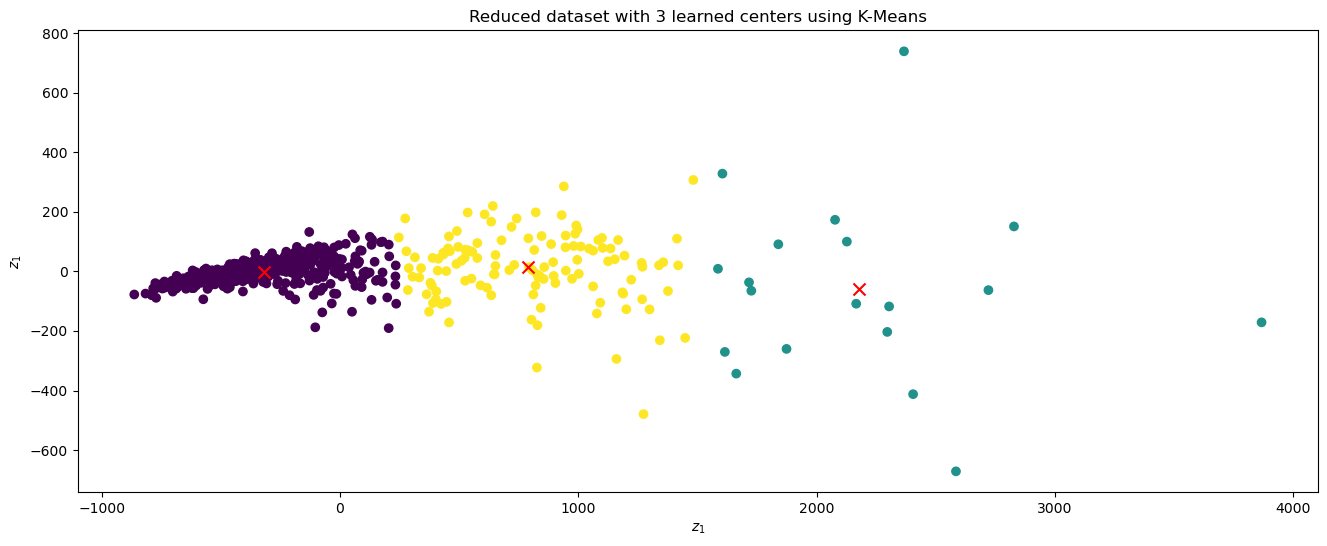

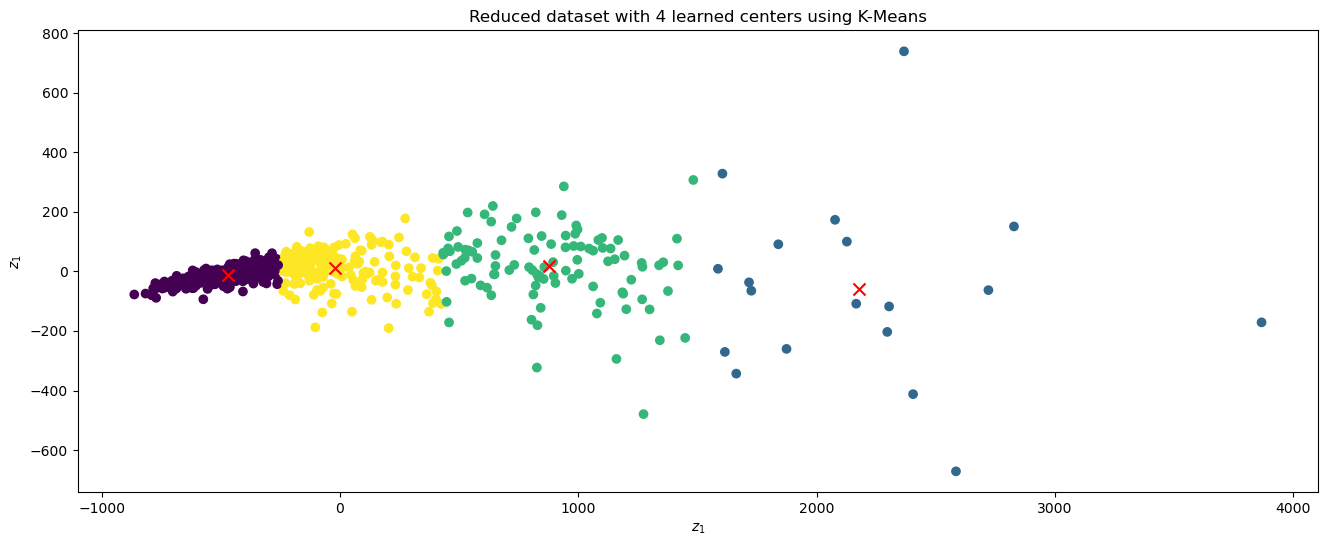

In [99]:
km = KMeans(n_clusters=2).fit(X_projected)
fig=plt.figure(figsize=(16,6))
plt.style.use('default')
plt.scatter(X_projected[:,0], X_projected[:,1], c=km.predict(X_projected))

plt.scatter(km.cluster_centers_[:,0], km.cluster_centers_[:,1], c="r", marker="x", s=75)
plt.xlabel('$z_1$')
plt.ylabel('$z_1$')
plt.title("Reduced dataset with 2 learned centers using K-Means")

km = KMeans(n_clusters=3).fit(X_projected)
fig=plt.figure(figsize=(16,6))
plt.scatter(X_projected[:,0], X_projected[:,1], c=km.predict(X_projected))

plt.scatter(km.cluster_centers_[:,0], km.cluster_centers_[:,1], c="r", marker="x", s=75)
plt.xlabel('$z_1$')
plt.ylabel('$z_1$')
plt.title("Reduced dataset with 3 learned centers using K-Means")

km = KMeans(n_clusters=4).fit(X_projected)
fig=plt.figure(figsize=(16,6))
plt.scatter(X_projected[:,0], X_projected[:,1], c=km.predict(X_projected))

plt.scatter(km.cluster_centers_[:,0], km.cluster_centers_[:,1], c="r", marker="x", s=75)
plt.xlabel('$z_1$')
plt.ylabel('$z_1$')
plt.title("Reduced dataset with 4 learned centers using K-Means")

### K-Means: Original data

Again we will do the same KMeans analysis on our original data. First, the AIC and WCSS:

Text(0.5, 0, '$K$')

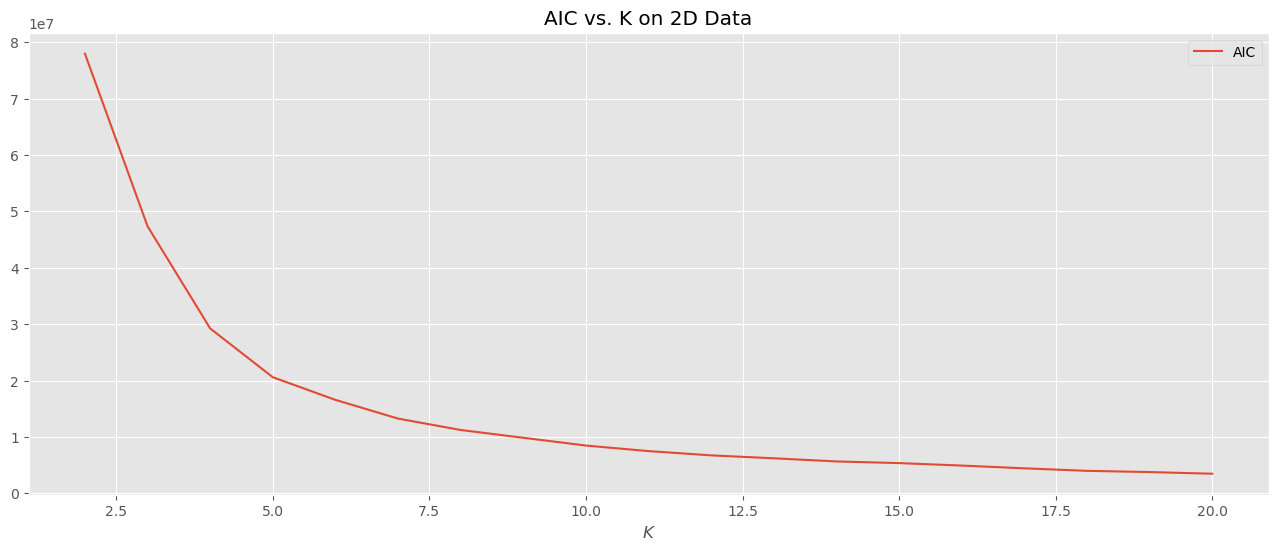

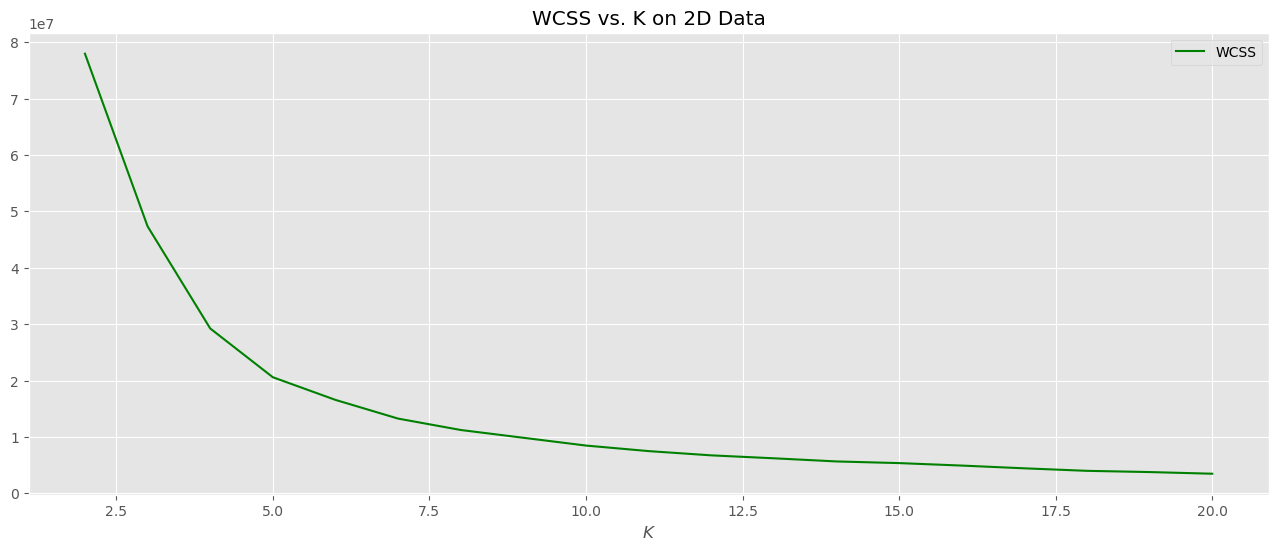

In [101]:
K = np.arange(2, 21)
models = [ KMeans(n_clusters=k).fit(ds.inputs) for k in K ]

fig=plt.figure(figsize=(16,6))
plt.style.use('ggplot')
plt.plot(K, [aic(ds.inputs, m) for m in models], label='AIC')
plt.legend(loc='best')
plt.title("AIC vs. K on 2D Data")
plt.xlabel('$K$')

fig=plt.figure(figsize=(16,6))
plt.style.use('ggplot')
plt.plot(K, [wcss(ds.inputs, m) for m in models], label='WCSS', c='g')
plt.legend(loc='best')
plt.title("WCSS vs. K on 2D Data")
plt.xlabel('$K$')

The shapes are almost identical. Let's see if the silhouette scores change at all.

Text(0, 0.5, 'Silhouette score')

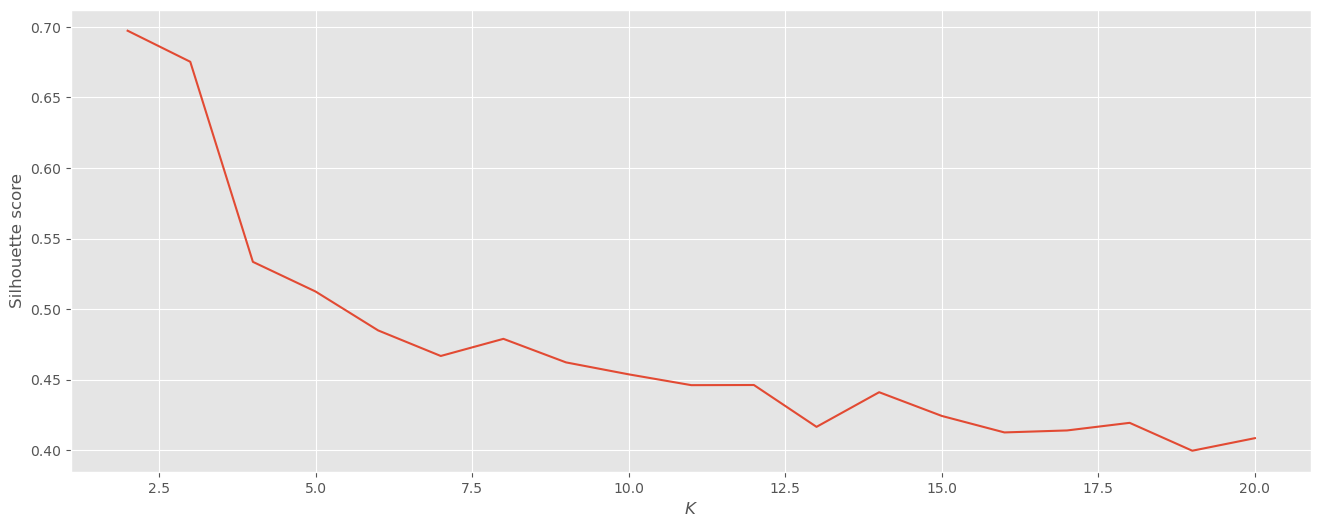

In [102]:
fig=plt.figure(figsize=(16,6))
plt.style.use('ggplot')
plt.plot(K, [silhouette_score(ds.inputs, m.predict(ds.inputs)) for m in models])
plt.xlabel('$K$')
plt.ylabel('Silhouette score')

This curve is almost identical to the projected dataset's as well. Here, we would want to choose a value of 2 for our centers. We know that this is the correct value, so the original dataset-fitted models did a good job again.

# Part 2: Supervised Learning

Now for the main part of the project. We will look at, analyze, and compare several different supervised learning algorithms. For each model, we will compare its performance on our original, 30-dimensional dataset and the reduced dataset from part 1. Supervised learning involves fitting on examples that have labels associated with them. When an algorithm makes a prediction, it predicts the label or class for an unseen example based on what it has "learned". In our case, a label is a classification as being malignant or benign. Many supervised learning algorithms aim to reduce some sort of error function between the actual labels and the predicted labels. Some basic overview of each algorithm will be discussed as we go.

One thing we need to do before we proceed is to create a dataset out of our X_projected reduced dataset. We will also normalize this dataset due to the large difference in outliers.

In [174]:
df_2 = pd.DataFrame(X_projected)
df_reduced = pd.concat([df_2, pd.Series(ds.target.ravel())], axis=1)
df_reduced.columns = [0, 1, 'y']

# Get list of the feature columns to make a new datafram
columns = df_reduced.columns.tolist()
feature_columns = columns.remove('y')

df_normal = pd.DataFrame()

# Normalize each feature column of the dataframe
for col in columns:
    df_normal[col] = normalize(df_reduced[col])

# Add the target column back since we didn't normalize it
df_normal['y'] = df_reduced['y']

df_normal

ds_reduced = my.DataSet(df_normal, y=True)
train_reduced, test_reduced = ds_reduced.train_test_split(test_portion=.25, shuffle=True)
ds_reduced


            0         1  y
0    0.427727  0.267593 -1
1    0.450765  0.486951 -1
2    0.392983  0.503623 -1
3    0.096391  0.428126 -1
4    0.379146  0.610049 -1
..        ...       ... ..
564  0.481420  0.553983 -1
565  0.403389  0.530481 -1
566  0.248957  0.509573 -1
567  0.420268  0.500060 -1
568  0.019368  0.413059  1

[569 rows x 3 columns]

There will be a few useful functions we can define that will make things easier and save code repetition. The first function just computes the error of a classifier, which is 1 - the accuracy. It takes the predicted labels and target labels as parameters. `confusion_matrix_accuracy` computes the accuracy of a confusion matrix. `plot_ROC` makes a plot of the Receiver Operator Characterstic curve, which is a plot of the true positive rate against the false positive rate of a classifier. The last function, `compute_average_accuracies`, will be used to compute average training and testing accuracies. These will be useful in comparing the performance across algorithms and within algorithms on our original and reduced datasets.

In [121]:
def errorMeasure(targets, predicted):
    cm = my.confusion_matrix(targets, predicted)
    return (1 - confusion_matrix_accuracy(cm))

def confusion_matrix_accuracy(cm):
    return np.trace(cm) / np.sum(cm)

def calculate_metrics(cm):
    sensitivity = cm[0,0] / (cm[0,0] + cm[0,1])
    specificity = cm[1,1] / (cm[1,1] + cm[1,0])
    precision = cm[0,0] / (cm[0,0] + cm[1,0])
    F1 = (2 * precision * sensitivity) / (precision + sensitivity)
    
    return sensitivity, specificity, precision, F1

def plot_ROC(cm1, cm2):
    x = np.linspace(0, 1)

    fig = plt.figure(figsize=(16,9))
    plt.style.use('ggplot')
    plt.plot(x, x, '--b', label="Random Guess")
    sens, spec, prec, F1 = calculate_metrics(cm1)
    sens2, spec2, prec2, F1 = calculate_metrics(cm2)
    fpr = 1 - spec
    fpr2 = 1 - spec2

    plt.plot(fpr, sens, 'xr', label='Original')
    plt.plot(fpr2, sens2, 'xg', label='Reduced')
    plt.title("ROC Space", fontsize=14)
    plt.xlabel("FPR (1 - specificity)", fontsize=14)
    plt.ylabel("TPR (sensitivity)", fontsize=14)
    plt.legend(loc="lower right")
    
def compute_average_accuracies(learner1, learner2):
    iterations = np.arange(1, 11)
    predictions_train = []
    predictions_train2 = []
    predictions_test = []
    predictions_test2 = []
    
    ds_reduced_2 = my.DataSet(df_normal, y=True)
    train_reduced_2, test_reduced_2 = ds_reduced_2.train_test_split(test_portion=.25, shuffle=True)
  
    ds_2 = my.DataSet(df, y=True)
    train_2, test_2 = ds_2.train_test_split(test_portion=.25, shuffle=True)

    for i in range(1, 11):
        learner2.fit(train_reduced_2.inputs, train_reduced_2.target.ravel())
        learner1.fit(train_2.inputs, train_2.target.ravel())
        
        cm = my.confusion_matrix(train_2.target, learner1.predict(train_2.inputs))
        predictions_train.append(np.trace(cm) / np.sum(cm))

        cm = my.confusion_matrix(train_reduced_2.target, learner2.predict(train_reduced_2.inputs))
        predictions_train2.append(np.trace(cm) / np.sum(cm))
        
        cm = my.confusion_matrix(test_2.target, learner1.predict(test_2.inputs))
        predictions_test.append(np.trace(cm) / np.sum(cm))

        cm = my.confusion_matrix(test_reduced_2.target, learner2.predict(test_reduced_2.inputs))
        predictions_test2.append(np.trace(cm) / np.sum(cm))
        
    return sum(predictions_train)/10, sum(predictions_train2)/10, sum(predictions_test)/10, sum(predictions_test2)/10

We define one more function that will plot a dataset and display a learner's decision boundaries on that set. This will be used on our 2D reduced dataset.

In [110]:
def plot_decision_regions(X, y, learner, resolution=0.1, title="Decision regions", ax=None):
    D = np.concatenate([X, y], axis=1)
    
    if ax is None:
        fig = plt.figure(figsize=(16,9))
        ax = fig.add_subplot(1,1,1)
    # Create color maps
    # cmap_light = ListedColormap(['#fb7b30', '#abcd3f', '#37a6ee'])
    # cmap_bold = ListedColormap(['red', 'green', 'blue'])
    cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
    cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])
    
    
    # Plot the decision boundary.
    x_min, x_max = D[:,0].min() - .15, D[:,0].max() + .15
    y_min, y_max = D[:,1].min() - .15, D[:,1].max() + .15
    xx, yy = np.meshgrid(np.arange(x_min, x_max, resolution),
                         np.arange(y_min, y_max, resolution))
    Z = learner.predict(np.array([xx.ravel(), yy.ravel()]).T)

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)

    ax.pcolormesh(xx, yy, Z, cmap=cmap_light)

    # Plot the points
    ax.scatter(
        x=D[:, 0],
        y=D[:, 1], c=D[:,-1], cmap=cmap_bold,
        edgecolor='k', s=60)
    
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

    # plt.legend(loc='best')
    plt.title(title)


Let's also create a 7 x 4 matrix to hold results for training and test accuracies for each model on our original and reduced datasets:

In [105]:
results = np.zeros(shape=(7, 4))

## Nearest Neighbors Classifiers

Our first classifier is perhaps the most simple. The Nearest Neighbor takes an unseen example, finds its closest neighbor, and returns that neighbors label as the prediction for the unseen example. We also look at K-NN, which is a variation on the nearest neighbor.

### Nearest Neighbor

We will start with the tradition Nearest Neighbor classifier, which just uses one neighbor. This typically does well in training but can lead to overfitting and poor generalization. The classifier works by calculating, for every point, the Euclidean distance to every other datapoint in the set, and then assigns to that point the class of it's closest neighbor. The Euclidean distance is given by the following equation : 
 $$
      d(\boldsymbol{x^{(a)}}, \boldsymbol{x^{(b)}}) = \sqrt{\sum_{i = 1}^{m} (x_i^{(a)} - x_i^{(b)})^2}
    $$

Let's see how it does on our dataset. We will consider our both our reduced 2D data, to be able to visualize it's decision regions and compare performance, and the original set.

In [189]:
from sklearn.neighbors import KNeighborsClassifier

nn = KNeighborsClassifier(n_neighbors=1)
nn.fit(train_reduced.inputs, train_reduced.target.ravel())

cm = my.confusion_matrix(train_reduced.target, nn.predict(train_reduced.inputs))
train_reduced_accuracy = np.trace(cm) / np.sum(cm)

print(cm)
print('Reduced data train accuracy: ', train_reduced_accuracy)

test_cm_reduced = my.confusion_matrix(test_reduced.target, nn.predict(test_reduced.inputs))
test_reduced_accuracy = np.trace(test_cm_reduced) / np.sum(test_cm_reduced)

print(test_cm_reduced)
print('Reduced data test accuracy: ', test_reduced_accuracy)

[[161   0]
 [  0 266]]
Reduced data train accuracy:  1.0
[[46  5]
 [ 5 86]]
Reduced data test accuracy:  0.9295774647887324


100% training accuracy! Is this a good thing? This can be a sign of overfitting, which NN tends to do. The test accuracy is still pretty high at around 90%. 

Now let's do the same thing except on our original dataset. We would expect the results to be better here./

In [190]:
nn_original = KNeighborsClassifier(n_neighbors=1)
nn_original.fit(train.inputs, train.target.ravel())

cm = my.confusion_matrix(train.target, nn_original.predict(train.inputs))
train_accuracy = np.trace(cm) / np.sum(cm)

print(cm)
print('Original data train accuracy: ', train_accuracy)

test_cm = my.confusion_matrix(test.target, nn_original.predict(test.inputs))
test_accuracy = np.trace(test_cm) / np.sum(test_cm)

print(test_cm)
print('Original data test accuracy: ', test_accuracy)

[[159   0]
 [  0 268]]
Original data train accuracy:  1.0
[[51  2]
 [ 4 85]]
Original data test accuracy:  0.9577464788732394


This model also got a training accuracy of 100%, but had a bit higher on the test set. Let's plot the decision regions of our projected set-fitted model. Being able to visualize the decision regions is one of the main reasons for using the projected set as well as our original.

<Figure size 1600x900 with 0 Axes>

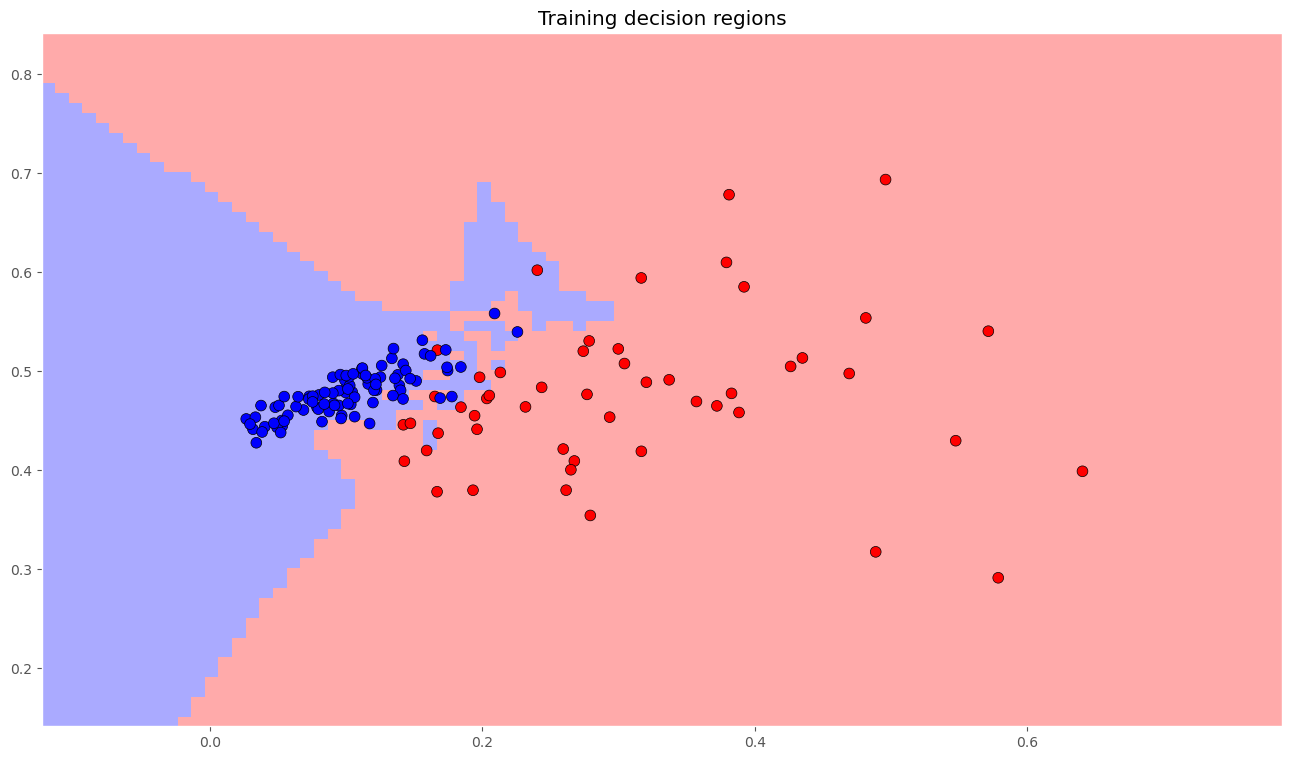

In [191]:
fig = plt.figure(figsize=(16,9))
plot_decision_regions(test_reduced.inputs, test_reduced.target, nn, title="Training decision regions", resolution=.01)

A very useful measure/visualizition is the ROC curve (not really a curve, but just a point here). As stated above it is a plot of the true positive rate on the y-axis against the false-positive rate on the x axis. A good classifier should be as close to the upper left hand corner as possible. We will plot the ROC for both of our classifiers as another way to compare the two.

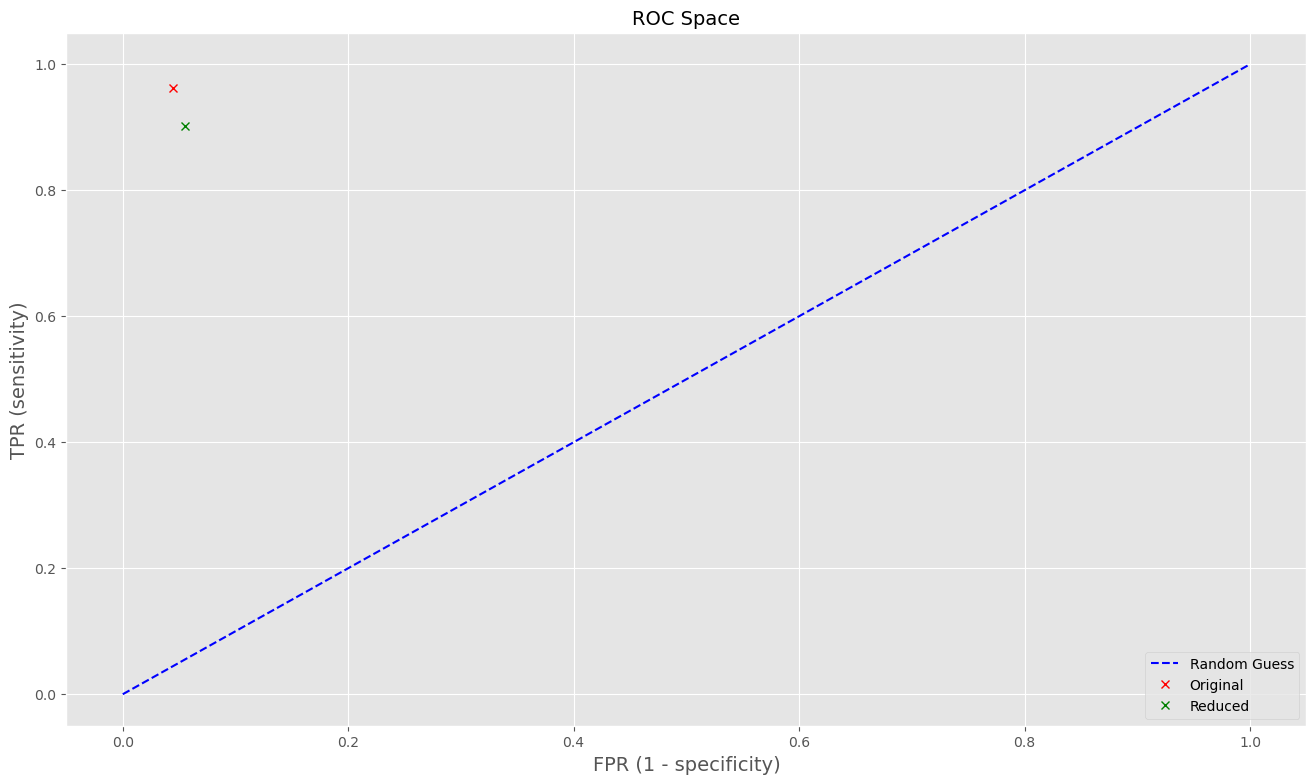

In [192]:
plot_ROC(test_cm, test_cm_reduced)

Both are in good positions in the space here. The original classifier has a bit higher TPR and also a bit lower FPR as well. It is close to that ideal upper left position.

And now a basic, straighforward measure of model performance. We will use our average function to compute the average test and training accuracies on both sets over ten iterations and report the results.

In [193]:
nn_avg_train_original, nn_avg_train_reduced, nn_avg_test_original, nn_avg_test_reduced = compute_average_accuracies(nn_original, nn)

print("Average train accuracy on original dataset: ", nn_avg_train_original)
print("Average train accuracy on reduced dataset: ", nn_avg_train_reduced)
print("Average test accuracy on original dataset: ", nn_avg_test_original)
print("Average test accuracy on reduced dataset: ", nn_avg_test_reduced)

Average train accuracy on original dataset:  1.0
Average train accuracy on reduced dataset:  1.0
Average test accuracy on original dataset:  0.9014084507042254
Average test accuracy on reduced dataset:  0.9014084507042254


In [194]:
# Save the results
results[0,:] = [nn_avg_train_original, nn_avg_train_reduced, nn_avg_test_original, nn_avg_test_reduced]

### K Nearest Neighbors

Now we will consider a KNN model with different values of K. This does the same thing as the Nearest Neighbor, but it instead finds the K nearest neighbors and returns the majority class out of those as the label for a datapoint. We will perform cross-validation to determine the best value of K. Specifically, we use ten-fold cross validation. This is a common technique when data is limited. It involves splitting the data into 10 equal sized "folds" and creating 10 training and validation sets, where the validation set is the ith column and the train set is the rest of the dataset. You then fit a model on the train set and get the prediction error using the validation set 10 times. The final returned error is the average of each of these errors.

In [195]:
def tenFoldCrossValidationKNN(data, hparam):
    # Divide data into 10 equal sized folds (if not equal, will be close)
    split_data = np.array_split(data.examples, 10)
    
    err = 0
    for i in range(10):
        df_train = pd.concat([split_data[j] for j in range(10) if j != i], axis=0)
        df_validation = pd.concat([split_data[j] for j in range(10) if j == i], axis=0)
        
        train_set = my.DataSet(df_train, y=True)
        validation_set = my.DataSet(df_validation, y=True)
        
        learner = KNeighborsClassifier(n_neighbors=hparam)
        learner.fit(train_set.inputs, train_set.target.ravel())
        predicted = learner.predict(validation_set.inputs)
        
        err += errorMeasure(validation_set.target, predicted)
        
    return err / 10

Now we will plot the values of k from 1 to 20 against the errors returned by the ten-fold cross-validation function:

Text(0, 0.5, 'Error (1 - accuracy)')

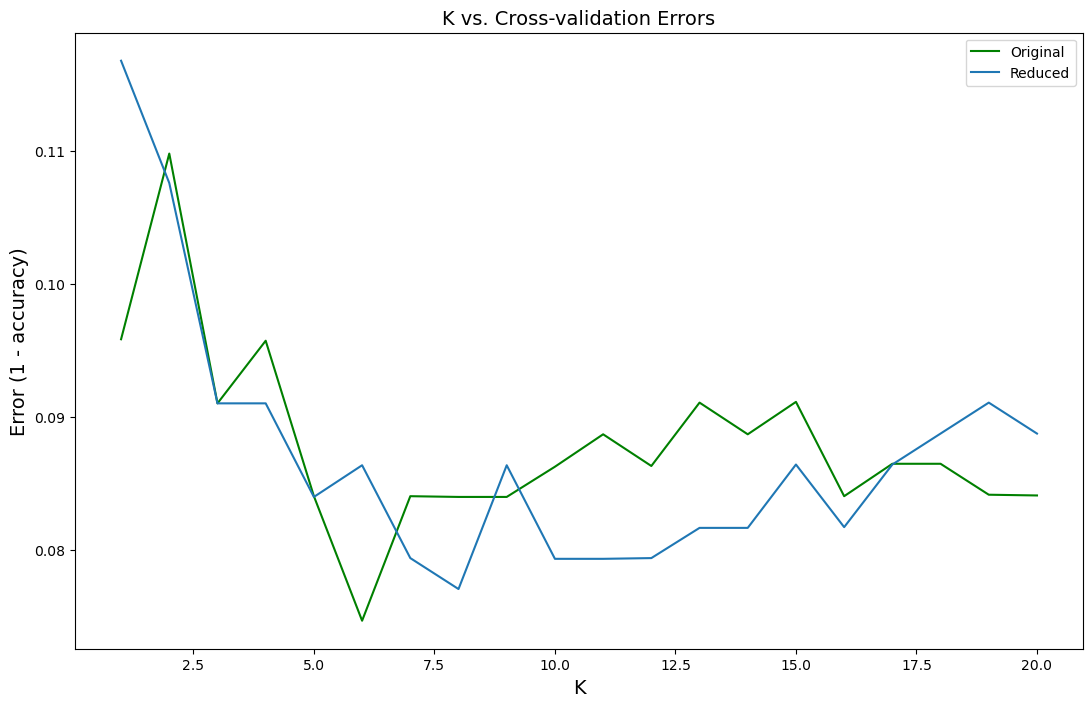

In [196]:
k_vals = np.arange(1, 21)
y1 = np.array([tenFoldCrossValidationKNN(train, k) for k in k_vals])
y = np.array([tenFoldCrossValidationKNN(train_reduced, k) for k in k_vals])

fig = plt.figure(figsize=(13,8))
plt.style.use('default')
plt.plot(k_vals, y1, 'g-', label='Original')
plt.plot(k_vals, y, label='Reduced')
plt.title("K vs. Cross-validation Errors", fontsize=14)
plt.legend(loc='best')
plt.xlabel("K", fontsize=14)
plt.ylabel("Error (1 - accuracy)", fontsize=14)

The value of the K with the lowest error looks to be 6 for the original dataset and 8 for the reduced dataset, so let's fit KNN models with those numbers of neighbors and see how they perform.

In [197]:
knn_reduced = KNeighborsClassifier(n_neighbors=8)
knn_reduced.fit(train_reduced.inputs, train_reduced.target.ravel())

cm = my.confusion_matrix(train_reduced.target, knn_reduced.predict(train_reduced.inputs))
accuracy = np.trace(cm) / np.sum(cm)

print(cm)
print('Reduced data train accuracy: ', accuracy)

test_cm_reduced = my.confusion_matrix(test_reduced.target, knn_reduced.predict(test_reduced.inputs))
accuracy = np.trace(test_cm_reduced) / np.sum(test_cm_reduced)

print(test_cm_reduced)
print('Reduced data test accuracy: ', accuracy)

[[142  19]
 [  9 257]]
Reduced data train accuracy:  0.9344262295081968
[[49  2]
 [ 3 88]]
Reduced data test accuracy:  0.9647887323943662


Very good results here from the 5NN model on the reduced dataset. Here we see more of a balance between over and underfitting compared to the NN. Let's again plot the decision regions.

<Figure size 1600x900 with 0 Axes>

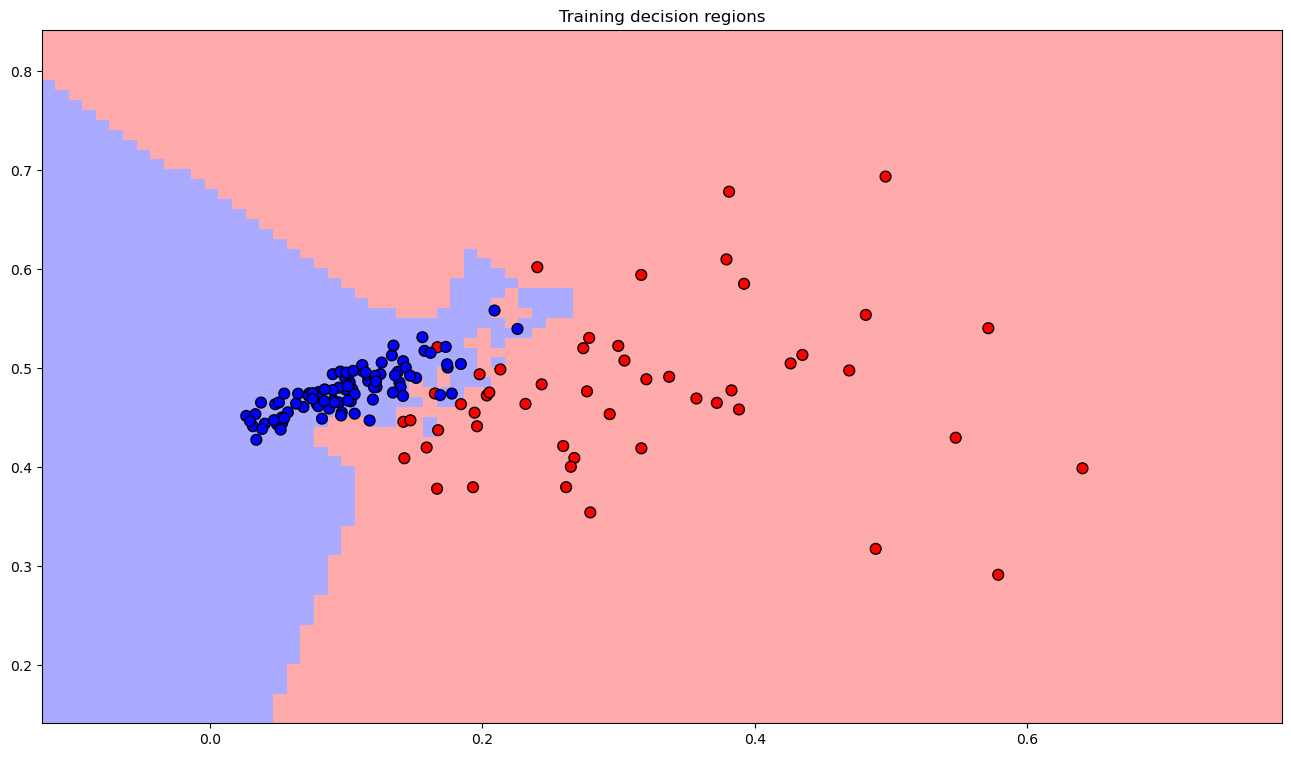

In [198]:
fig = plt.figure(figsize=(16,9))
plot_decision_regions(test_reduced.inputs, test_reduced.target, nn, title="Training decision regions", resolution=0.01)

Test the KNN with 3 neighbors on the original dataset.

In [199]:
knn_original = KNeighborsClassifier(n_neighbors=6)
knn_original.fit(train.inputs, train.target.ravel())

cm = my.confusion_matrix(train.target, knn_original.predict(train.inputs))
accuracy = np.trace(cm) / np.sum(cm)

print(cm)
print('Original data train accuracy: ', accuracy)

test_cm = my.confusion_matrix(test.target, knn_original.predict(test.inputs))
accuracy = np.trace(test_cm) / np.sum(test_cm)

print(test_cm)
print('Original data test accuracy: ', accuracy)

[[143  16]
 [ 13 255]]
Original data train accuracy:  0.9320843091334895
[[52  1]
 [ 5 84]]
Original data test accuracy:  0.9577464788732394


Better results here. The KNN model fit on our original dataset was able to get a good training and test accuracy, but the reduced model actually performed better in this case.

Plot the ROC for each model:

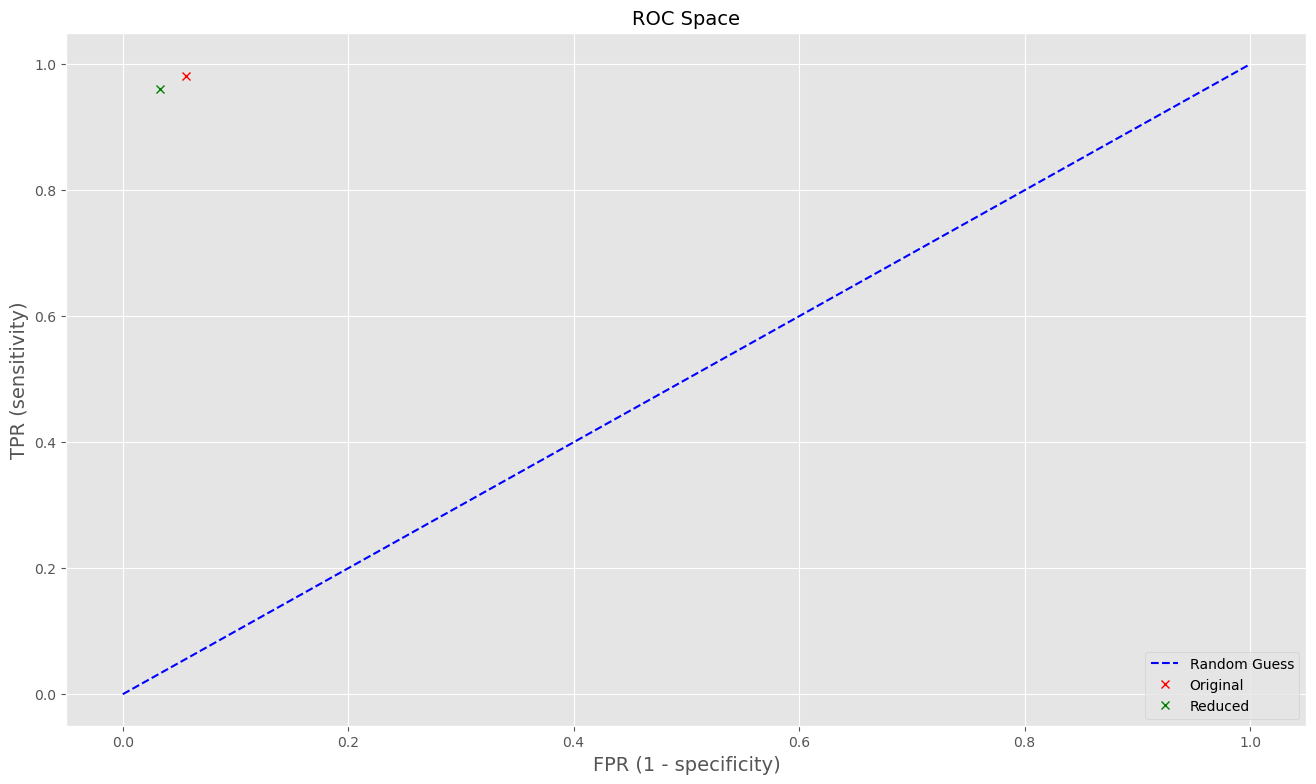

In [200]:
plot_ROC(test_cm, test_cm_reduced)

Both did very well and are almost in the same spot. The original model had a slightly higher FPR. Now compute the averages for the training and testing accuracies.

In [201]:
knn_avg_train_original, knn_avg_train_reduced, knn_avg_test_original, knn_avg_test_reduced = compute_average_accuracies(knn_original, knn_reduced)

print("Average train accuracy on original dataset: ", knn_avg_train_original)
print("Average train accuracy on reduced dataset: ", knn_avg_train_reduced)
print("Average test accuracy on original dataset: ", knn_avg_test_original)
print("Average test accuracy on reduced dataset: ", knn_avg_test_reduced)

Average train accuracy on original dataset:  0.9484777517564404
Average train accuracy on reduced dataset:  0.9414519906323184
Average test accuracy on original dataset:  0.9295774647887323
Average test accuracy on reduced dataset:  0.9154929577464788


In [202]:
# Save the results
results[1,:] = [knn_avg_train_original, knn_avg_train_reduced, knn_avg_test_original, knn_avg_test_reduced]

## Gaussian Naive Bayers Classifier

Another fairly simple model is the Gaussian Naive Bayes classifier. Given an unseen example $\boldsymbol{x}$, we want to predict its corresponding $y$ from a set of possible classes $y_1, y_2, \dots$. We can do so by picking the $y$ such that:
$$ y = \operatorname*{argmax}_{i}\ \ P(y_i | \boldsymbol{x})$$

We can calculate $P(y_i | \boldsymbol{x})$ using the formula:
$$ P(y_i | \boldsymbol{x}) = \alpha\ P(y_i) P(\boldsymbol{x} | y_i) $$

where $\alpha$ is a normalizing factor and $P(y_i)$ is the prior probability which can be estimated from the training dataset. In the case of continous features, such as ours, we can estimate the conditional probability $P(\boldsymbol{x} | y_i)$ with a Gaussian (normal) distribution. Both paramters $\mu$ and $\sigma$ are also estimated using the training dataset.

What makes Naive Bayes naive, the strong assumption that the features $x_1, x_2, x_3, \cdots, x_m$ are independent from one another. Such an assumption allows us to write:

$$P(\boldsymbol{x} | y_i) = P(x_1, x_2, x_3, \cdots, x_m| y_i) = P(x_1 | y_i)P(x_2 | y_i)P(x_3 | y_i)\cdots P(x_m | y_i)$$
 
The $P(x_j | y_i)$ is the likelihood of $x_j$ given the class $y_i$, which can be estimated from the training set as well.

First we will fit a model on our PCA reduced dataset.

In [203]:
from sklearn.naive_bayes import GaussianNB

gnb_reduced = GaussianNB()
gnb_reduced.fit(train_reduced.inputs, train_reduced.target.ravel())

GaussianNB()

Unfortunately there isn't much for us in the case of hyperparameter tuning for this specific model. So continuing our pattern, lets evalutate this GNB model with the usual metrics:

In [204]:
cm = my.confusion_matrix(train_reduced.target, gnb_reduced.predict(train_reduced.inputs))
accuracy = np.trace(cm) / np.sum(cm)

print(cm)
print('Reduced data training accuracy: ', accuracy)

test_cm_reduced = my.confusion_matrix(test_reduced.target, gnb_reduced.predict(test_reduced.inputs))
accuracy = np.trace(test_cm_reduced) / np.sum(test_cm_reduced)

print(test_cm_reduced)
print('Reduced data test accuracy: ', accuracy)

[[126  35]
 [  6 260]]
Reduced data training accuracy:  0.9039812646370023
[[38 13]
 [ 2 89]]
Reduced data test accuracy:  0.8943661971830986


The decision regions:

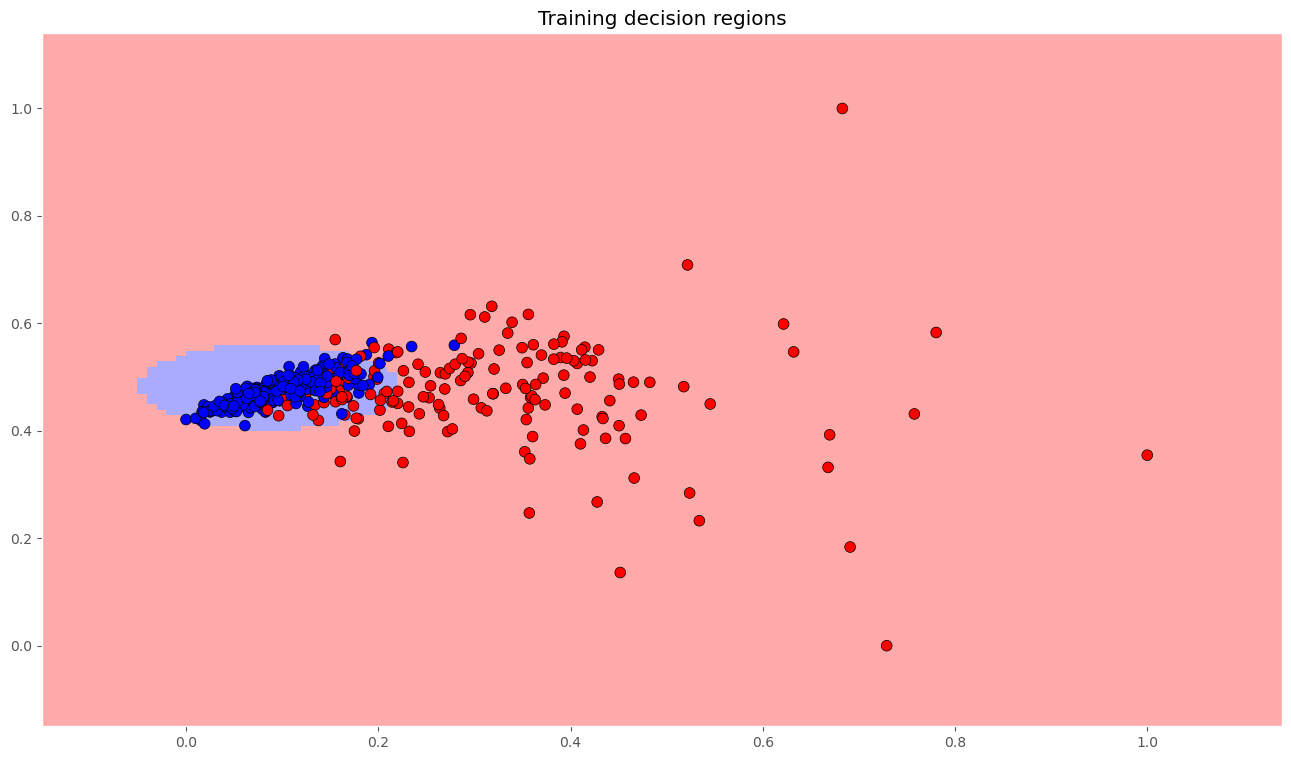

In [205]:
plot_decision_regions(train_reduced.inputs, train_reduced.target, gnb_reduced, resolution=0.01, title="Training decision regions")

And now fit a new model on the original dataset.

In [206]:
gnb_original = GaussianNB()
gnb_original.fit(train.inputs, train.target.ravel())

GaussianNB()

Compute the performance metrics:

In [207]:
cm = my.confusion_matrix(train.target, gnb_original.predict(train.inputs))
accuracy = np.trace(cm) / np.sum(cm)

print(cm)
print('Original data training accuracy: ', accuracy)

test_cm= my.confusion_matrix(test.target, gnb_original.predict(test.inputs))
accuracy = np.trace(test_cm) / np.sum(test_cm)

print(test_cm)
print('Original data test accuracy: ', accuracy)

[[138  21]
 [ 10 258]]
Original data training accuracy:  0.927400468384075
[[50  3]
 [ 0 89]]
Original data test accuracy:  0.9788732394366197


This GNB model appears to be much better, with a significantly higher training and test accuracy than the model fit on the 2D dataset. This discretion is likely due to the fact that we are dealing almost exclusively with probabilities, and so the model has a harder time learning with few features. We would want to trust this one over the other, especially in the context of our classification problem.

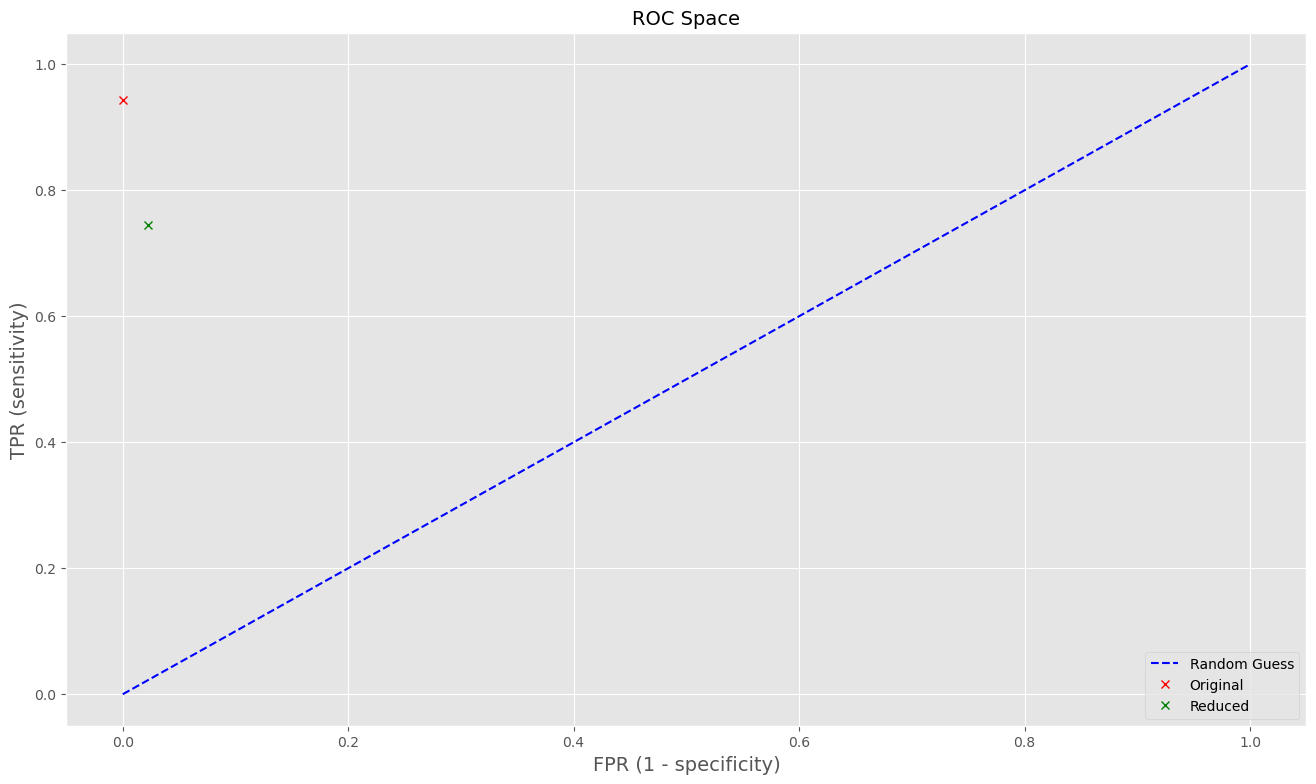

In [208]:
plot_ROC(test_cm, test_cm_reduced)

This ROC plot better shows the poorer performance of the reduced dataset model. You can notice the point is lower on the y-axis than the other model, which is closer to the ideal spot in the space. And lastly, we compute the average values and save them for later.

In [209]:
gnb_avg_train_original, gnb_avg_train_reduced, gnb_avg_test_original, gnb_avg_test_reduced = compute_average_accuracies(gnb_original, gnb_reduced)

print("Average train accuracy on original dataset: ", gnb_avg_train_original)
print("Average train accuracy on reduced dataset: ", gnb_avg_train_reduced)
print("Average test accuracy on original dataset: ", gnb_avg_test_original)
print("Average test accuracy on reduced dataset: ", gnb_avg_test_reduced)

Average train accuracy on original dataset:  0.9367681498829039
Average train accuracy on reduced dataset:  0.8946135831381733
Average test accuracy on original dataset:  0.9225352112676057
Average test accuracy on reduced dataset:  0.9225352112676057


In [210]:
results[2,:] = [gnb_avg_train_original, gnb_avg_train_reduced, gnb_avg_test_original, gnb_avg_test_reduced]

## Logistic Regression

We now arrive at the first linear model we use in this project, Logistic Regression. The name is misleading as we actually use it in our case for classification. Like most other linear models, it tries to fit a line to the dataset and with optimal weights by minimizing an error function. A prediction for an unseen example x is computed using the sigmoid function:
$$h(x) = g(xw) = \frac{1}{1 + e^{-xw}}$$
and some threshold such that we return a 1 if $h(x)$ is above that threshold and a -1 otherwise, which is how we are able to use it for binary classification. Gradient descent is used to minimize the error and update the weights.

### Cross-validation

Scikit-Learn's LogisticRegression class has a hyperparameter C, which is the inverse of the regularization strength. Smaller values indicate stronger regularization. This is something we should tune, so let's tweak or `tenFoldCrossValidation` function to work with this class and use values of C. Note the max_iter parameter. With more data and more features, a logistic regressor will take more epochs to converge. We set this parameter to 10,000 to ensure we converge on all models. The class uses early stopping anyways.

In [211]:
from sklearn.linear_model import LogisticRegression

def tenFoldCrossValidationLogistic(data, hparam):
    # Divide data into 10 equal sized folds (if not equal, will be close)
    split_data = np.array_split(data.examples, 10)
    
    err = 0
    for i in range(10):
        df_train = pd.concat([split_data[j] for j in range(10) if j != i], axis=0)
        df_validation = pd.concat([split_data[j] for j in range(10) if j == i], axis=0)
        
        train_set = my.DataSet(df_train, y=True)
        validation_set = my.DataSet(df_validation, y=True)
        
        learner = LogisticRegression(C=hparam, max_iter=10000)
        learner.fit(train_set.inputs, train_set.target.ravel())
        predicted = learner.predict(validation_set.inputs)
        
        err += errorMeasure(validation_set.target, predicted)
        
    return err / 10

Now let's plot the error against various values of C, we will use [1,100] as our range

Text(0, 0.5, 'Error (1 - accuracy)')

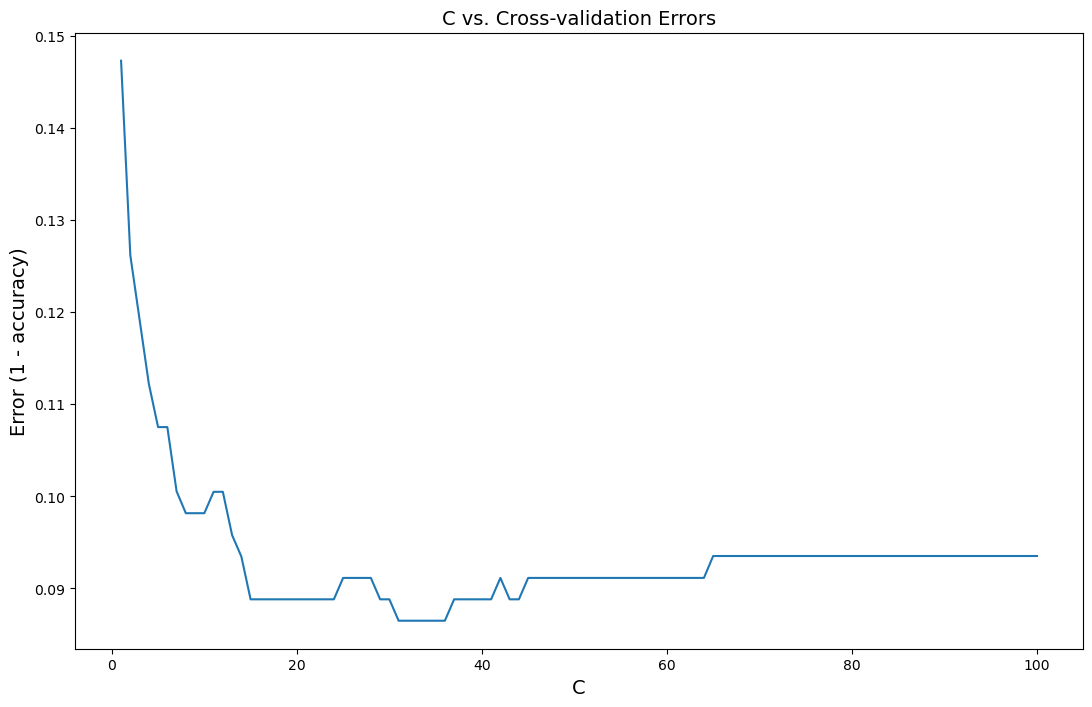

In [212]:
c_vals = np.arange(1, 101)
y = np.array([tenFoldCrossValidationLogistic(train_reduced, c) for c in c_vals])
plt.style.use('default')

fig = plt.figure(figsize=(13,8))
plt.plot(c_vals, y)
plt.title("C vs. Cross-validation Errors", fontsize=14)
plt.xlabel("C", fontsize=14)
plt.ylabel("Error (1 - accuracy)", fontsize=14)

It looks like C=40 is the best value. Anything after that seems to increase the error and we suspect the same will happen beyond values of 100. Now we fit a logistic regressor on our reduced training data using C=40.

In [213]:
log_reduced = LogisticRegression(C=40)
log_reduced.fit(train_reduced.inputs, train_reduced.target.ravel())

LogisticRegression(C=40)

And display the confusion matrix and accuracy for the reduced train and test sets

In [214]:
cm = my.confusion_matrix(train_reduced.target, log_reduced.predict(train_reduced.inputs))
accuracy = np.trace(cm) / np.sum(cm)

print(cm)
print('Reduced data training accuracy: ', accuracy)

test_cm_reduced = my.confusion_matrix(test_reduced.target, log_reduced.predict(test_reduced.inputs))
accuracy = np.trace(test_cm_reduced) / np.sum(test_cm_reduced)

print(test_cm_reduced)
print('Reduced data test accuracy: ', accuracy)

[[130  31]
 [  7 259]]
Reduced data training accuracy:  0.9110070257611241
[[46  5]
 [ 1 90]]
Reduced data test accuracy:  0.9577464788732394


Not too bad, both values are in the 90% range and the test accuracy is quite high. Let's plot the decision regions for the reduced training set

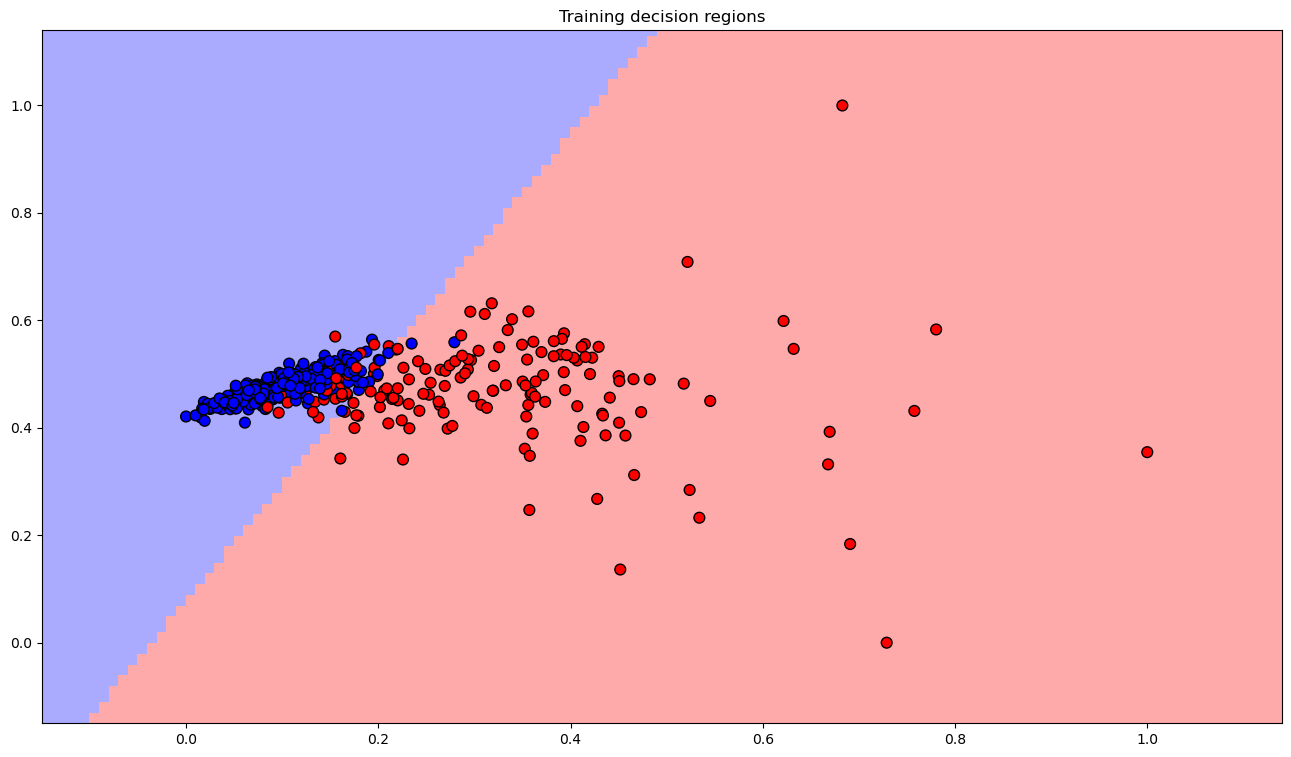

In [215]:
plot_decision_regions(train_reduced.inputs, train_reduced.target, log_reduced, resolution=0.01, title="Training decision regions")

We will continue our pattern and now look at the performance of the LogisticRegression classifier on the original, 30-dimensional dataset. We should tune the hyperparameter C again on this set as it will likely be different than on the reduced dataset. Let's do that now:

C:\Users\Hunter Bryan\miniconda3\envs\machine-learning\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Text(0, 0.5, 'Error (1 - accuracy)')

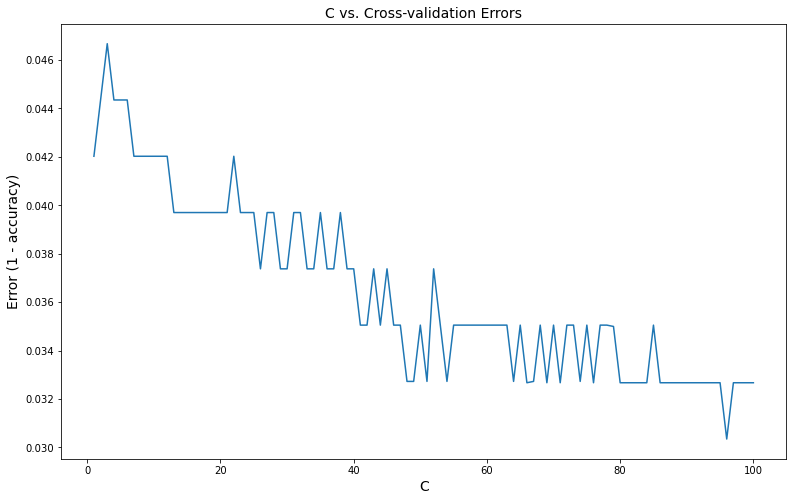

In [267]:
c_vals = np.arange(1, 101)
y = np.array([tenFoldCrossValidationLogistic(train, c) for c in c_vals])

fig = plt.figure(figsize=(13,8))
plt.plot(c_vals, y)
plt.title("C vs. Cross-validation Errors", fontsize=14)
plt.xlabel("C", fontsize=14)
plt.ylabel("Error (1 - accuracy)", fontsize=14)

It looks like C=90 is a better value for a model on the original dataset. We will use that to fit a LogisticRegressor with.

In [216]:
log_original = LogisticRegression(max_iter=10000, C=95)
log_original.fit(train.inputs, train.target.ravel())

LogisticRegression(C=95, max_iter=10000)

And now compute our usual metrics to look at its performance:

In [217]:
cm = my.confusion_matrix(train.target, log_original.predict(train.inputs))
accuracy = np.trace(cm) / np.sum(cm)

print(cm)
print('Original data training accuracy: ', accuracy)

test_cm= my.confusion_matrix(test.target, log_original.predict(test.inputs))
accuracy = np.trace(test_cm) / np.sum(test_cm)

print(test_cm)
print('Original data test accuracy: ', accuracy)

[[153   6]
 [  4 264]]
Original data training accuracy:  0.9765807962529274
[[51  2]
 [ 2 87]]
Original data test accuracy:  0.971830985915493


These are definitely the best results we have gotten yet. It has a very high training accuracy without overfitting the data; the test accuracy is very good as well. We can see the power of linear classifiers here. We would expect the point in the ROC space to be very close to the upper lefthand corner.

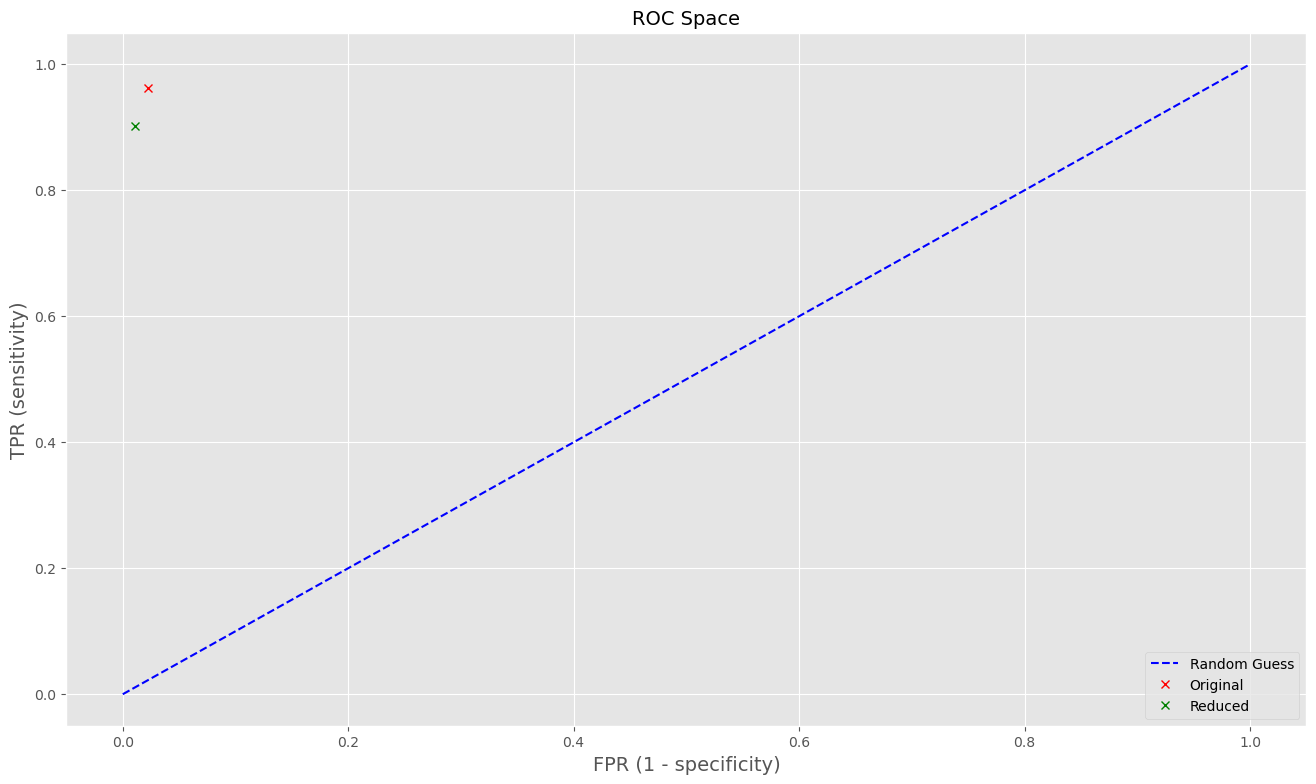

In [218]:
plot_ROC(test_cm, test_cm_reduced)

Indeed, our original classifier is has a great ROC value. The original classifier did slightly better than the reduced one in the case of logistic regression. 

Lastly we get the average accuracies to make sure these models can perform at a high level repeatedly:

In [219]:
log_avg_train_original, log_avg_train_reduced, log_avg_test_original, log_avg_test_reduced = compute_average_accuracies(log_original, log_reduced)

print("Average train accuracy on original dataset: ", log_avg_train_original)
print("Average train accuracy on reduced dataset: ", log_avg_train_reduced)
print("Average test accuracy on original dataset: ", log_avg_test_original)
print("Average test accuracy on reduced dataset: ", log_avg_test_reduced)

Average train accuracy on original dataset:  0.9859484777517566
Average train accuracy on reduced dataset:  0.9274004683840749
Average test accuracy on original dataset:  0.9295774647887323
Average test accuracy on reduced dataset:  0.9014084507042254


In [220]:
results[3,:] = [log_avg_train_original, log_avg_train_reduced, log_avg_test_original, log_avg_test_reduced]

## Decision Tree

Decision Tree's are a popular algorithm for classification. The model works by partitioning the input space into several different partitions (disjunctions) based off of the features, where each example falls into. The algorithm works by finding the 'best' feature (e.g. the one that gives the most information about an example) using one of two formulas: Gain and the weighted Gini index. The Gain is defined by:
$${\displaystyle \operatorname {Gain(F,D)} =H(D) -\sum_{f \in values(F)}\frac{|D_f|}{|D|}H(D_f)}$$
where ${\displaystyle \operatorname {H(D)}}$ is the entropy and $${\displaystyle \mathrm {H(D)}=\sum _{i=1}^{L}{p_{i}\frac{1}{\log p_{i}}}=-\sum _{i=1}^{L}{p_{i}\log p_{i}}}$$
Then it takes that feature as the root node and recursively builds the tree on subsets of examples, finding the next best features as nodes and so on. The leaves of nodes are the classifications for an example.

Let's import a decision tree classifier and fit it, as usual, to our reduced data first and test it's ability.

In [221]:
from sklearn.tree import DecisionTreeClassifier

tree_reduced = DecisionTreeClassifier(criterion='entropy')
tree_reduced.fit(train_reduced.inputs, train_reduced.target.ravel())

DecisionTreeClassifier(criterion='entropy')

Compute the matrix and accuracy:

In [222]:
cm = my.confusion_matrix(train_reduced.target, tree_reduced.predict(train_reduced.inputs))
accuracy = np.trace(cm) / np.sum(cm)

print(cm)
print('Reduced data training accuracy: ', accuracy)

test_cm_reduced = my.confusion_matrix(test_reduced.target, tree_reduced.predict(test_reduced.inputs))
accuracy = np.trace(test_cm_reduced) / np.sum(test_cm_reduced)

print(test_cm_reduced)
print('Reduced data test accuracy: ', accuracy)

[[161   0]
 [  0 266]]
Reduced data training accuracy:  1.0
[[46  5]
 [ 4 87]]
Reduced data test accuracy:  0.9366197183098591


Wow! A perfect training accuracy on the projected dataset. This is good, but a sign of potential overfitting. Decision trees are notorious for overfitting data. Luckily, the test accuracy is still pretty high here.

We mentioned another metric for computing the best feature, the Gini index. This is defined as: 
$${\displaystyle \operatorname {Gini(F,D)} = \sum_{f \in values(F)}\frac{|D_f|}{|D|}G(D_f)}$$
where ${\displaystyle \operatorname {G(D)}}$ is the Gini impurity defined by:
$${\displaystyle \mathrm {G(D)}=1 -\sum _{i=1}^{L}{p_{i}}^2}$$
By default, the DecisionTreeClassifier uses it. Let's see if there is any difference in performance.

In [223]:
tree2 = DecisionTreeClassifier()
tree2.fit(train_reduced.inputs, train_reduced.target.ravel())

cm = my.confusion_matrix(train_reduced.target, tree2.predict(train_reduced.inputs))
accuracy = np.trace(cm) / np.sum(cm)

print(cm)
print('Reduced data training accuracy: ', accuracy)

test_cm_reduced = my.confusion_matrix(test_reduced.target, tree2.predict(test_reduced.inputs))
accuracy = np.trace(test_cm_reduced) / np.sum(test_cm_reduced)

print(test_cm_reduced)
print('Reduced data test accuracy: ', accuracy)

[[161   0]
 [  0 266]]
Reduced data training accuracy:  1.0
[[48  3]
 [ 3 88]]
Reduced data test accuracy:  0.9577464788732394


It looks like the results are almost identical and the test accuracy was a little better when using the Gini index, so we will go with that as our criterion. Let's check out the decision regions for this classifier on the reduced dataset.

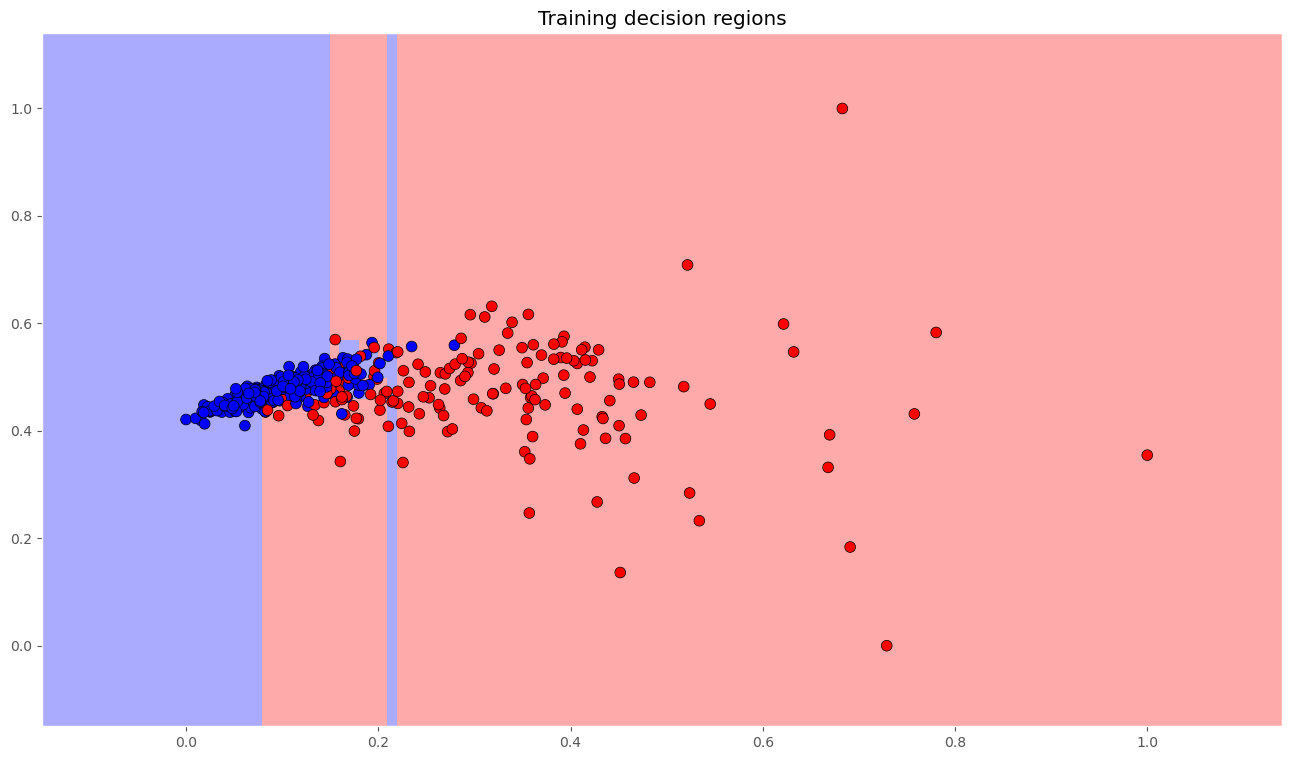

In [228]:
plot_decision_regions(train_reduced.inputs, train_reduced.target, tree2, resolution=0.01, title="Training decision regions")

Notice how the decision tree partitions the input space into separate regions. This decision plot is quite different than any of the others. And now we fit our original dataset; first using entropy as our information measure.

In [235]:
tree_original = DecisionTreeClassifier(criterion='entropy')
tree_original.fit(train.inputs, train.target.ravel())

DecisionTreeClassifier(criterion='entropy')

The results:

In [236]:
cm = my.confusion_matrix(train.target, tree_original.predict(train.inputs))
accuracy = np.trace(cm) / np.sum(cm)

print(cm)
print('Original data training accuracy: ', accuracy)

test_cm= my.confusion_matrix(test.target, tree_original.predict(test.inputs))
accuracy = np.trace(test_cm) / np.sum(test_cm)

print(test_cm)
print('Original data test accuracy: ', accuracy)

[[159   0]
 [  0 268]]
Original data training accuracy:  1.0
[[50  3]
 [ 4 85]]
Original data test accuracy:  0.9507042253521126


And now do the same but with Gini to see if we can improve on our performance.

In [237]:
tree_original2 = DecisionTreeClassifier()
tree_original2.fit(train.inputs, train.target.ravel())

cm = my.confusion_matrix(train.target, tree_original2.predict(train.inputs))
accuracy = np.trace(cm) / np.sum(cm)

print(cm)
print('Original data training accuracy: ', accuracy)

test_cm= my.confusion_matrix(test.target, tree_original2.predict(test.inputs))
accuracy = np.trace(test_cm) / np.sum(test_cm)

print(test_cm)
print('Original data test accuracy: ', accuracy)

[[159   0]
 [  0 268]]
Original data training accuracy:  1.0
[[50  3]
 [ 1 88]]
Original data test accuracy:  0.971830985915493


Again, the training accuracy was 100% but the test accuracy was just slightly better, so we will stick to using Gini.

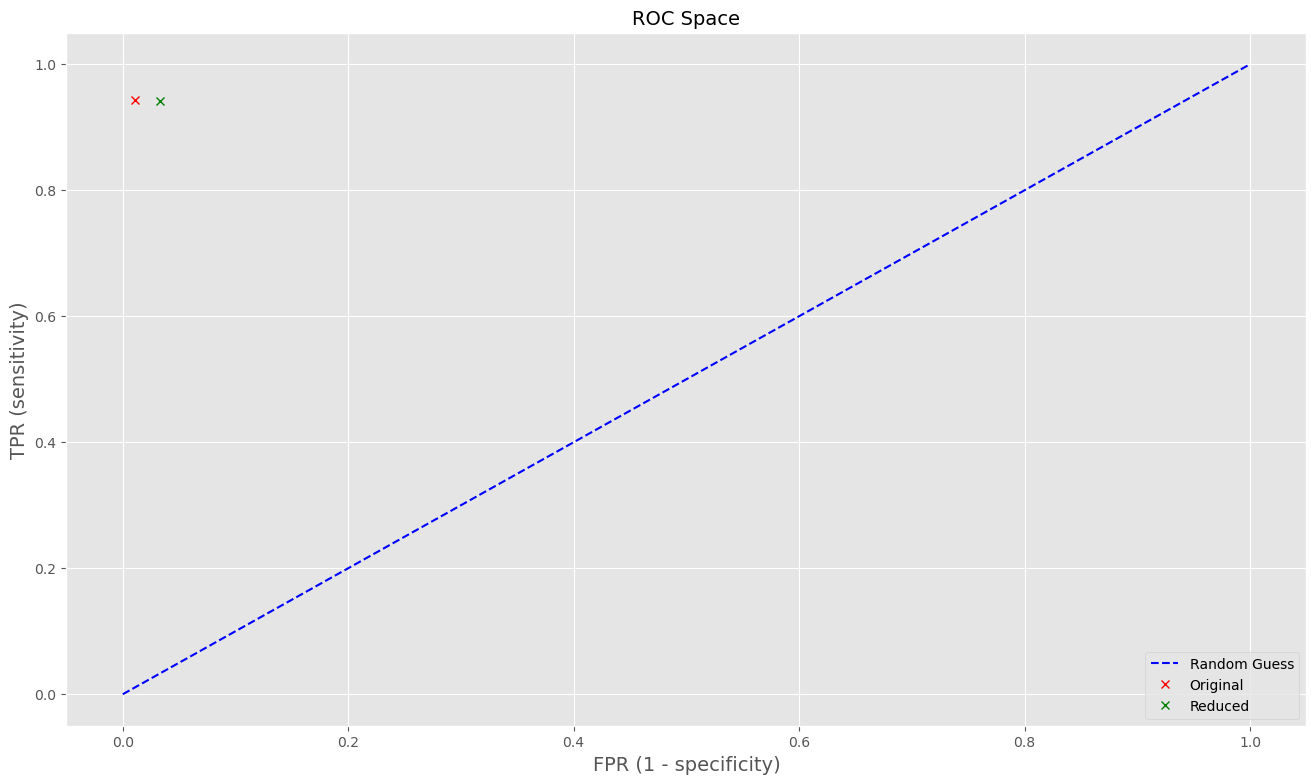

In [238]:
plot_ROC(test_cm, test_cm_reduced)

Both models look solid on the ROC plot. Now we need to run some classifiers and get average results.

In [239]:
tree_avg_train_original, tree_avg_train_reduced, tree_avg_test_original, tree_avg_test_reduced = compute_average_accuracies(tree_original2, tree2)

print("Average train accuracy on original dataset: ", tree_avg_train_original)
print("Average train accuracy on reduced dataset: ", tree_avg_train_reduced)
print("Average test accuracy on original dataset: ", tree_avg_test_original)
print("Average test accuracy on reduced dataset: ", tree_avg_test_reduced)

Average train accuracy on original dataset:  1.0
Average train accuracy on reduced dataset:  1.0
Average test accuracy on original dataset:  0.9309859154929578
Average test accuracy on reduced dataset:  0.8873239436619718


The average test accuracy for the reduced model is much lower than our run above. This shows why it is important to look at average performance as well.

In [241]:
results[4,:] = [tree_avg_train_original, tree_avg_train_reduced, tree_avg_test_original, tree_avg_test_reduced]

## The Multilayer Percepton Neural Network

A Multilayer Perceptron (MLP) is a set of perceptrons that are arranged into multiple layers: one layer for the input (examples), one "hidden" layer and one layer for the output. The goal is to have a learner that:
* works for both regression and classification
* is a universal function approximator

The MLP requires a couple of things:
* An activation function. There are several different activation functions that can be used depending on the type of problem. One popular one is the sigmoid function: 
$$g(z) = \frac{1}{1 + e^{-z}}$$
* The default in scikit learn and another popular activation function is the ReLU, define as :
$$f(x) - max(0, x)$$

* A Differentiable loss function; a common choice is the $L_2$ loss function.

With the above in mind, we can build an MLP learner by having one layer between the input and output. The figure below depicts an MLP with one hidden layer. This is the quintessential neural network (NN); it is fully connected and feed-forward. Each connection has a weight associated with it. These weights are the primary part of an MLP and they are what does the "learning." The weights are optimized such that the loss function reaches a global minimum. They are updated each iteration using gradient descent.

<img width="50%" src="data:image/svg+xml,%3Csvg version='1.1' viewBox='0.0 0.0 691.0551181102362 609.0446194225722' fill='none' stroke='none' stroke-linecap='square' stroke-miterlimit='10' xmlns:xlink='http://www.w3.org/1999/xlink' xmlns='http://www.w3.org/2000/svg'%3E%3CclipPath id='p.0'%3E%3Cpath d='m0 0l691.0551 0l0 609.0446l-691.0551 0l0 -609.0446z' clip-rule='nonzero'/%3E%3C/clipPath%3E%3Cg clip-path='url(%23p.0)'%3E%3Cpath fill='%23000000' fill-opacity='0.0' d='m0 0l691.0551 0l0 609.0446l-691.0551 0z' fill-rule='evenodd'/%3E%3Cpath fill='%23f4cccc' d='m0 39.19685l0 0c0 -21.647821 17.549028 -39.19685 39.19685 -39.19685l0 0c10.395653 0 20.365524 4.1296563 27.716358 11.480492c7.3508377 7.350836 11.480492 17.320707 11.480492 27.716358l0 0c0 21.647823 -17.549026 39.19685 -39.19685 39.19685l0 0c-21.647821 0 -39.19685 -17.549026 -39.19685 -39.19685z' fill-rule='evenodd'/%3E%3Cpath stroke='%23000000' stroke-width='1.0' stroke-linejoin='round' stroke-linecap='butt' d='m0 39.19685l0 0c0 -21.647821 17.549028 -39.19685 39.19685 -39.19685l0 0c10.395653 0 20.365524 4.1296563 27.716358 11.480492c7.3508377 7.350836 11.480492 17.320707 11.480492 27.716358l0 0c0 21.647823 -17.549026 39.19685 -39.19685 39.19685l0 0c-21.647821 0 -39.19685 -17.549026 -39.19685 -39.19685z' fill-rule='evenodd'/%3E%3Cpath fill='%23000000' d='m40.962116 46.116848l-1.640625 0l0 -10.453125q-0.59375 0.5625 -1.5625 1.140625q-0.953125 0.5625 -1.71875 0.84375l0 -1.59375q1.375 -0.640625 2.40625 -1.5625q1.03125 -0.921875 1.453125 -1.78125l1.0625 0l0 13.40625z' fill-rule='nonzero'/%3E%3Cpath fill='%23ffd966' d='m0 274.37796l0 0c0 -21.647827 17.549028 -39.196854 39.19685 -39.196854l0 0c10.395653 0 20.365524 4.129654 27.716358 11.480484c7.3508377 7.3508453 11.480492 17.32071 11.480492 27.71637l0 0c0 21.647827 -17.549026 39.19684 -39.19685 39.19684l0 0c-21.647821 0 -39.19685 -17.549011 -39.19685 -39.19684z' fill-rule='evenodd'/%3E%3Cpath stroke='%23000000' stroke-width='1.0' stroke-linejoin='round' stroke-linecap='butt' d='m0 274.37796l0 0c0 -21.647827 17.549028 -39.196854 39.19685 -39.196854l0 0c10.395653 0 20.365524 4.129654 27.716358 11.480484c7.3508377 7.3508453 11.480492 17.32071 11.480492 27.71637l0 0c0 21.647827 -17.549026 39.19684 -39.19685 39.19684l0 0c-21.647821 0 -39.19685 -17.549011 -39.19685 -39.19684z' fill-rule='evenodd'/%3E%3Cpath fill='%23000000' d='m31.214893 281.29794l3.53125 -5.03125l-3.265625 -4.640625l2.046875 0l1.484375 2.265625q0.421875 0.640625 0.671875 1.078125q0.40625 -0.59375 0.734375 -1.0625l1.640625 -2.28125l1.953125 0l-3.34375 4.546875l3.59375 5.125l-2.015625 0l-1.984375 -3.0l-0.515625 -0.8125l-2.546875 3.8125l-1.984375 0z' fill-rule='nonzero'/%3E%3Cpath fill='%23000000' d='m45.04302 288.29794l-1.09375 0l0 -6.96875q-0.40625 0.375 -1.046875 0.75q-0.640625 0.375 -1.140625 0.578125l0 -1.0625q0.90625 -0.4375 1.59375 -1.046875q0.6875 -0.609375 0.96875 -1.1875l0.71875 0l0 8.9375z' fill-rule='nonzero'/%3E%3Cpath fill='%23ffd966' d='m0 431.16534l0 0c0 -21.647827 17.549028 -39.19684 39.19685 -39.19684l0 0c10.395653 0 20.365524 4.129669 27.716358 11.480499c7.3508377 7.35083 11.480492 17.32071 11.480492 27.71634l0 0c0 21.647827 -17.549026 39.19687 -39.19685 39.19687l0 0c-21.647821 0 -39.19685 -17.549042 -39.19685 -39.19687z' fill-rule='evenodd'/%3E%3Cpath stroke='%23000000' stroke-width='1.0' stroke-linejoin='round' stroke-linecap='butt' d='m0 431.16534l0 0c0 -21.647827 17.549028 -39.19684 39.19685 -39.19684l0 0c10.395653 0 20.365524 4.129669 27.716358 11.480499c7.3508377 7.35083 11.480492 17.32071 11.480492 27.71634l0 0c0 21.647827 -17.549026 39.19687 -39.19685 39.19687l0 0c-21.647821 0 -39.19685 -17.549042 -39.19685 -39.19687z' fill-rule='evenodd'/%3E%3Cpath fill='%23000000' d='m31.214893 438.08536l3.53125 -5.03125l-3.265625 -4.640625l2.046875 0l1.484375 2.265625q0.421875 0.640625 0.671875 1.078125q0.40625 -0.59375 0.734375 -1.0625l1.640625 -2.28125l1.953125 0l-3.34375 4.546875l3.59375 5.125l-2.015625 0l-1.984375 -3.0l-0.515625 -0.8125l-2.546875 3.8125l-1.984375 0z' fill-rule='nonzero'/%3E%3Cpath fill='%23000000' d='m46.66802 444.03848l0 1.046875l-5.890625 0q-0.015625 -0.390625 0.125 -0.765625q0.234375 -0.59375 0.71875 -1.171875q0.5 -0.59375 1.4375 -1.359375q1.453125 -1.1875 1.953125 -1.875q0.515625 -0.703125 0.515625 -1.3125q0 -0.65625 -0.46875 -1.09375q-0.453125 -0.453125 -1.203125 -0.453125q-0.796875 0 -1.265625 0.46875q-0.46875 0.46875 -0.484375 1.3125l-1.125 -0.109375q0.125 -1.265625 0.875 -1.921875q0.75 -0.65625 2.015625 -0.65625q1.28125 0 2.03125 0.71875q0.75 0.703125 0.75 1.75q0 0.53125 -0.21875 1.046875q-0.21875 0.515625 -0.734375 1.09375q-0.5 0.5625 -1.671875 1.5625q-0.984375 0.828125 -1.265625 1.125q-0.28125 0.296875 -0.46875 0.59375l4.375 0z' fill-rule='nonzero'/%3E%3Cpath fill='%23c9daf8' d='m305.12335 352.77167l0 0c0 -21.647827 17.549042 -39.19687 39.19687 -39.19687l0 0c10.39563 0 20.365509 4.129669 27.71634 11.480499c7.35083 7.35083 11.480499 17.32071 11.480499 27.71637l0 0c0 21.647797 -17.549042 39.19684 -39.19684 39.19684l0 0c-21.647827 0 -39.19687 -17.549042 -39.19687 -39.19684z' fill-rule='evenodd'/%3E%3Cpath stroke='%23000000' stroke-width='1.0' stroke-linejoin='round' stroke-linecap='butt' d='m305.12335 352.77167l0 0c0 -21.647827 17.549042 -39.19687 39.19687 -39.19687l0 0c10.39563 0 20.365509 4.129669 27.71634 11.480499c7.35083 7.35083 11.480499 17.32071 11.480499 27.71637l0 0c0 21.647797 -17.549042 39.19684 -39.19684 39.19684l0 0c-21.647827 0 -39.19687 -17.549042 -39.19687 -39.19684z' fill-rule='evenodd'/%3E%3Cpath fill='%23000000' d='m343.2207 358.50415q-0.921875 0.765625 -1.765625 1.09375q-0.828125 0.3125 -1.796875 0.3125q-1.59375 0 -2.453125 -0.78125q-0.859375 -0.78125 -0.859375 -1.984375q0 -0.71875 0.328125 -1.296875q0.328125 -0.59375 0.84375 -0.9375q0.53125 -0.359375 1.1875 -0.546875q0.46875 -0.125 1.453125 -0.25q1.984375 -0.234375 2.921875 -0.5625q0.015625 -0.34375 0.015625 -0.421875q0 -1.0 -0.46875 -1.421875q-0.625 -0.546875 -1.875 -0.546875q-1.15625 0 -1.703125 0.40625q-0.546875 0.40625 -0.8125 1.421875l-1.609375 -0.21875q0.21875 -1.015625 0.71875 -1.640625q0.5 -0.640625 1.453125 -0.984375q0.953125 -0.34375 2.1875 -0.34375q1.25 0 2.015625 0.296875q0.78125 0.28125 1.140625 0.734375q0.375 0.4375 0.515625 1.109375q0.078125 0.421875 0.078125 1.515625l0 2.1875q0 2.28125 0.109375 2.890625q0.109375 0.59375 0.40625 1.15625l-1.703125 0q-0.265625 -0.515625 -0.328125 -1.1875zm-0.140625 -3.671875q-0.890625 0.375 -2.671875 0.625q-1.015625 0.140625 -1.4375 0.328125q-0.421875 0.1875 -0.65625 0.53125q-0.21875 0.34375 -0.21875 0.78125q0 0.65625 0.5 1.09375q0.5 0.4375 1.453125 0.4375q0.9375 0 1.671875 -0.40625q0.75 -0.421875 1.09375 -1.140625q0.265625 -0.5625 0.265625 -1.640625l0 -0.609375z' fill-rule='nonzero'/%3E%3Cpath fill='%23000000' d='m352.3152 365.64478l0 1.046875l-5.890625 0q-0.015625 -0.390625 0.125 -0.765625q0.234375 -0.59375 0.71875 -1.171875q0.5 -0.59375 1.4375 -1.359375q1.453125 -1.1875 1.953125 -1.875q0.515625 -0.703125 0.515625 -1.3125q0 -0.65625 -0.46875 -1.09375q-0.453125 -0.453125 -1.203125 -0.453125q-0.796875 0 -1.265625 0.46875q-0.46875 0.46875 -0.484375 1.3125l-1.125 -0.109375q0.125 -1.265625 0.875 -1.921875q0.75 -0.65625 2.015625 -0.65625q1.28125 0 2.03125 0.71875q0.75 0.703125 0.75 1.75q0 0.53125 -0.21875 1.046875q-0.21875 0.515625 -0.734375 1.09375q-0.5 0.5625 -1.671875 1.5625q-0.984375 0.828125 -1.265625 1.125q-0.28125 0.296875 -0.46875 0.59375l4.375 0z' fill-rule='nonzero'/%3E%3Cpath fill='%23c9daf8' d='m305.12335 509.55905l0 0c0 -21.647827 17.549042 -39.19684 39.19687 -39.19684l0 0c10.39563 0 20.365509 4.1296387 27.71634 11.480469c7.35083 7.3508606 11.480499 17.32071 11.480499 27.71637l0 0c0 21.647797 -17.549042 39.19687 -39.19684 39.19687l0 0c-21.647827 0 -39.19687 -17.549072 -39.19687 -39.19687z' fill-rule='evenodd'/%3E%3Cpath stroke='%23000000' stroke-width='1.0' stroke-linejoin='round' stroke-linecap='butt' d='m305.12335 509.55905l0 0c0 -21.647827 17.549042 -39.19684 39.19687 -39.19684l0 0c10.39563 0 20.365509 4.1296387 27.71634 11.480469c7.35083 7.3508606 11.480499 17.32071 11.480499 27.71637l0 0c0 21.647797 -17.549042 39.19687 -39.19684 39.19687l0 0c-21.647827 0 -39.19687 -17.549072 -39.19687 -39.19687z' fill-rule='evenodd'/%3E%3Cpath fill='%23000000' d='m343.2207 515.29156q-0.921875 0.765625 -1.765625 1.09375q-0.828125 0.3125 -1.796875 0.3125q-1.59375 0 -2.453125 -0.78125q-0.859375 -0.78125 -0.859375 -1.984375q0 -0.71875 0.328125 -1.296875q0.328125 -0.59375 0.84375 -0.9375q0.53125 -0.359375 1.1875 -0.546875q0.46875 -0.125 1.453125 -0.25q1.984375 -0.234375 2.921875 -0.5625q0.015625 -0.34375 0.015625 -0.421875q0 -1.0 -0.46875 -1.421875q-0.625 -0.546875 -1.875 -0.546875q-1.15625 0 -1.703125 0.40625q-0.546875 0.40625 -0.8125 1.421875l-1.609375 -0.21875q0.21875 -1.015625 0.71875 -1.640625q0.5 -0.640625 1.453125 -0.984375q0.953125 -0.34375 2.1875 -0.34375q1.25 0 2.015625 0.296875q0.78125 0.28125 1.140625 0.734375q0.375 0.4375 0.515625 1.109375q0.078125 0.421875 0.078125 1.515625l0 2.1875q0 2.28125 0.109375 2.890625q0.109375 0.59375 0.40625 1.15625l-1.703125 0q-0.265625 -0.515625 -0.328125 -1.1875zm-0.140625 -3.671875q-0.890625 0.375 -2.671875 0.625q-1.015625 0.140625 -1.4375 0.328125q-0.421875 0.1875 -0.65625 0.53125q-0.21875 0.34375 -0.21875 0.78125q0 0.65625 0.5 1.09375q0.5 0.4375 1.453125 0.4375q0.9375 0 1.671875 -0.40625q0.75 -0.421875 1.09375 -1.140625q0.265625 -0.5625 0.265625 -1.640625l0 -0.609375z' fill-rule='nonzero'/%3E%3Cpath fill='%23000000' d='m346.5652 521.1353l1.09375 -0.15625q0.1875 0.9375 0.640625 1.34375q0.453125 0.40625 1.109375 0.40625q0.765625 0 1.296875 -0.53125q0.53125 -0.53125 0.53125 -1.328125q0 -0.75 -0.5 -1.234375q-0.484375 -0.5 -1.234375 -0.5q-0.3125 0 -0.78125 0.125l0.125 -0.953125q0.109375 0.015625 0.171875 0.015625q0.703125 0 1.265625 -0.359375q0.5625 -0.375 0.5625 -1.140625q0 -0.59375 -0.40625 -0.984375q-0.40625 -0.40625 -1.0625 -0.40625q-0.625 0 -1.0625 0.40625q-0.421875 0.40625 -0.546875 1.203125l-1.09375 -0.1875q0.203125 -1.109375 0.90625 -1.703125q0.71875 -0.609375 1.78125 -0.609375q0.71875 0 1.328125 0.3125q0.625 0.3125 0.953125 0.859375q0.328125 0.53125 0.328125 1.140625q0 0.578125 -0.3125 1.0625q-0.3125 0.46875 -0.921875 0.734375q0.796875 0.1875 1.234375 0.765625q0.4375 0.578125 0.4375 1.4375q0 1.15625 -0.859375 1.96875q-0.84375 0.8125 -2.140625 0.8125q-1.171875 0 -1.953125 -0.6875q-0.78125 -0.703125 -0.890625 -1.8125z' fill-rule='nonzero'/%3E%3Cpath fill='%23f4cccc' d='m305.12335 39.19685l0 0c0 -21.647821 17.549042 -39.19685 39.19687 -39.19685l0 0c10.39563 0 20.365509 4.1296563 27.71634 11.480492c7.35083 7.350836 11.480499 17.320707 11.480499 27.716358l0 0c0 21.647823 -17.549042 39.19685 -39.19684 39.19685l0 0c-21.647827 0 -39.19687 -17.549026 -39.19687 -39.19685z' fill-rule='evenodd'/%3E%3Cpath stroke='%23000000' stroke-width='1.0' stroke-linejoin='round' stroke-linecap='butt' d='m305.12335 39.19685l0 0c0 -21.647821 17.549042 -39.19685 39.19687 -39.19685l0 0c10.39563 0 20.365509 4.1296563 27.71634 11.480492c7.35083 7.350836 11.480499 17.320707 11.480499 27.716358l0 0c0 21.647823 -17.549042 39.19685 -39.19684 39.19685l0 0c-21.647827 0 -39.19687 -17.549026 -39.19687 -39.19685z' fill-rule='evenodd'/%3E%3Cpath fill='%23000000' d='m346.08548 46.116848l-1.640625 0l0 -10.453125q-0.59375 0.5625 -1.5625 1.140625q-0.953125 0.5625 -1.71875 0.84375l0 -1.59375q1.375 -0.640625 2.40625 -1.5625q1.03125 -0.921875 1.453125 -1.78125l1.0625 0l0 13.40625z' fill-rule='nonzero'/%3E%3Cpath fill='%23c9daf8' d='m305.12335 195.98425l0 0c0 -21.647827 17.549042 -39.196854 39.19687 -39.196854l0 0c10.39563 0 20.365509 4.129654 27.71634 11.480499c7.35083 7.35083 11.480499 17.32071 11.480499 27.716354l0 0c0 21.647827 -17.549042 39.196854 -39.19684 39.196854l0 0c-21.647827 0 -39.19687 -17.549026 -39.19687 -39.196854z' fill-rule='evenodd'/%3E%3Cpath stroke='%23000000' stroke-width='1.0' stroke-linejoin='round' stroke-linecap='butt' d='m305.12335 195.98425l0 0c0 -21.647827 17.549042 -39.196854 39.19687 -39.196854l0 0c10.39563 0 20.365509 4.129654 27.71634 11.480499c7.35083 7.35083 11.480499 17.32071 11.480499 27.716354l0 0c0 21.647827 -17.549042 39.196854 -39.19684 39.196854l0 0c-21.647827 0 -39.19687 -17.549026 -39.19687 -39.196854z' fill-rule='evenodd'/%3E%3Cpath fill='%23000000' d='m343.2207 201.71675q-0.921875 0.765625 -1.765625 1.09375q-0.828125 0.3125 -1.796875 0.3125q-1.59375 0 -2.453125 -0.78125q-0.859375 -0.78125 -0.859375 -1.984375q0 -0.71875 0.328125 -1.296875q0.328125 -0.59375 0.84375 -0.9375q0.53125 -0.359375 1.1875 -0.546875q0.46875 -0.125 1.453125 -0.25q1.984375 -0.234375 2.921875 -0.5625q0.015625 -0.34375 0.015625 -0.421875q0 -1.0 -0.46875 -1.421875q-0.625 -0.546875 -1.875 -0.546875q-1.15625 0 -1.703125 0.40625q-0.546875 0.40625 -0.8125 1.421875l-1.609375 -0.21875q0.21875 -1.015625 0.71875 -1.640625q0.5 -0.640625 1.453125 -0.984375q0.953125 -0.34375 2.1875 -0.34375q1.25 0 2.015625 0.296875q0.78125 0.28125 1.140625 0.734375q0.375 0.4375 0.515625 1.109375q0.078125 0.421875 0.078125 1.515625l0 2.1875q0 2.28125 0.109375 2.890625q0.109375 0.59375 0.40625 1.15625l-1.703125 0q-0.265625 -0.515625 -0.328125 -1.1875zm-0.140625 -3.671875q-0.890625 0.375 -2.671875 0.625q-1.015625 0.140625 -1.4375 0.328125q-0.421875 0.1875 -0.65625 0.53125q-0.21875 0.34375 -0.21875 0.78125q0 0.65625 0.5 1.09375q0.5 0.4375 1.453125 0.4375q0.9375 0 1.671875 -0.40625q0.75 -0.421875 1.09375 -1.140625q0.265625 -0.5625 0.265625 -1.640625l0 -0.609375z' fill-rule='nonzero'/%3E%3Cpath fill='%23000000' d='m350.6902 209.90425l-1.09375 0l0 -6.96875q-0.40625 0.375 -1.046875 0.75q-0.640625 0.375 -1.140625 0.578125l0 -1.0625q0.90625 -0.4375 1.59375 -1.046875q0.6875 -0.609375 0.96875 -1.1875l0.71875 0l0 8.9375z' fill-rule='nonzero'/%3E%3Cpath fill='%23b6d7a8' d='m610.2467 274.37796l0 0c0 -21.647827 17.549072 -39.196854 39.19684 -39.196854l0 0c10.395691 0 20.36554 4.129654 27.71637 11.480484c7.35083 7.3508453 11.48053 17.32071 11.48053 27.71637l0 0c0 21.647827 -17.549072 39.19684 -39.1969 39.19684l0 0c-21.647766 0 -39.19684 -17.549011 -39.19684 -39.19684z' fill-rule='evenodd'/%3E%3Cpath stroke='%23000000' stroke-width='1.0' stroke-linejoin='round' stroke-linecap='butt' d='m610.2467 274.37796l0 0c0 -21.647827 17.549072 -39.196854 39.19684 -39.196854l0 0c10.395691 0 20.36554 4.129654 27.71637 11.480484c7.35083 7.3508453 11.48053 17.32071 11.48053 27.71637l0 0c0 21.647827 -17.549072 39.19684 -39.1969 39.19684l0 0c-21.647766 0 -39.19684 -17.549011 -39.19684 -39.19684z' fill-rule='evenodd'/%3E%3Cpath fill='%23000000' d='m642.47723 285.0167l-0.1875 -1.53125q0.546875 0.140625 0.9375 0.140625q0.546875 0 0.875 -0.1875q0.328125 -0.171875 0.546875 -0.5q0.15625 -0.25 0.5 -1.21875q0.046875 -0.140625 0.140625 -0.40625l-3.671875 -9.6875l1.765625 0l2.015625 5.59375q0.390625 1.078125 0.703125 2.25q0.28125 -1.125 0.671875 -2.203125l2.078125 -5.640625l1.640625 0l-3.6875 9.828125q-0.59375 1.609375 -0.921875 2.203125q-0.4375 0.8125 -1.0 1.1875q-0.5625 0.375 -1.34375 0.375q-0.484375 0 -1.0625 -0.203125z' fill-rule='nonzero'/%3E%3Cpath fill='%23000000' d='m655.28973 288.29794l-1.09375 0l0 -6.96875q-0.40625 0.375 -1.046875 0.75q-0.640625 0.375 -1.140625 0.578125l0 -1.0625q0.90625 -0.4375 1.59375 -1.046875q0.6875 -0.609375 0.96875 -1.1875l0.71875 0l0 8.9375z' fill-rule='nonzero'/%3E%3Cpath fill='%23000000' fill-opacity='0.0' d='m78.3937 274.37796l226.74014 -78.39371' fill-rule='evenodd'/%3E%3Cpath stroke='%23000000' stroke-width='1.0' stroke-linejoin='round' stroke-linecap='butt' d='m78.3937 274.37796l226.74014 -78.39371' fill-rule='evenodd'/%3E%3Cpath fill='%23000000' fill-opacity='0.0' d='m78.3937 274.37796l226.74014 78.39371' fill-rule='evenodd'/%3E%3Cpath stroke='%23000000' stroke-width='1.0' stroke-linejoin='round' stroke-linecap='butt' d='m78.3937 274.37796l226.74014 78.39371' fill-rule='evenodd'/%3E%3Cpath fill='%23000000' fill-opacity='0.0' d='m78.3937 431.16534l226.74014 -78.39368' fill-rule='evenodd'/%3E%3Cpath stroke='%23000000' stroke-width='1.0' stroke-linejoin='round' stroke-linecap='butt' d='m78.3937 431.16534l226.74014 -78.39368' fill-rule='evenodd'/%3E%3Cpath fill='%23000000' fill-opacity='0.0' d='m78.3937 431.16534l226.74014 -235.18109' fill-rule='evenodd'/%3E%3Cpath stroke='%23000000' stroke-width='1.0' stroke-linejoin='round' stroke-linecap='butt' d='m78.3937 431.16534l226.74014 -235.18109' fill-rule='evenodd'/%3E%3Cpath fill='%23000000' fill-opacity='0.0' d='m78.3937 274.37796l226.74014 235.18109' fill-rule='evenodd'/%3E%3Cpath stroke='%23000000' stroke-width='1.0' stroke-linejoin='round' stroke-linecap='butt' d='m78.3937 274.37796l226.74014 235.18109' fill-rule='evenodd'/%3E%3Cpath fill='%23000000' fill-opacity='0.0' d='m78.3937 431.16534l226.74014 78.39371' fill-rule='evenodd'/%3E%3Cpath stroke='%23000000' stroke-width='1.0' stroke-linejoin='round' stroke-linecap='butt' d='m78.3937 431.16534l226.74014 78.39371' fill-rule='evenodd'/%3E%3Cpath fill='%23000000' fill-opacity='0.0' d='m383.51706 195.98425l226.74014 78.39371' fill-rule='evenodd'/%3E%3Cpath stroke='%23000000' stroke-width='1.0' stroke-linejoin='round' stroke-linecap='butt' d='m383.51706 195.98425l226.74014 78.39371' fill-rule='evenodd'/%3E%3Cpath fill='%23000000' fill-opacity='0.0' d='m383.51706 352.77167l226.74014 -78.39371' fill-rule='evenodd'/%3E%3Cpath stroke='%23000000' stroke-width='1.0' stroke-linejoin='round' stroke-linecap='butt' d='m383.51706 352.77167l226.74014 -78.39371' fill-rule='evenodd'/%3E%3Cpath fill='%23000000' fill-opacity='0.0' d='m383.51706 509.55905l226.74014 -235.18109' fill-rule='evenodd'/%3E%3Cpath stroke='%23000000' stroke-width='1.0' stroke-linejoin='round' stroke-linecap='butt' d='m383.51706 509.55905l226.74014 -235.18109' fill-rule='evenodd'/%3E%3Cpath fill='%23000000' fill-opacity='0.0' d='m372.03656 66.91321l238.20471 207.46457' fill-rule='evenodd'/%3E%3Cpath stroke='%23000000' stroke-width='1.0' stroke-linejoin='round' stroke-linecap='butt' d='m372.03656 66.91321l238.20471 207.46457' fill-rule='evenodd'/%3E%3Cpath fill='%23000000' fill-opacity='0.0' d='m66.91321 66.91321l238.20471 129.07086' fill-rule='evenodd'/%3E%3Cpath stroke='%23000000' stroke-width='1.0' stroke-linejoin='round' stroke-linecap='butt' d='m66.91321 66.91321l238.20471 129.07086' fill-rule='evenodd'/%3E%3Cpath fill='%23000000' fill-opacity='0.0' d='m66.91321 66.91321l238.20471 285.85828' fill-rule='evenodd'/%3E%3Cpath stroke='%23000000' stroke-width='1.0' stroke-linejoin='round' stroke-linecap='butt' d='m66.91321 66.91321l238.20471 285.85828' fill-rule='evenodd'/%3E%3Cpath fill='%23000000' fill-opacity='0.0' d='m66.91321 66.91321l238.20471 442.64566' fill-rule='evenodd'/%3E%3Cpath stroke='%23000000' stroke-width='1.0' stroke-linejoin='round' stroke-linecap='butt' d='m66.91321 66.91321l238.20471 442.64566' fill-rule='evenodd'/%3E%3Cpath fill='%23000000' fill-opacity='0.0' d='m0 554.3517l78.3937 0l0 55.4646l-78.3937 0z' fill-rule='evenodd'/%3E%3Cpath fill='%23000000' d='m20.184345 581.2717l0 -13.359375l1.765625 0l0 13.359375l-1.765625 0zm4.683304 0l0 -9.671875l1.46875 0l0 1.375q1.0625 -1.59375 3.078125 -1.59375q0.875 0 1.609375 0.3125q0.734375 0.3125 1.09375 0.828125q0.375 0.5 0.515625 1.203125q0.09375 0.453125 0.09375 1.59375l0 5.953125l-1.640625 0l0 -5.890625q0 -1.0 -0.203125 -1.484375q-0.1875 -0.5 -0.671875 -0.796875q-0.484375 -0.296875 -1.140625 -0.296875q-1.046875 0 -1.8125 0.671875q-0.75 0.65625 -0.75 2.515625l0 5.28125l-1.640625 0zm10.375717 3.703125l0 -13.375l1.484375 0l0 1.25q0.53125 -0.734375 1.1875 -1.09375q0.671875 -0.375 1.625 -0.375q1.234375 0 2.171875 0.640625q0.953125 0.625 1.4375 1.796875q0.484375 1.15625 0.484375 2.546875q0 1.484375 -0.53125 2.671875q-0.53125 1.1875 -1.546875 1.828125q-1.015625 0.625 -2.140625 0.625q-0.8125 0 -1.46875 -0.34375q-0.65625 -0.34375 -1.0625 -0.875l0 4.703125l-1.640625 0zm1.484375 -8.484375q0 1.859375 0.75 2.765625q0.765625 0.890625 1.828125 0.890625q1.09375 0 1.875 -0.921875q0.78125 -0.9375 0.78125 -2.875q0 -1.84375 -0.765625 -2.765625q-0.75 -0.921875 -1.8125 -0.921875q-1.046875 0 -1.859375 0.984375q-0.796875 0.96875 -0.796875 2.84375zm15.219467 4.78125l0 -1.421875q-1.125 1.640625 -3.0625 1.640625q-0.859375 0 -1.609375 -0.328125q-0.734375 -0.328125 -1.09375 -0.828125q-0.359375 -0.5 -0.5 -1.21875q-0.109375 -0.46875 -0.109375 -1.53125l0 -5.984375l1.640625 0l0 5.359375q0 1.28125 0.109375 1.734375q0.15625 0.640625 0.65625 1.015625q0.5 0.375 1.234375 0.375q0.734375 0 1.375 -0.375q0.65625 -0.390625 0.921875 -1.03125q0.265625 -0.65625 0.265625 -1.890625l0 -5.1875l1.640625 0l0 9.671875l-1.46875 0zm7.625717 -1.46875l0.234375 1.453125q-0.6875 0.140625 -1.234375 0.140625q-0.890625 0 -1.390625 -0.28125q-0.484375 -0.28125 -0.6875 -0.734375q-0.203125 -0.46875 -0.203125 -1.9375l0 -5.578125l-1.203125 0l0 -1.265625l1.203125 0l0 -2.390625l1.625 -0.984375l0 3.375l1.65625 0l0 1.265625l-1.65625 0l0 5.671875q0 0.6875 0.078125 0.890625q0.09375 0.203125 0.28125 0.328125q0.203125 0.109375 0.578125 0.109375q0.265625 0 0.71875 -0.0625z' fill-rule='nonzero'/%3E%3Cpath fill='%23000000' d='m17.222248 603.2717l0 -13.359375l1.78125 0l0 11.78125l6.5625 0l0 1.578125l-8.34375 0zm16.563217 -1.1875q-0.921875 0.765625 -1.765625 1.09375q-0.828125 0.3125 -1.796875 0.3125q-1.59375 0 -2.453125 -0.78125q-0.859375 -0.78125 -0.859375 -1.984375q0 -0.71875 0.328125 -1.296875q0.328125 -0.59375 0.84375 -0.9375q0.53125 -0.359375 1.1875 -0.546875q0.46875 -0.125 1.453125 -0.25q1.984375 -0.234375 2.921875 -0.5625q0.015625 -0.34375 0.015625 -0.421875q0 -1.0 -0.46875 -1.421875q-0.625 -0.546875 -1.875 -0.546875q-1.15625 0 -1.703125 0.40625q-0.546875 0.40625 -0.8125 1.421875l-1.609375 -0.21875q0.21875 -1.015625 0.71875 -1.640625q0.5 -0.640625 1.453125 -0.984375q0.953125 -0.34375 2.1875 -0.34375q1.25 0 2.015625 0.296875q0.78125 0.28125 1.140625 0.734375q0.375 0.4375 0.515625 1.109375q0.078125 0.421875 0.078125 1.515625l0 2.1875q0 2.28125 0.109375 2.890625q0.109375 0.59375 0.40625 1.15625l-1.703125 0q-0.265625 -0.515625 -0.328125 -1.1875zm-0.140625 -3.671875q-0.890625 0.375 -2.671875 0.625q-1.015625 0.140625 -1.4375 0.328125q-0.421875 0.1875 -0.65625 0.53125q-0.21875 0.34375 -0.21875 0.78125q0 0.65625 0.5 1.09375q0.5 0.4375 1.453125 0.4375q0.9375 0 1.671875 -0.40625q0.75 -0.421875 1.09375 -1.140625q0.265625 -0.5625 0.265625 -1.640625l0 -0.609375zm4.125717 8.578125l-0.1875 -1.53125q0.546875 0.140625 0.9375 0.140625q0.546875 0 0.875 -0.1875q0.328125 -0.171875 0.546875 -0.5q0.15625 -0.25 0.5 -1.21875q0.046875 -0.140625 0.140625 -0.40625l-3.671875 -9.6875l1.765625 0l2.015625 5.59375q0.390625 1.078125 0.703125 2.25q0.28125 -1.125 0.671875 -2.203125l2.078125 -5.640625l1.640625 0l-3.6875 9.828125q-0.59375 1.609375 -0.921875 2.203125q-0.4375 0.8125 -1.0 1.1875q-0.5625 0.375 -1.34375 0.375q-0.484375 0 -1.0625 -0.203125zm16.03125 -6.828125l1.6875 0.203125q-0.40625 1.484375 -1.484375 2.3125q-1.078125 0.8125 -2.765625 0.8125q-2.125 0 -3.375 -1.296875q-1.234375 -1.3125 -1.234375 -3.671875q0 -2.453125 1.25 -3.796875q1.265625 -1.34375 3.265625 -1.34375q1.9375 0 3.15625 1.328125q1.234375 1.3125 1.234375 3.703125q0 0.15625 0 0.4375l-7.21875 0q0.09375 1.59375 0.90625 2.453125q0.8125 0.84375 2.015625 0.84375q0.90625 0 1.546875 -0.46875q0.640625 -0.484375 1.015625 -1.515625zm-5.390625 -2.65625l5.40625 0q-0.109375 -1.21875 -0.625 -1.828125q-0.78125 -0.953125 -2.03125 -0.953125q-1.125 0 -1.90625 0.765625q-0.765625 0.75 -0.84375 2.015625zm9.125717 5.765625l0 -9.671875l1.46875 0l0 1.46875q0.5625 -1.03125 1.03125 -1.359375q0.484375 -0.328125 1.0625 -0.328125q0.828125 0 1.6875 0.53125l-0.5625 1.515625q-0.609375 -0.359375 -1.203125 -0.359375q-0.546875 0 -0.96875 0.328125q-0.421875 0.328125 -0.609375 0.890625q-0.28125 0.875 -0.28125 1.921875l0 5.0625l-1.625 0z' fill-rule='nonzero'/%3E%3Cpath fill='%23000000' fill-opacity='0.0' d='m19.811024 62.233597l38.771652 0l0 48.661415l-38.771652 0z' fill-rule='evenodd'/%3E%3Cpath fill='%23000000' d='m31.214893 93.4843l3.53125 -5.03125l-3.265625 -4.640625l2.046875 0l1.484375 2.265625q0.421875 0.640625 0.671875 1.078125q0.40625 -0.59375 0.734375 -1.0625l1.640625 -2.28125l1.953125 0l-3.34375 4.546875l3.59375 5.125l-2.015625 0l-1.984375 -3.0l-0.515625 -0.8125l-2.546875 3.8125l-1.984375 0z' fill-rule='nonzero'/%3E%3Cpath fill='%23000000' d='m40.91802 96.09367q0 -1.578125 0.328125 -2.53125q0.328125 -0.96875 0.96875 -1.484375q0.640625 -0.53125 1.609375 -0.53125q0.71875 0 1.25 0.296875q0.546875 0.28125 0.890625 0.828125q0.359375 0.53125 0.5625 1.3125q0.203125 0.78125 0.203125 2.109375q0 1.5625 -0.328125 2.53125q-0.328125 0.953125 -0.96875 1.484375q-0.640625 0.53125 -1.609375 0.53125q-1.296875 0 -2.03125 -0.921875q-0.875 -1.109375 -0.875 -3.625zm1.125 0q0 2.1875 0.515625 2.921875q0.515625 0.71875 1.265625 0.71875q0.75 0 1.265625 -0.71875q0.515625 -0.734375 0.515625 -2.921875q0 -2.203125 -0.515625 -2.921875q-0.515625 -0.71875 -1.28125 -0.71875q-0.75 0 -1.203125 0.640625q-0.5625 0.8125 -0.5625 3.0z' fill-rule='nonzero'/%3E%3Cpath fill='%23000000' fill-opacity='0.0' d='m326.14172 62.233597l38.771667 0l0 48.661415l-38.771667 0z' fill-rule='evenodd'/%3E%3Cpath fill='%23000000' d='m344.42807 92.2968q-0.921875 0.765625 -1.765625 1.09375q-0.828125 0.3125 -1.796875 0.3125q-1.59375 0 -2.453125 -0.78125q-0.859375 -0.78125 -0.859375 -1.984375q0 -0.71875 0.328125 -1.296875q0.328125 -0.59375 0.84375 -0.9375q0.53125 -0.359375 1.1875 -0.546875q0.46875 -0.125 1.453125 -0.25q1.984375 -0.234375 2.921875 -0.5625q0.015625 -0.34375 0.015625 -0.421875q0 -1.0 -0.46875 -1.421875q-0.625 -0.546875 -1.875 -0.546875q-1.15625 0 -1.703125 0.40625q-0.546875 0.40625 -0.8125 1.421875l-1.609375 -0.21875q0.21875 -1.015625 0.71875 -1.640625q0.5 -0.640625 1.453125 -0.984375q0.953125 -0.34375 2.1875 -0.34375q1.25 0 2.015625 0.296875q0.78125 0.28125 1.140625 0.734375q0.375 0.4375 0.515625 1.109375q0.078125 0.421875 0.078125 1.515625l0 2.1875q0 2.28125 0.109375 2.890625q0.109375 0.59375 0.40625 1.15625l-1.703125 0q-0.265625 -0.515625 -0.328125 -1.1875zm-0.140625 -3.671875q-0.890625 0.375 -2.671875 0.625q-1.015625 0.140625 -1.4375 0.328125q-0.421875 0.1875 -0.65625 0.53125q-0.21875 0.34375 -0.21875 0.78125q0 0.65625 0.5 1.09375q0.5 0.4375 1.453125 0.4375q0.9375 0 1.671875 -0.40625q0.75 -0.421875 1.09375 -1.140625q0.265625 -0.5625 0.265625 -1.640625l0 -0.609375z' fill-rule='nonzero'/%3E%3Cpath fill='%23000000' d='m347.77252 96.09367q0 -1.578125 0.328125 -2.53125q0.328125 -0.96875 0.96875 -1.484375q0.640625 -0.53125 1.609375 -0.53125q0.71875 0 1.25 0.296875q0.546875 0.28125 0.890625 0.828125q0.359375 0.53125 0.5625 1.3125q0.203125 0.78125 0.203125 2.109375q0 1.5625 -0.328125 2.53125q-0.328125 0.953125 -0.96875 1.484375q-0.640625 0.53125 -1.609375 0.53125q-1.296875 0 -2.03125 -0.921875q-0.875 -1.109375 -0.875 -3.625zm1.125 0q0 2.1875 0.515625 2.921875q0.515625 0.71875 1.265625 0.71875q0.75 0 1.265625 -0.71875q0.515625 -0.734375 0.515625 -2.921875q0 -2.203125 -0.515625 -2.921875q-0.515625 -0.71875 -1.28125 -0.71875q-0.75 0 -1.203125 0.640625q-0.5625 0.8125 -0.5625 3.0z' fill-rule='nonzero'/%3E%3Cpath fill='%23000000' fill-opacity='0.0' d='m78.3832 20.976377l226.74014 0l0 35.716537l-226.74014 0z' fill-rule='evenodd'/%3E%3Cpath fill='%23000000' d='m146.9594 45.754646l0 -13.359375l5.015625 0q1.53125 0 2.453125 0.40625q0.921875 0.40625 1.4375 1.25q0.53125 0.84375 0.53125 1.765625q0 0.859375 -0.46875 1.625q-0.453125 0.75 -1.390625 1.203125q1.203125 0.359375 1.859375 1.21875q0.65625 0.859375 0.65625 2.015625q0 0.9375 -0.40625 1.75q-0.390625 0.796875 -0.984375 1.234375q-0.578125 0.4375 -1.453125 0.671875q-0.875 0.21875 -2.15625 0.21875l-5.09375 0zm1.78125 -7.75l2.875 0q1.1875 0 1.6875 -0.140625q0.671875 -0.203125 1.015625 -0.671875q0.34375 -0.46875 0.34375 -1.171875q0 -0.65625 -0.328125 -1.15625q-0.3125 -0.515625 -0.90625 -0.703125q-0.59375 -0.1875 -2.03125 -0.1875l-2.65625 0l0 4.03125zm0 6.171875l3.3125 0q0.859375 0 1.203125 -0.0625q0.609375 -0.109375 1.015625 -0.359375q0.421875 -0.265625 0.6875 -0.75q0.265625 -0.484375 0.265625 -1.125q0 -0.75 -0.390625 -1.296875q-0.375 -0.546875 -1.0625 -0.765625q-0.671875 -0.234375 -1.953125 -0.234375l-3.078125 0l0 4.59375zm10.537323 -9.890625l0 -1.890625l1.640625 0l0 1.890625l-1.640625 0zm0 11.46875l0 -9.671875l1.640625 0l0 9.671875l-1.640625 0zm10.457321 -1.1875q-0.921875 0.765625 -1.765625 1.09375q-0.828125 0.3125 -1.796875 0.3125q-1.59375 0 -2.453125 -0.78125q-0.859375 -0.78125 -0.859375 -1.984375q0 -0.71875 0.328125 -1.296875q0.328125 -0.59375 0.84375 -0.9375q0.53125 -0.359375 1.1875 -0.546875q0.46875 -0.125 1.453125 -0.25q1.984375 -0.234375 2.921875 -0.5625q0.015625 -0.34375 0.015625 -0.421875q0 -1.0 -0.46875 -1.421875q-0.625 -0.546875 -1.875 -0.546875q-1.15625 0 -1.703125 0.40625q-0.546875 0.40625 -0.8125 1.421875l-1.609375 -0.21875q0.21875 -1.015625 0.71875 -1.640625q0.5 -0.640625 1.453125 -0.984375q0.953125 -0.34375 2.1875 -0.34375q1.25 0 2.015625 0.296875q0.78125 0.28125 1.140625 0.734375q0.375 0.4375 0.515625 1.109375q0.078125 0.421875 0.078125 1.515625l0 2.1875q0 2.28125 0.109375 2.890625q0.109375 0.59375 0.40625 1.15625l-1.703125 0q-0.265625 -0.515625 -0.328125 -1.1875zm-0.140625 -3.671875q-0.890625 0.375 -2.671875 0.625q-1.015625 0.140625 -1.4375 0.328125q-0.421875 0.1875 -0.65625 0.53125q-0.21875 0.34375 -0.21875 0.78125q0 0.65625 0.5 1.09375q0.5 0.4375 1.453125 0.4375q0.9375 0 1.671875 -0.40625q0.75 -0.421875 1.09375 -1.140625q0.265625 -0.5625 0.265625 -1.640625l0 -0.609375zm3.5475922 1.96875l1.625 -0.25q0.125 0.96875 0.75 1.5q0.625 0.515625 1.75 0.515625q1.125 0 1.671875 -0.453125q0.546875 -0.46875 0.546875 -1.09375q0 -0.546875 -0.484375 -0.875q-0.328125 -0.21875 -1.671875 -0.546875q-1.8125 -0.46875 -2.515625 -0.796875q-0.6875 -0.328125 -1.046875 -0.90625q-0.359375 -0.59375 -0.359375 -1.3125q0 -0.640625 0.296875 -1.1875q0.296875 -0.5625 0.8125 -0.921875q0.375 -0.28125 1.03125 -0.46875q0.671875 -0.203125 1.421875 -0.203125q1.140625 0 2.0 0.328125q0.859375 0.328125 1.265625 0.890625q0.421875 0.5625 0.578125 1.5l-1.609375 0.21875q-0.109375 -0.75 -0.640625 -1.171875q-0.515625 -0.421875 -1.46875 -0.421875q-1.140625 0 -1.625 0.375q-0.46875 0.375 -0.46875 0.875q0 0.3125 0.1875 0.578125q0.203125 0.265625 0.640625 0.4375q0.234375 0.09375 1.4375 0.421875q1.75 0.453125 2.4375 0.75q0.6875 0.296875 1.078125 0.859375q0.390625 0.5625 0.390625 1.40625q0 0.828125 -0.484375 1.546875q-0.46875 0.71875 -1.375 1.125q-0.90625 0.390625 -2.046875 0.390625q-1.875 0 -2.875 -0.78125q-0.984375 -0.78125 -1.25 -2.328125zm15.167679 2.890625l0 -9.671875l1.46875 0l0 1.375q1.0625 -1.59375 3.078125 -1.59375q0.875 0 1.609375 0.3125q0.734375 0.3125 1.09375 0.828125q0.375 0.5 0.515625 1.203125q0.09375 0.453125 0.09375 1.59375l0 5.953125l-1.640625 0l0 -5.890625q0 -1.0 -0.203125 -1.484375q-0.1875 -0.5 -0.671875 -0.796875q-0.484375 -0.296875 -1.140625 -0.296875q-1.046875 0 -1.8125 0.671875q-0.75 0.65625 -0.75 2.515625l0 5.28125l-1.640625 0zm9.766342 -4.84375q0 -2.6875 1.484375 -3.96875q1.25 -1.078125 3.046875 -1.078125q2.0 0 3.265625 1.3125q1.265625 1.296875 1.265625 3.609375q0 1.859375 -0.5625 2.9375q-0.5625 1.0625 -1.640625 1.65625q-1.0625 0.59375 -2.328125 0.59375q-2.03125 0 -3.28125 -1.296875q-1.25 -1.3125 -1.25 -3.765625zm1.6875 0q0 1.859375 0.796875 2.796875q0.8125 0.921875 2.046875 0.921875q1.21875 0 2.03125 -0.921875q0.8125 -0.9375 0.8125 -2.84375q0 -1.796875 -0.8125 -2.71875q-0.8125 -0.921875 -2.03125 -0.921875q-1.234375 0 -2.046875 0.921875q-0.796875 0.90625 -0.796875 2.765625zm15.563217 4.84375l0 -1.21875q-0.90625 1.4375 -2.703125 1.4375q-1.15625 0 -2.125 -0.640625q-0.96875 -0.640625 -1.5 -1.78125q-0.53125 -1.140625 -0.53125 -2.625q0 -1.453125 0.484375 -2.625q0.484375 -1.1875 1.4375 -1.8125q0.96875 -0.625 2.171875 -0.625q0.875 0 1.546875 0.375q0.6875 0.359375 1.109375 0.953125l0 -4.796875l1.640625 0l0 13.359375l-1.53125 0zm-5.171875 -4.828125q0 1.859375 0.78125 2.78125q0.78125 0.921875 1.84375 0.921875q1.078125 0 1.828125 -0.875q0.75 -0.890625 0.75 -2.6875q0 -1.984375 -0.765625 -2.90625q-0.765625 -0.9375 -1.890625 -0.9375q-1.078125 0 -1.8125 0.890625q-0.734375 0.890625 -0.734375 2.8125zm15.906967 1.71875l1.6875 0.203125q-0.40625 1.484375 -1.484375 2.3125q-1.078125 0.8125 -2.765625 0.8125q-2.125 0 -3.375 -1.296875q-1.234375 -1.3125 -1.234375 -3.671875q0 -2.453125 1.25 -3.796875q1.265625 -1.34375 3.265625 -1.34375q1.9375 0 3.15625 1.328125q1.234375 1.3125 1.234375 3.703125q0 0.15625 0 0.4375l-7.21875 0q0.09375 1.59375 0.90625 2.453125q0.8125 0.84375 2.015625 0.84375q0.90625 0 1.546875 -0.46875q0.640625 -0.484375 1.015625 -1.515625zm-5.390625 -2.65625l5.40625 0q-0.109375 -1.21875 -0.625 -1.828125q-0.78125 -0.953125 -2.03125 -0.953125q-1.125 0 -1.90625 0.765625q-0.765625 0.75 -0.84375 2.015625zm8.485092 2.875l1.625 -0.25q0.125 0.96875 0.75 1.5q0.625 0.515625 1.75 0.515625q1.125 0 1.671875 -0.453125q0.546875 -0.46875 0.546875 -1.09375q0 -0.546875 -0.484375 -0.875q-0.328125 -0.21875 -1.671875 -0.546875q-1.8125 -0.46875 -2.515625 -0.796875q-0.6875 -0.328125 -1.046875 -0.90625q-0.359375 -0.59375 -0.359375 -1.3125q0 -0.640625 0.296875 -1.1875q0.296875 -0.5625 0.8125 -0.921875q0.375 -0.28125 1.03125 -0.46875q0.671875 -0.203125 1.421875 -0.203125q1.140625 0 2.0 0.328125q0.859375 0.328125 1.265625 0.890625q0.421875 0.5625 0.578125 1.5l-1.609375 0.21875q-0.109375 -0.75 -0.640625 -1.171875q-0.515625 -0.421875 -1.46875 -0.421875q-1.140625 0 -1.625 0.375q-0.46875 0.375 -0.46875 0.875q0 0.3125 0.1875 0.578125q0.203125 0.265625 0.640625 0.4375q0.234375 0.09375 1.4375 0.421875q1.75 0.453125 2.4375 0.75q0.6875 0.296875 1.078125 0.859375q0.390625 0.5625 0.390625 1.40625q0 0.828125 -0.484375 1.546875q-0.46875 0.71875 -1.375 1.125q-0.90625 0.390625 -2.046875 0.390625q-1.875 0 -2.875 -0.78125q-0.984375 -0.78125 -1.25 -2.328125z' fill-rule='nonzero'/%3E%3Cpath fill='%23000000' fill-opacity='0.0' d='m160.56693 93.220474l50.897644 0l0 35.716537l-50.897644 0z' fill-rule='evenodd'/%3E%3Cpath fill='%23000000' d='m175.37787 117.99874l-2.96875 -9.671875l1.703125 0l1.53125 5.578125l0.578125 2.078125q0.046875 -0.15625 0.5 -2.0l1.546875 -5.65625l1.6875 0l1.4375 5.609375l0.484375 1.84375l0.5625 -1.859375l1.65625 -5.59375l1.59375 0l-3.03125 9.671875l-1.703125 0l-1.53125 -5.796875l-0.375 -1.640625l-1.953125 7.4375l-1.71875 0z' fill-rule='nonzero'/%3E%3Cpath fill='%23000000' d='m186.35081 120.608116q0 -1.578125 0.328125 -2.53125q0.328125 -0.96875 0.96875 -1.484375q0.640625 -0.53125 1.609375 -0.53125q0.71875 0 1.25 0.296875q0.546875 0.28125 0.890625 0.828125q0.359375 0.53125 0.5625 1.3125q0.203125 0.78125 0.203125 2.109375q0 1.5625 -0.328125 2.53125q-0.328125 0.953125 -0.96875 1.484375q-0.640625 0.53125 -1.609375 0.53125q-1.296875 0 -2.03125 -0.921875q-0.875 -1.109375 -0.875 -3.625zm1.125 0q0 2.1875 0.515625 2.921875q0.515625 0.71875 1.265625 0.71875q0.75 0 1.265625 -0.71875q0.515625 -0.734375 0.515625 -2.921875q0 -2.203125 -0.515625 -2.921875q-0.515625 -0.71875 -1.28125 -0.71875q-0.75 0 -1.203125 0.640625q-0.5625 0.8125 -0.5625 3.0zm9.917038 4.390625l-1.09375 0l0 -6.96875q-0.40625 0.375 -1.046875 0.75q-0.640625 0.375 -1.140625 0.578125l0 -1.0625q0.90625 -0.4375 1.59375 -1.046875q0.6875 -0.609375 0.96875 -1.1875l0.71875 0l0 8.9375z' fill-rule='nonzero'/%3E%3Cpath fill='%23000000' fill-opacity='0.0' d='m138.82152 135.7454l50.897644 0l0 35.716537l-50.897644 0z' fill-rule='evenodd'/%3E%3Cpath fill='%23000000' d='m153.63246 160.52367l-2.96875 -9.671875l1.703125 0l1.53125 5.578125l0.578125 2.078125q0.046875 -0.15625 0.5 -2.0l1.546875 -5.65625l1.6875 0l1.4375 5.609375l0.484375 1.84375l0.5625 -1.859375l1.65625 -5.59375l1.59375 0l-3.03125 9.671875l-1.703125 0l-1.53125 -5.796875l-0.375 -1.640625l-1.953125 7.4375l-1.71875 0z' fill-rule='nonzero'/%3E%3Cpath fill='%23000000' d='m164.60541 163.13304q0 -1.578125 0.328125 -2.53125q0.328125 -0.96875 0.96875 -1.484375q0.640625 -0.53125 1.609375 -0.53125q0.71875 0 1.25 0.296875q0.546875 0.28125 0.890625 0.828125q0.359375 0.53125 0.5625 1.3125q0.203125 0.78125 0.203125 2.109375q0 1.5625 -0.328125 2.53125q-0.328125 0.953125 -0.96875 1.484375q-0.640625 0.53125 -1.609375 0.53125q-1.296875 0 -2.03125 -0.921875q-0.875 -1.109375 -0.875 -3.625zm1.125 0q0 2.1875 0.515625 2.921875q0.515625 0.71875 1.265625 0.71875q0.75 0 1.265625 -0.71875q0.515625 -0.734375 0.515625 -2.921875q0 -2.203125 -0.515625 -2.921875q-0.515625 -0.71875 -1.28125 -0.71875q-0.75 0 -1.203125 0.640625q-0.5625 0.8125 -0.5625 3.0zm11.542038 3.34375l0 1.046875l-5.890625 0q-0.015625 -0.390625 0.125 -0.765625q0.234375 -0.59375 0.71875 -1.171875q0.5 -0.59375 1.4375 -1.359375q1.453125 -1.1875 1.953125 -1.875q0.515625 -0.703125 0.515625 -1.3125q0 -0.65625 -0.46875 -1.09375q-0.453125 -0.453125 -1.203125 -0.453125q-0.796875 0 -1.265625 0.46875q-0.46875 0.46875 -0.484375 1.3125l-1.125 -0.109375q0.125 -1.265625 0.875 -1.921875q0.75 -0.65625 2.015625 -0.65625q1.28125 0 2.03125 0.71875q0.75 0.703125 0.75 1.75q0 0.53125 -0.21875 1.046875q-0.21875 0.515625 -0.734375 1.09375q-0.5 0.5625 -1.671875 1.5625q-0.984375 0.828125 -1.265625 1.125q-0.28125 0.296875 -0.46875 0.59375l4.375 0z' fill-rule='nonzero'/%3E%3Cpath fill='%23000000' fill-opacity='0.0' d='m75.49344 140.53543l50.897636 0l0 35.716537l-50.897636 0z' fill-rule='evenodd'/%3E%3Cpath fill='%23000000' d='m90.30437 165.3137l-2.96875 -9.671875l1.703125 0l1.53125 5.578125l0.578125 2.078125q0.046875 -0.15625 0.5 -2.0l1.546875 -5.65625l1.6875 0l1.4375 5.609375l0.484375 1.84375l0.5625 -1.859375l1.65625 -5.59375l1.59375 0l-3.03125 9.671875l-1.703125 0l-1.53125 -5.796875l-0.375 -1.640625l-1.953125 7.4375l-1.71875 0z' fill-rule='nonzero'/%3E%3Cpath fill='%23000000' d='m101.27731 167.92308q0 -1.578125 0.328125 -2.53125q0.328125 -0.96875 0.96875 -1.484375q0.640625 -0.53125 1.609375 -0.53125q0.71875 0 1.25 0.296875q0.546875 0.28125 0.890625 0.828125q0.359375 0.53125 0.5625 1.3125q0.203125 0.78125 0.203125 2.109375q0 1.5625 -0.328125 2.53125q-0.328125 0.953125 -0.96875 1.484375q-0.640625 0.53125 -1.609375 0.53125q-1.296875 0 -2.03125 -0.921875q-0.875 -1.109375 -0.875 -3.625zm1.125 0q0 2.1875 0.515625 2.921875q0.515625 0.71875 1.265625 0.71875q0.75 0 1.265625 -0.71875q0.515625 -0.734375 0.515625 -2.921875q0 -2.203125 -0.515625 -2.921875q-0.515625 -0.71875 -1.28125 -0.71875q-0.75 0 -1.203125 0.640625q-0.5625 0.8125 -0.5625 3.0zm5.792038 2.046875l1.09375 -0.15625q0.1875 0.9375 0.640625 1.34375q0.453125 0.40625 1.109375 0.40625q0.765625 0 1.296875 -0.53125q0.53125 -0.53125 0.53125 -1.328125q0 -0.75 -0.5 -1.234375q-0.484375 -0.5 -1.234375 -0.5q-0.3125 0 -0.78125 0.125l0.125 -0.953125q0.109375 0.015625 0.171875 0.015625q0.703125 0 1.265625 -0.359375q0.5625 -0.375 0.5625 -1.140625q0 -0.59375 -0.40625 -0.984375q-0.40625 -0.40625 -1.0625 -0.40625q-0.625 0 -1.0625 0.40625q-0.421875 0.40625 -0.546875 1.203125l-1.09375 -0.1875q0.203125 -1.109375 0.90625 -1.703125q0.71875 -0.609375 1.78125 -0.609375q0.71875 0 1.328125 0.3125q0.625 0.3125 0.953125 0.859375q0.328125 0.53125 0.328125 1.140625q0 0.578125 -0.3125 1.0625q-0.3125 0.46875 -0.921875 0.734375q0.796875 0.1875 1.234375 0.765625q0.4375 0.578125 0.4375 1.4375q0 1.15625 -0.859375 1.96875q-0.84375 0.8125 -2.140625 0.8125q-1.171875 0 -1.953125 -0.6875q-0.78125 -0.703125 -0.890625 -1.8125z' fill-rule='nonzero'/%3E%3Cpath fill='%23000000' fill-opacity='0.0' d='m126.68947 240.87633l50.89763 0l0 35.716537l-50.89763 0z' fill-rule='evenodd'/%3E%3Cpath fill='%23000000' d='m142.19312 265.6546l-2.96875 -9.67189l1.703125 0l1.53125 5.5781403l0.578125 2.078125q0.046875 -0.15625 0.5 -2.0l1.546875 -5.6562653l1.6875 0l1.4375 5.6093903l0.484375 1.84375l0.5625 -1.859375l1.65625 -5.5937653l1.59375 0l-3.03125 9.67189l-1.703125 0l-1.53125 -5.796875l-0.375 -1.640625l-1.953125 7.4375l-1.71875 0z' fill-rule='nonzero'/%3E%3Cpath fill='%23000000' d='m157.29106 272.6546l-1.09375 0l0 -6.96875q-0.40625 0.375 -1.046875 0.75q-0.640625 0.375 -1.140625 0.578125l0 -1.0625q0.90625 -0.4375 1.59375 -1.046875q0.6875 -0.609375 0.96875 -1.1875l0.71875 0l0 8.9375zm5.531616 0l-1.09375 0l0 -6.96875q-0.40625 0.375 -1.046875 0.75q-0.640625 0.375 -1.140625 0.578125l0 -1.0625q0.90625 -0.4375 1.59375 -1.046875q0.6875 -0.609375 0.96875 -1.1875l0.71875 0l0 8.9375z' fill-rule='nonzero'/%3E%3Cpath fill='%23000000' fill-opacity='0.0' d='m115.14616 283.45508l50.897636 0l0 35.716522l-50.897636 0z' fill-rule='evenodd'/%3E%3Cpath fill='%23000000' d='m129.95709 308.23334l-2.96875 -9.671875l1.703125 0l1.53125 5.578125l0.578125 2.078125q0.046875 -0.15625 0.5 -2.0l1.546875 -5.65625l1.6875 0l1.4375 5.609375l0.484375 1.84375l0.5625 -1.859375l1.65625 -5.59375l1.59375 0l-3.03125 9.671875l-1.703125 0l-1.53125 -5.796875l-0.375 -1.640625l-1.953125 7.4375l-1.71875 0z' fill-rule='nonzero'/%3E%3Cpath fill='%23000000' d='m145.05504 315.23334l-1.09375 0l0 -6.96875q-0.40625 0.375 -1.046875 0.75q-0.640625 0.375 -1.140625 0.578125l0 -1.0625q0.90625 -0.4375 1.59375 -1.046875q0.6875 -0.609375 0.96875 -1.1875l0.71875 0l0 8.9375zm8.542038 -1.046875l0 1.046875l-5.890625 0q-0.015625 -0.390625 0.125 -0.765625q0.234375 -0.59375 0.71875 -1.171875q0.5 -0.59375 1.4375 -1.359375q1.453125 -1.1875 1.953125 -1.875q0.515625 -0.703125 0.515625 -1.3125q0 -0.65625 -0.46875 -1.09375q-0.453125 -0.453125 -1.203125 -0.453125q-0.796875 0 -1.265625 0.46875q-0.46875 0.46875 -0.484375 1.3125l-1.125 -0.109375q0.125 -1.265625 0.875 -1.921875q0.75 -0.65625 2.015625 -0.65625q1.28125 0 2.03125 0.71875q0.75 0.703125 0.75 1.75q0 0.53125 -0.21875 1.046875q-0.21875 0.515625 -0.734375 1.09375q-0.5 0.5625 -1.671875 1.5625q-0.984375 0.828125 -1.265625 1.125q-0.28125 0.296875 -0.46875 0.59375l4.375 0z' fill-rule='nonzero'/%3E%3Cpath fill='%23000000' fill-opacity='0.0' d='m81.15568 295.80365l50.897636 0l0 35.716553l-50.897636 0z' fill-rule='evenodd'/%3E%3Cpath fill='%23000000' d='m95.966606 320.5819l-2.96875 -9.671875l1.703125 0l1.53125 5.578125l0.578125 2.078125q0.046875 -0.15625 0.5 -2.0l1.546875 -5.65625l1.6875 0l1.4375 5.609375l0.484375 1.84375l0.5625 -1.859375l1.65625 -5.59375l1.59375 0l-3.03125 9.671875l-1.703125 0l-1.53125 -5.796875l-0.375 -1.640625l-1.953125 7.4375l-1.71875 0z' fill-rule='nonzero'/%3E%3Cpath fill='%23000000' d='m111.06455 327.5819l-1.09375 0l0 -6.96875q-0.40625 0.375 -1.046875 0.75q-0.640625 0.375 -1.140625 0.578125l0 -1.0625q0.90625 -0.4375 1.59375 -1.046875q0.6875 -0.609375 0.96875 -1.1875l0.71875 0l0 8.9375zm2.792038 -2.34375l1.09375 -0.15625q0.1875 0.9375 0.640625 1.34375q0.453125 0.40625 1.109375 0.40625q0.765625 0 1.296875 -0.53125q0.53125 -0.53125 0.53125 -1.328125q0 -0.75 -0.5 -1.234375q-0.484375 -0.5 -1.234375 -0.5q-0.3125 0 -0.78125 0.125l0.125 -0.953125q0.109375 0.015625 0.171875 0.015625q0.703125 0 1.265625 -0.359375q0.5625 -0.375 0.5625 -1.140625q0 -0.59375 -0.40625 -0.984375q-0.40625 -0.40625 -1.0625 -0.40625q-0.625 0 -1.0625 0.40625q-0.421875 0.40625 -0.546875 1.203125l-1.09375 -0.1875q0.203125 -1.109375 0.90625 -1.703125q0.71875 -0.609375 1.78125 -0.609375q0.71875 0 1.328125 0.3125q0.625 0.3125 0.953125 0.859375q0.328125 0.53125 0.328125 1.140625q0 0.578125 -0.3125 1.0625q-0.3125 0.46875 -0.921875 0.734375q0.796875 0.1875 1.234375 0.765625q0.4375 0.578125 0.4375 1.4375q0 1.15625 -0.859375 1.96875q-0.84375 0.8125 -2.140625 0.8125q-1.171875 0 -1.953125 -0.6875q-0.78125 -0.703125 -0.890625 -1.8125z' fill-rule='nonzero'/%3E%3Cpath fill='%23000000' fill-opacity='0.0' d='m77.075294 357.3094l50.897636 0l0 35.716553l-50.897636 0z' fill-rule='evenodd'/%3E%3Cpath fill='%23000000' d='m91.88622 382.08765l-2.96875 -9.671875l1.703125 0l1.53125 5.578125l0.578125 2.078125q0.046875 -0.15625 0.5 -2.0l1.546875 -5.65625l1.6875 0l1.4375 5.609375l0.484375 1.84375l0.5625 -1.859375l1.65625 -5.59375l1.59375 0l-3.03125 9.671875l-1.703125 0l-1.53125 -5.796875l-0.375 -1.640625l-1.953125 7.4375l-1.71875 0z' fill-rule='nonzero'/%3E%3Cpath fill='%23000000' d='m108.60917 388.04077l0 1.046875l-5.890625 0q-0.015625 -0.390625 0.125 -0.765625q0.234375 -0.59375 0.71875 -1.171875q0.5 -0.59375 1.4375 -1.359375q1.453125 -1.1875 1.953125 -1.875q0.515625 -0.703125 0.515625 -1.3125q0 -0.65625 -0.46875 -1.09375q-0.453125 -0.453125 -1.203125 -0.453125q-0.796875 0 -1.265625 0.46875q-0.46875 0.46875 -0.484375 1.3125l-1.125 -0.109375q0.125 -1.265625 0.875 -1.921875q0.75 -0.65625 2.015625 -0.65625q1.28125 0 2.03125 0.71875q0.75 0.703125 0.75 1.75q0 0.53125 -0.21875 1.046875q-0.21875 0.515625 -0.734375 1.09375q-0.5 0.5625 -1.671875 1.5625q-0.984375 0.828125 -1.265625 1.125q-0.28125 0.296875 -0.46875 0.59375l4.375 0zm5.292038 1.046875l-1.09375 0l0 -6.96875q-0.40625 0.375 -1.046875 0.75q-0.640625 0.375 -1.140625 0.578125l0 -1.0625q0.90625 -0.4375 1.59375 -1.046875q0.6875 -0.609375 0.96875 -1.1875l0.71875 0l0 8.9375z' fill-rule='nonzero'/%3E%3Cpath fill='%23000000' fill-opacity='0.0' d='m132.05167 395.44852l50.897644 0l0 35.716522l-50.897644 0z' fill-rule='evenodd'/%3E%3Cpath fill='%23000000' d='m146.86261 420.22678l-2.96875 -9.671875l1.703125 0l1.53125 5.578125l0.578125 2.078125q0.046875 -0.15625 0.5 -2.0l1.546875 -5.65625l1.6875 0l1.4375 5.609375l0.484375 1.84375l0.5625 -1.859375l1.65625 -5.59375l1.59375 0l-3.03125 9.671875l-1.703125 0l-1.53125 -5.796875l-0.375 -1.640625l-1.953125 7.4375l-1.71875 0z' fill-rule='nonzero'/%3E%3Cpath fill='%23000000' d='m163.58556 426.1799l0 1.046875l-5.890625 0q-0.015625 -0.390625 0.125 -0.765625q0.234375 -0.59375 0.71875 -1.171875q0.5 -0.59375 1.4375 -1.359375q1.453125 -1.1875 1.953125 -1.875q0.515625 -0.703125 0.515625 -1.3125q0 -0.65625 -0.46875 -1.09375q-0.453125 -0.453125 -1.203125 -0.453125q-0.796875 0 -1.265625 0.46875q-0.46875 0.46875 -0.484375 1.3125l-1.125 -0.109375q0.125 -1.265625 0.875 -1.921875q0.75 -0.65625 2.015625 -0.65625q1.28125 0 2.03125 0.71875q0.75 0.703125 0.75 1.75q0 0.53125 -0.21875 1.046875q-0.21875 0.515625 -0.734375 1.09375q-0.5 0.5625 -1.671875 1.5625q-0.984375 0.828125 -1.265625 1.125q-0.28125 0.296875 -0.46875 0.59375l4.375 0zm6.917038 0l0 1.046875l-5.890625 0q-0.015625 -0.390625 0.125 -0.765625q0.234375 -0.59375 0.71875 -1.171875q0.5 -0.59375 1.4375 -1.359375q1.453125 -1.1875 1.953125 -1.875q0.515625 -0.703125 0.515625 -1.3125q0 -0.65625 -0.46875 -1.09375q-0.453125 -0.453125 -1.203125 -0.453125q-0.796875 0 -1.265625 0.46875q-0.46875 0.46875 -0.484375 1.3125l-1.125 -0.109375q0.125 -1.265625 0.875 -1.921875q0.75 -0.65625 2.015625 -0.65625q1.28125 0 2.03125 0.71875q0.75 0.703125 0.75 1.75q0 0.53125 -0.21875 1.046875q-0.21875 0.515625 -0.734375 1.09375q-0.5 0.5625 -1.671875 1.5625q-0.984375 0.828125 -1.265625 1.125q-0.28125 0.296875 -0.46875 0.59375l4.375 0z' fill-rule='nonzero'/%3E%3Cpath fill='%23000000' fill-opacity='0.0' d='m126.68947 444.417l50.89763 0l0 35.716553l-50.89763 0z' fill-rule='evenodd'/%3E%3Cpath fill='%23000000' d='m141.5004 469.19528l-2.96875 -9.671875l1.703125 0l1.53125 5.578125l0.578125 2.078125q0.046875 -0.15625 0.5 -2.0l1.546875 -5.65625l1.6875 0l1.4375 5.609375l0.484375 1.84375l0.5625 -1.859375l1.65625 -5.59375l1.59375 0l-3.03125 9.671875l-1.703125 0l-1.53125 -5.796875l-0.375 -1.640625l-1.953125 7.4375l-1.71875 0z' fill-rule='nonzero'/%3E%3Cpath fill='%23000000' d='m158.22334 475.1484l0 1.046875l-5.890625 0q-0.015625 -0.390625 0.125 -0.765625q0.234375 -0.59375 0.71875 -1.171875q0.5 -0.59375 1.4375 -1.359375q1.453125 -1.1875 1.953125 -1.875q0.515625 -0.703125 0.515625 -1.3125q0 -0.65625 -0.46875 -1.09375q-0.453125 -0.453125 -1.203125 -0.453125q-0.796875 0 -1.265625 0.46875q-0.46875 0.46875 -0.484375 1.3125l-1.125 -0.109375q0.125 -1.265625 0.875 -1.921875q0.75 -0.65625 2.015625 -0.65625q1.28125 0 2.03125 0.71875q0.75 0.703125 0.75 1.75q0 0.53125 -0.21875 1.046875q-0.21875 0.515625 -0.734375 1.09375q-0.5 0.5625 -1.671875 1.5625q-0.984375 0.828125 -1.265625 1.125q-0.28125 0.296875 -0.46875 0.59375l4.375 0zm1.167038 -1.296875l1.09375 -0.15625q0.1875 0.9375 0.640625 1.34375q0.453125 0.40625 1.109375 0.40625q0.765625 0 1.296875 -0.53125q0.53125 -0.53125 0.53125 -1.328125q0 -0.75 -0.5 -1.234375q-0.484375 -0.5 -1.234375 -0.5q-0.3125 0 -0.78125 0.125l0.125 -0.953125q0.109375 0.015625 0.171875 0.015625q0.703125 0 1.265625 -0.359375q0.5625 -0.375 0.5625 -1.140625q0 -0.59375 -0.40625 -0.984375q-0.40625 -0.40625 -1.0625 -0.40625q-0.625 0 -1.0625 0.40625q-0.421875 0.40625 -0.546875 1.203125l-1.09375 -0.1875q0.203125 -1.109375 0.90625 -1.703125q0.71875 -0.609375 1.78125 -0.609375q0.71875 0 1.328125 0.3125q0.625 0.3125 0.953125 0.859375q0.328125 0.53125 0.328125 1.140625q0 0.578125 -0.3125 1.0625q-0.3125 0.46875 -0.921875 0.734375q0.796875 0.1875 1.234375 0.765625q0.4375 0.578125 0.4375 1.4375q0 1.15625 -0.859375 1.96875q-0.84375 0.8125 -2.140625 0.8125q-1.171875 0 -1.953125 -0.6875q-0.78125 -0.703125 -0.890625 -1.8125z' fill-rule='nonzero'/%3E%3Cpath fill='%23000000' fill-opacity='0.0' d='m446.1094 116.68456l50.897644 0l0 35.71653l-50.897644 0z' fill-rule='evenodd'/%3E%3Cpath fill='%23000000' d='m463.89902 141.46283l-3.6875 -9.671875l1.734375 0l2.078125 5.796875q0.328125 0.9375 0.625 1.9375q0.203125 -0.765625 0.609375 -1.828125l2.140625 -5.90625l1.6875 0l-3.65625 9.671875l-1.53125 0z' fill-rule='nonzero'/%3E%3Cpath fill='%23000000' d='m469.8209 144.0722q0 -1.578125 0.328125 -2.53125q0.328125 -0.96875 0.96875 -1.484375q0.640625 -0.53125 1.609375 -0.53125q0.71875 0 1.25 0.296875q0.546875 0.28125 0.890625 0.828125q0.359375 0.53125 0.5625 1.3125q0.203125 0.78125 0.203125 2.109375q0 1.5625 -0.328125 2.53125q-0.328125 0.953125 -0.96875 1.484375q-0.640625 0.53125 -1.609375 0.53125q-1.296875 0 -2.03125 -0.921875q-0.875 -1.109375 -0.875 -3.625zm1.125 0q0 2.1875 0.515625 2.921875q0.515625 0.71875 1.265625 0.71875q0.75 0 1.265625 -0.71875q0.515625 -0.734375 0.515625 -2.921875q0 -2.203125 -0.515625 -2.921875q-0.515625 -0.71875 -1.28125 -0.71875q-0.75 0 -1.203125 0.640625q-0.5625 0.8125 -0.5625 3.0zm9.917023 4.390625l-1.09375 0l0 -6.96875q-0.40625 0.375 -1.046875 0.75q-0.640625 0.375 -1.140625 0.578125l0 -1.0625q0.90625 -0.4375 1.59375 -1.046875q0.6875 -0.609375 0.96875 -1.1875l0.71875 0l0 8.9375z' fill-rule='nonzero'/%3E%3Cpath fill='%23000000' fill-opacity='0.0' d='m396.28265 227.18079l50.897614 0l0 35.716522l-50.897614 0z' fill-rule='evenodd'/%3E%3Cpath fill='%23000000' d='m414.07224 251.95905l-3.6875 -9.671875l1.734375 0l2.078125 5.796875q0.328125 0.9375 0.625 1.9375q0.203125 -0.765625 0.609375 -1.828125l2.140625 -5.90625l1.6875 0l-3.65625 9.671875l-1.53125 0z' fill-rule='nonzero'/%3E%3Cpath fill='%23000000' d='m424.1191 258.95905l-1.09375 0l0 -6.96875q-0.40625 0.375 -1.046875 0.75q-0.640625 0.375 -1.140625 0.578125l0 -1.0625q0.90625 -0.4375 1.59375 -1.046875q0.6875 -0.609375 0.96875 -1.1875l0.71875 0l0 8.9375zm8.542053 -1.046875l0 1.046875l-5.890625 0q-0.015625 -0.390625 0.125 -0.765625q0.234375 -0.59375 0.71875 -1.171875q0.5 -0.59375 1.4375 -1.359375q1.453125 -1.1875 1.953125 -1.875q0.515625 -0.703125 0.515625 -1.3125q0 -0.65625 -0.46875 -1.09375q-0.453125 -0.453125 -1.203125 -0.453125q-0.796875 0 -1.265625 0.46875q-0.46875 0.46875 -0.484375 1.3125l-1.125 -0.109375q0.125 -1.265625 0.875 -1.921875q0.75 -0.65625 2.015625 -0.65625q1.28125 0 2.03125 0.71875q0.75 0.703125 0.75 1.75q0 0.53125 -0.21875 1.046875q-0.21875 0.515625 -0.734375 1.09375q-0.5 0.5625 -1.671875 1.5625q-0.984375 0.828125 -1.265625 1.125q-0.28125 0.296875 -0.46875 0.59375l4.375 0z' fill-rule='nonzero'/%3E%3Cpath fill='%23000000' fill-opacity='0.0' d='m423.34302 362.25165l50.897644 0l0 35.716553l-50.897644 0z' fill-rule='evenodd'/%3E%3Cpath fill='%23000000' d='m441.1326 387.0299l-3.6875 -9.671875l1.734375 0l2.078125 5.796875q0.328125 0.9375 0.625 1.9375q0.203125 -0.765625 0.609375 -1.828125l2.140625 -5.90625l1.6875 0l-3.65625 9.671875l-1.53125 0z' fill-rule='nonzero'/%3E%3Cpath fill='%23000000' d='m452.80447 392.98303l0 1.046875l-5.890625 0q-0.015625 -0.390625 0.125 -0.765625q0.234375 -0.59375 0.71875 -1.171875q0.5 -0.59375 1.4375 -1.359375q1.453125 -1.1875 1.953125 -1.875q0.515625 -0.703125 0.515625 -1.3125q0 -0.65625 -0.46875 -1.09375q-0.453125 -0.453125 -1.203125 -0.453125q-0.796875 0 -1.265625 0.46875q-0.46875 0.46875 -0.484375 1.3125l-1.125 -0.109375q0.125 -1.265625 0.875 -1.921875q0.75 -0.65625 2.015625 -0.65625q1.28125 0 2.03125 0.71875q0.75 0.703125 0.75 1.75q0 0.53125 -0.21875 1.046875q-0.21875 0.515625 -0.734375 1.09375q-0.5 0.5625 -1.671875 1.5625q-0.984375 0.828125 -1.265625 1.125q-0.28125 0.296875 -0.46875 0.59375l4.375 0zm6.917053 0l0 1.046875l-5.890625 0q-0.015625 -0.390625 0.125 -0.765625q0.234375 -0.59375 0.71875 -1.171875q0.5 -0.59375 1.4375 -1.359375q1.453125 -1.1875 1.953125 -1.875q0.515625 -0.703125 0.515625 -1.3125q0 -0.65625 -0.46875 -1.09375q-0.453125 -0.453125 -1.203125 -0.453125q-0.796875 0 -1.265625 0.46875q-0.46875 0.46875 -0.484375 1.3125l-1.125 -0.109375q0.125 -1.265625 0.875 -1.921875q0.75 -0.65625 2.015625 -0.65625q1.28125 0 2.03125 0.71875q0.75 0.703125 0.75 1.75q0 0.53125 -0.21875 1.046875q-0.21875 0.515625 -0.734375 1.09375q-0.5 0.5625 -1.671875 1.5625q-0.984375 0.828125 -1.265625 1.125q-0.28125 0.296875 -0.46875 0.59375l4.375 0z' fill-rule='nonzero'/%3E%3Cpath fill='%23000000' fill-opacity='0.0' d='m468.02542 466.74902l50.897614 0l0 35.716553l-50.897614 0z' fill-rule='evenodd'/%3E%3Cpath fill='%23000000' d='m485.815 491.52728l-3.6875 -9.671875l1.734375 0l2.078125 5.796875q0.328125 0.9375 0.625 1.9375q0.203125 -0.765625 0.609375 -1.828125l2.140625 -5.90625l1.6875 0l-3.65625 9.671875l-1.53125 0z' fill-rule='nonzero'/%3E%3Cpath fill='%23000000' d='m491.73688 496.18353l1.09375 -0.15625q0.1875 0.9375 0.640625 1.34375q0.453125 0.40625 1.109375 0.40625q0.765625 0 1.296875 -0.53125q0.53125 -0.53125 0.53125 -1.328125q0 -0.75 -0.5 -1.234375q-0.484375 -0.5 -1.234375 -0.5q-0.3125 0 -0.78125 0.125l0.125 -0.953125q0.109375 0.015625 0.171875 0.015625q0.703125 0 1.265625 -0.359375q0.5625 -0.375 0.5625 -1.140625q0 -0.59375 -0.40625 -0.984375q-0.40625 -0.40625 -1.0625 -0.40625q-0.625 0 -1.0625 0.40625q-0.421875 0.40625 -0.546875 1.203125l-1.09375 -0.1875q0.203125 -1.109375 0.90625 -1.703125q0.71875 -0.609375 1.78125 -0.609375q0.71875 0 1.328125 0.3125q0.625 0.3125 0.953125 0.859375q0.328125 0.53125 0.328125 1.140625q0 0.578125 -0.3125 1.0625q-0.3125 0.46875 -0.921875 0.734375q0.796875 0.1875 1.234375 0.765625q0.4375 0.578125 0.4375 1.4375q0 1.15625 -0.859375 1.96875q-0.84375 0.8125 -2.140625 0.8125q-1.171875 0 -1.953125 -0.6875q-0.78125 -0.703125 -0.890625 -1.8125zm12.667053 1.296875l0 1.046875l-5.890625 0q-0.015625 -0.390625 0.125 -0.765625q0.234375 -0.59375 0.71875 -1.171875q0.5 -0.59375 1.4375 -1.359375q1.453125 -1.1875 1.953125 -1.875q0.515625 -0.703125 0.515625 -1.3125q0 -0.65625 -0.46875 -1.09375q-0.453125 -0.453125 -1.203125 -0.453125q-0.796875 0 -1.265625 0.46875q-0.46875 0.46875 -0.484375 1.3125l-1.125 -0.109375q0.125 -1.265625 0.875 -1.921875q0.75 -0.65625 2.015625 -0.65625q1.28125 0 2.03125 0.71875q0.75 0.703125 0.75 1.75q0 0.53125 -0.21875 1.046875q-0.21875 0.515625 -0.734375 1.09375q-0.5 0.5625 -1.671875 1.5625q-0.984375 0.828125 -1.265625 1.125q-0.28125 0.296875 -0.46875 0.59375l4.375 0z' fill-rule='nonzero'/%3E%3Cpath fill='%23000000' fill-opacity='0.0' d='m305.13385 553.5801l78.39371 0l0 55.46454l-78.39371 0z' fill-rule='evenodd'/%3E%3Cpath fill='%23000000' d='m316.2704 580.50006l0 -13.359375l1.765625 0l0 5.484375l6.9375 0l0 -5.484375l1.765625 0l0 13.359375l-1.765625 0l0 -6.296875l-6.9375 0l0 6.296875l-1.765625 0zm13.207336 -11.46875l0 -1.890625l1.640625 0l0 1.890625l-1.640625 0zm0 11.46875l0 -9.671875l1.640625 0l0 9.671875l-1.640625 0zm10.410431 0l0 -1.21875q-0.90625 1.4375 -2.703125 1.4375q-1.15625 0 -2.125 -0.640625q-0.96875 -0.640625 -1.5 -1.78125q-0.53125 -1.140625 -0.53125 -2.625q0 -1.453125 0.484375 -2.625q0.484375 -1.1875 1.4375 -1.8125q0.96875 -0.625 2.171875 -0.625q0.875 0 1.546875 0.375q0.6875 0.359375 1.109375 0.953125l0 -4.796875l1.640625 0l0 13.359375l-1.53125 0zm-5.171875 -4.828125q0 1.859375 0.78125 2.78125q0.78125 0.921875 1.84375 0.921875q1.078125 0 1.828125 -0.875q0.75 -0.890625 0.75 -2.6875q0 -1.984375 -0.765625 -2.90625q-0.765625 -0.9375 -1.890625 -0.9375q-1.078125 0 -1.8125 0.890625q-0.734375 0.890625 -0.734375 2.8125zm15.547607 4.828125l0 -1.21875q-0.90625 1.4375 -2.703125 1.4375q-1.15625 0 -2.125 -0.640625q-0.96875 -0.640625 -1.5 -1.78125q-0.53125 -1.140625 -0.53125 -2.625q0 -1.453125 0.484375 -2.625q0.484375 -1.1875 1.4375 -1.8125q0.96875 -0.625 2.171875 -0.625q0.875 0 1.546875 0.375q0.6875 0.359375 1.109375 0.953125l0 -4.796875l1.640625 0l0 13.359375l-1.53125 0zm-5.171875 -4.828125q0 1.859375 0.78125 2.78125q0.78125 0.921875 1.84375 0.921875q1.078125 0 1.828125 -0.875q0.75 -0.890625 0.75 -2.6875q0 -1.984375 -0.765625 -2.90625q-0.765625 -0.9375 -1.890625 -0.9375q-1.078125 0 -1.8125 0.890625q-0.734375 0.890625 -0.734375 2.8125zm15.906952 1.71875l1.6875 0.203125q-0.40625 1.484375 -1.484375 2.3125q-1.078125 0.8125 -2.765625 0.8125q-2.125 0 -3.375 -1.296875q-1.234375 -1.3125 -1.234375 -3.671875q0 -2.453125 1.25 -3.796875q1.265625 -1.34375 3.265625 -1.34375q1.9375 0 3.15625 1.328125q1.234375 1.3125 1.234375 3.703125q0 0.15625 0 0.4375l-7.21875 0q0.09375 1.59375 0.90625 2.453125q0.8125 0.84375 2.015625 0.84375q0.90625 0 1.546875 -0.46875q0.640625 -0.484375 1.015625 -1.515625zm-5.390625 -2.65625l5.40625 0q-0.109375 -1.21875 -0.625 -1.828125q-0.78125 -0.953125 -2.03125 -0.953125q-1.125 0 -1.90625 0.765625q-0.765625 0.75 -0.84375 2.015625zm9.141357 5.765625l0 -9.671875l1.46875 0l0 1.375q1.0625 -1.59375 3.078125 -1.59375q0.875 0 1.609375 0.3125q0.734375 0.3125 1.09375 0.828125q0.375 0.5 0.515625 1.203125q0.09375 0.453125 0.09375 1.59375l0 5.953125l-1.640625 0l0 -5.890625q0 -1.0 -0.203125 -1.484375q-0.1875 -0.5 -0.671875 -0.796875q-0.484375 -0.296875 -1.140625 -0.296875q-1.046875 0 -1.8125 0.671875q-0.75 0.65625 -0.75 2.515625l0 5.28125l-1.640625 0z' fill-rule='nonzero'/%3E%3Cpath fill='%23000000' d='m322.3561 602.50006l0 -13.359375l1.78125 0l0 11.78125l6.5625 0l0 1.578125l-8.34375 0zm16.563202 -1.1875q-0.921875 0.765625 -1.765625 1.09375q-0.828125 0.3125 -1.796875 0.3125q-1.59375 0 -2.453125 -0.78125q-0.859375 -0.78125 -0.859375 -1.984375q0 -0.71875 0.328125 -1.296875q0.328125 -0.59375 0.84375 -0.9375q0.53125 -0.359375 1.1875 -0.546875q0.46875 -0.125 1.453125 -0.25q1.984375 -0.234375 2.921875 -0.5625q0.015625 -0.34375 0.015625 -0.421875q0 -1.0 -0.46875 -1.421875q-0.625 -0.546875 -1.875 -0.546875q-1.15625 0 -1.703125 0.40625q-0.546875 0.40625 -0.8125 1.421875l-1.609375 -0.21875q0.21875 -1.015625 0.71875 -1.640625q0.5 -0.640625 1.453125 -0.984375q0.953125 -0.34375 2.1875 -0.34375q1.25 0 2.015625 0.296875q0.78125 0.28125 1.140625 0.734375q0.375 0.4375 0.515625 1.109375q0.078125 0.421875 0.078125 1.515625l0 2.1875q0 2.28125 0.109375 2.890625q0.109375 0.59375 0.40625 1.15625l-1.703125 0q-0.265625 -0.515625 -0.328125 -1.1875zm-0.140625 -3.671875q-0.890625 0.375 -2.671875 0.625q-1.015625 0.140625 -1.4375 0.328125q-0.421875 0.1875 -0.65625 0.53125q-0.21875 0.34375 -0.21875 0.78125q0 0.65625 0.5 1.09375q0.5 0.4375 1.453125 0.4375q0.9375 0 1.671875 -0.40625q0.75 -0.421875 1.09375 -1.140625q0.265625 -0.5625 0.265625 -1.640625l0 -0.609375zm4.1257324 8.578125l-0.1875 -1.53125q0.546875 0.140625 0.9375 0.140625q0.546875 0 0.875 -0.1875q0.328125 -0.171875 0.546875 -0.5q0.15625 -0.25 0.5 -1.21875q0.046875 -0.140625 0.140625 -0.40625l-3.671875 -9.6875l1.765625 0l2.015625 5.59375q0.390625 1.078125 0.703125 2.25q0.28125 -1.125 0.671875 -2.203125l2.078125 -5.640625l1.640625 0l-3.6875 9.828125q-0.59375 1.609375 -0.921875 2.203125q-0.4375 0.8125 -1.0 1.1875q-0.5625 0.375 -1.34375 0.375q-0.484375 0 -1.0625 -0.203125zm16.03125 -6.828125l1.6875 0.203125q-0.40625 1.484375 -1.484375 2.3125q-1.078125 0.8125 -2.765625 0.8125q-2.125 0 -3.375 -1.296875q-1.234375 -1.3125 -1.234375 -3.671875q0 -2.453125 1.25 -3.796875q1.265625 -1.34375 3.265625 -1.34375q1.9375 0 3.15625 1.328125q1.234375 1.3125 1.234375 3.703125q0 0.15625 0 0.4375l-7.21875 0q0.09375 1.59375 0.90625 2.453125q0.8125 0.84375 2.015625 0.84375q0.90625 0 1.546875 -0.46875q0.640625 -0.484375 1.015625 -1.515625zm-5.390625 -2.65625l5.40625 0q-0.109375 -1.21875 -0.625 -1.828125q-0.78125 -0.953125 -2.03125 -0.953125q-1.125 0 -1.90625 0.765625q-0.765625 0.75 -0.84375 2.015625zm9.125702 5.765625l0 -9.671875l1.46875 0l0 1.46875q0.5625 -1.03125 1.03125 -1.359375q0.484375 -0.328125 1.0625 -0.328125q0.828125 0 1.6875 0.53125l-0.5625 1.515625q-0.609375 -0.359375 -1.203125 -0.359375q-0.546875 0 -0.96875 0.328125q-0.421875 0.328125 -0.609375 0.890625q-0.28125 0.875 -0.28125 1.921875l0 5.0625l-1.625 0z' fill-rule='nonzero'/%3E%3Cpath fill='%23000000' fill-opacity='0.0' d='m612.5302 553.5801l78.39368 0l0 55.46454l-78.39368 0z' fill-rule='evenodd'/%3E%3Cpath fill='%23000000' d='m624.6307 574.00006q0 -3.328125 1.78125 -5.203125q1.78125 -1.890625 4.609375 -1.890625q1.84375 0 3.328125 0.890625q1.484375 0.875 2.265625 2.46875q0.78125 1.578125 0.78125 3.578125q0 2.03125 -0.828125 3.640625q-0.8125 1.59375 -2.3125 2.421875q-1.5 0.828125 -3.25 0.828125q-1.875 0 -3.359375 -0.90625q-1.484375 -0.921875 -2.25 -2.5q-0.765625 -1.578125 -0.765625 -3.328125zm1.8125 0.015625q0 2.421875 1.296875 3.8125q1.296875 1.390625 3.265625 1.390625q2.0 0 3.28125 -1.40625q1.28125 -1.40625 1.28125 -3.984375q0 -1.625 -0.546875 -2.84375q-0.546875 -1.21875 -1.609375 -1.875q-1.0625 -0.671875 -2.375 -0.671875q-1.890625 0 -3.25 1.296875q-1.34375 1.28125 -1.34375 4.28125zm19.355164 6.484375l0 -1.421875q-1.125 1.640625 -3.0625 1.640625q-0.859375 0 -1.609375 -0.328125q-0.734375 -0.328125 -1.09375 -0.828125q-0.359375 -0.5 -0.5 -1.21875q-0.109375 -0.46875 -0.109375 -1.53125l0 -5.984375l1.640625 0l0 5.359375q0 1.28125 0.109375 1.734375q0.15625 0.640625 0.65625 1.015625q0.5 0.375 1.234375 0.375q0.734375 0 1.375 -0.375q0.65625 -0.390625 0.921875 -1.03125q0.265625 -0.65625 0.265625 -1.890625l0 -5.1875l1.640625 0l0 9.671875l-1.46875 0zm7.6257324 -1.46875l0.234375 1.453125q-0.6875 0.140625 -1.234375 0.140625q-0.890625 0 -1.390625 -0.28125q-0.484375 -0.28125 -0.6875 -0.734375q-0.203125 -0.46875 -0.203125 -1.9375l0 -5.578125l-1.203125 0l0 -1.265625l1.203125 0l0 -2.390625l1.625 -0.984375l0 3.375l1.65625 0l0 1.265625l-1.65625 0l0 5.671875q0 0.6875 0.078125 0.890625q0.09375 0.203125 0.28125 0.328125q0.203125 0.109375 0.578125 0.109375q0.265625 0 0.71875 -0.0625zm1.6051636 5.171875l0 -13.375l1.484375 0l0 1.25q0.53125 -0.734375 1.1875 -1.09375q0.671875 -0.375 1.625 -0.375q1.234375 0 2.171875 0.640625q0.953125 0.625 1.4375 1.796875q0.484375 1.15625 0.484375 2.546875q0 1.484375 -0.53125 2.671875q-0.53125 1.1875 -1.546875 1.828125q-1.015625 0.625 -2.140625 0.625q-0.8125 0 -1.46875 -0.34375q-0.65625 -0.34375 -1.0625 -0.875l0 4.703125l-1.640625 0zm1.484375 -8.484375q0 1.859375 0.75 2.765625q0.765625 0.890625 1.828125 0.890625q1.09375 0 1.875 -0.921875q0.78125 -0.9375 0.78125 -2.875q0 -1.84375 -0.765625 -2.765625q-0.75 -0.921875 -1.8125 -0.921875q-1.046875 0 -1.859375 0.984375q-0.796875 0.96875 -0.796875 2.84375zm15.219482 4.78125l0 -1.421875q-1.125 1.640625 -3.0625 1.640625q-0.859375 0 -1.609375 -0.328125q-0.734375 -0.328125 -1.09375 -0.828125q-0.359375 -0.5 -0.5 -1.21875q-0.109375 -0.46875 -0.109375 -1.53125l0 -5.984375l1.640625 0l0 5.359375q0 1.28125 0.109375 1.734375q0.15625 0.640625 0.65625 1.015625q0.5 0.375 1.234375 0.375q0.734375 0 1.375 -0.375q0.65625 -0.390625 0.921875 -1.03125q0.265625 -0.65625 0.265625 -1.890625l0 -5.1875l1.640625 0l0 9.671875l-1.46875 0zm7.6257324 -1.46875l0.234375 1.453125q-0.6875 0.140625 -1.234375 0.140625q-0.890625 0 -1.390625 -0.28125q-0.484375 -0.28125 -0.6875 -0.734375q-0.203125 -0.46875 -0.203125 -1.9375l0 -5.578125l-1.203125 0l0 -1.265625l1.203125 0l0 -2.390625l1.625 -0.984375l0 3.375l1.65625 0l0 1.265625l-1.65625 0l0 5.671875q0 0.6875 0.078125 0.890625q0.09375 0.203125 0.28125 0.328125q0.203125 0.109375 0.578125 0.109375q0.265625 0 0.71875 -0.0625z' fill-rule='nonzero'/%3E%3Cpath fill='%23000000' d='m629.75244 602.50006l0 -13.359375l1.78125 0l0 11.78125l6.5625 0l0 1.578125l-8.34375 0zm16.563232 -1.1875q-0.921875 0.765625 -1.765625 1.09375q-0.828125 0.3125 -1.796875 0.3125q-1.59375 0 -2.453125 -0.78125q-0.859375 -0.78125 -0.859375 -1.984375q0 -0.71875 0.328125 -1.296875q0.328125 -0.59375 0.84375 -0.9375q0.53125 -0.359375 1.1875 -0.546875q0.46875 -0.125 1.453125 -0.25q1.984375 -0.234375 2.921875 -0.5625q0.015625 -0.34375 0.015625 -0.421875q0 -1.0 -0.46875 -1.421875q-0.625 -0.546875 -1.875 -0.546875q-1.15625 0 -1.703125 0.40625q-0.546875 0.40625 -0.8125 1.421875l-1.609375 -0.21875q0.21875 -1.015625 0.71875 -1.640625q0.5 -0.640625 1.453125 -0.984375q0.953125 -0.34375 2.1875 -0.34375q1.25 0 2.015625 0.296875q0.78125 0.28125 1.140625 0.734375q0.375 0.4375 0.515625 1.109375q0.078125 0.421875 0.078125 1.515625l0 2.1875q0 2.28125 0.109375 2.890625q0.109375 0.59375 0.40625 1.15625l-1.703125 0q-0.265625 -0.515625 -0.328125 -1.1875zm-0.140625 -3.671875q-0.890625 0.375 -2.671875 0.625q-1.015625 0.140625 -1.4375 0.328125q-0.421875 0.1875 -0.65625 0.53125q-0.21875 0.34375 -0.21875 0.78125q0 0.65625 0.5 1.09375q0.5 0.4375 1.453125 0.4375q0.9375 0 1.671875 -0.40625q0.75 -0.421875 1.09375 -1.140625q0.265625 -0.5625 0.265625 -1.640625l0 -0.609375zm4.1256714 8.578125l-0.1875 -1.53125q0.546875 0.140625 0.9375 0.140625q0.546875 0 0.875 -0.1875q0.328125 -0.171875 0.546875 -0.5q0.15625 -0.25 0.5 -1.21875q0.046875 -0.140625 0.140625 -0.40625l-3.671875 -9.6875l1.765625 0l2.015625 5.59375q0.390625 1.078125 0.703125 2.25q0.28125 -1.125 0.671875 -2.203125l2.078125 -5.640625l1.640625 0l-3.6875 9.828125q-0.59375 1.609375 -0.921875 2.203125q-0.4375 0.8125 -1.0 1.1875q-0.5625 0.375 -1.34375 0.375q-0.484375 0 -1.0625 -0.203125zm16.03125 -6.828125l1.6875 0.203125q-0.40625 1.484375 -1.484375 2.3125q-1.078125 0.8125 -2.765625 0.8125q-2.125 0 -3.375 -1.296875q-1.234375 -1.3125 -1.234375 -3.671875q0 -2.453125 1.25 -3.796875q1.265625 -1.34375 3.265625 -1.34375q1.9375 0 3.15625 1.328125q1.234375 1.3125 1.234375 3.703125q0 0.15625 0 0.4375l-7.21875 0q0.09375 1.59375 0.90625 2.453125q0.8125 0.84375 2.015625 0.84375q0.90625 0 1.546875 -0.46875q0.640625 -0.484375 1.015625 -1.515625zm-5.390625 -2.65625l5.40625 0q-0.109375 -1.21875 -0.625 -1.828125q-0.78125 -0.953125 -2.03125 -0.953125q-1.125 0 -1.90625 0.765625q-0.765625 0.75 -0.84375 2.015625zm9.125732 5.765625l0 -9.671875l1.46875 0l0 1.46875q0.5625 -1.03125 1.03125 -1.359375q0.484375 -0.328125 1.0625 -0.328125q0.828125 0 1.6875 0.53125l-0.5625 1.515625q-0.609375 -0.359375 -1.203125 -0.359375q-0.546875 0 -0.96875 0.328125q-0.421875 0.328125 -0.609375 0.890625q-0.28125 0.875 -0.28125 1.921875l0 5.0625l-1.625 0z' fill-rule='nonzero'/%3E%3Cpath fill='%23b6d7a8' d='m612.5302 431.16534l0 0c0 -21.647827 17.549011 -39.19684 39.19684 -39.19684l0 0c10.39563 0 20.365479 4.129669 27.71637 11.480499c7.35083 7.35083 11.480469 17.32071 11.480469 27.71634l0 0c0 21.647827 -17.549011 39.19687 -39.19684 39.19687l0 0c-21.647827 0 -39.19684 -17.549042 -39.19684 -39.19687z' fill-rule='evenodd'/%3E%3Cpath stroke='%23000000' stroke-width='1.0' stroke-linejoin='round' stroke-linecap='butt' d='m612.5302 431.16534l0 0c0 -21.647827 17.549011 -39.19684 39.19684 -39.19684l0 0c10.39563 0 20.365479 4.129669 27.71637 11.480499c7.35083 7.35083 11.480469 17.32071 11.480469 27.71634l0 0c0 21.647827 -17.549011 39.19687 -39.19684 39.19687l0 0c-21.647827 0 -39.19684 -17.549042 -39.19684 -39.19687z' fill-rule='evenodd'/%3E%3Cpath fill='%23000000' d='m644.7607 441.8041l-0.1875 -1.53125q0.546875 0.140625 0.9375 0.140625q0.546875 0 0.875 -0.1875q0.328125 -0.171875 0.546875 -0.5q0.15625 -0.25 0.5 -1.21875q0.046875 -0.140625 0.140625 -0.40625l-3.671875 -9.6875l1.765625 0l2.015625 5.59375q0.390625 1.078125 0.703125 2.25q0.28125 -1.125 0.671875 -2.203125l2.078125 -5.640625l1.640625 0l-3.6875 9.828125q-0.59375 1.609375 -0.921875 2.203125q-0.4375 0.8125 -1.0 1.1875q-0.5625 0.375 -1.34375 0.375q-0.484375 0 -1.0625 -0.203125z' fill-rule='nonzero'/%3E%3Cpath fill='%23000000' d='m659.1982 444.03848l0 1.046875l-5.890625 0q-0.015625 -0.390625 0.125 -0.765625q0.234375 -0.59375 0.71875 -1.171875q0.5 -0.59375 1.4375 -1.359375q1.453125 -1.1875 1.953125 -1.875q0.515625 -0.703125 0.515625 -1.3125q0 -0.65625 -0.46875 -1.09375q-0.453125 -0.453125 -1.203125 -0.453125q-0.796875 0 -1.265625 0.46875q-0.46875 0.46875 -0.484375 1.3125l-1.125 -0.109375q0.125 -1.265625 0.875 -1.921875q0.75 -0.65625 2.015625 -0.65625q1.28125 0 2.03125 0.71875q0.75 0.703125 0.75 1.75q0 0.53125 -0.21875 1.046875q-0.21875 0.515625 -0.734375 1.09375q-0.5 0.5625 -1.671875 1.5625q-0.984375 0.828125 -1.265625 1.125q-0.28125 0.296875 -0.46875 0.59375l4.375 0z' fill-rule='nonzero'/%3E%3Cpath fill='%23000000' fill-opacity='0.0' d='m374.41995 68.362206l238.11026 362.80313' fill-rule='evenodd'/%3E%3Cpath stroke='%23000000' stroke-width='1.0' stroke-linejoin='round' stroke-linecap='butt' d='m374.41995 68.362206l238.11026 362.80313' fill-rule='evenodd'/%3E%3Cpath fill='%23000000' fill-opacity='0.0' d='m383.51706 195.98425l229.0079 235.18109' fill-rule='evenodd'/%3E%3Cpath stroke='%23000000' stroke-width='1.0' stroke-linejoin='round' stroke-linecap='butt' d='m383.51706 195.98425l229.0079 235.18109' fill-rule='evenodd'/%3E%3Cpath fill='%23000000' fill-opacity='0.0' d='m383.51706 195.98425l0 0' fill-rule='evenodd'/%3E%3Cpath stroke='%23000000' stroke-width='1.0' stroke-linejoin='round' stroke-linecap='butt' d='m383.51706 195.98425l0 0' fill-rule='evenodd'/%3E%3Cpath fill='%23000000' fill-opacity='0.0' d='m383.51706 352.77167l229.0079 78.39368' fill-rule='evenodd'/%3E%3Cpath stroke='%23000000' stroke-width='1.0' stroke-linejoin='round' stroke-linecap='butt' d='m383.51706 352.77167l229.0079 78.39368' fill-rule='evenodd'/%3E%3Cpath fill='%23000000' fill-opacity='0.0' d='m383.51706 509.55905l229.0079 -78.39371' fill-rule='evenodd'/%3E%3Cpath stroke='%23000000' stroke-width='1.0' stroke-linejoin='round' stroke-linecap='butt' d='m383.51706 509.55905l229.0079 -78.39371' fill-rule='evenodd'/%3E%3Cpath fill='%23000000' fill-opacity='0.0' d='m389.364 127.744934l50.897644 0l0 35.716537l-50.897644 0z' fill-rule='evenodd'/%3E%3Cpath fill='%23000000' d='m407.1536 152.5232l-3.6875 -9.671875l1.734375 0l2.078125 5.796875q0.328125 0.9375 0.625 1.9375q0.203125 -0.765625 0.609375 -1.828125l2.140625 -5.90625l1.6875 0l-3.65625 9.671875l-1.53125 0z' fill-rule='nonzero'/%3E%3Cpath fill='%23000000' d='m413.07547 155.13257q0 -1.578125 0.328125 -2.53125q0.328125 -0.96875 0.96875 -1.484375q0.640625 -0.53125 1.609375 -0.53125q0.71875 0 1.25 0.296875q0.546875 0.28125 0.890625 0.828125q0.359375 0.53125 0.5625 1.3125q0.203125 0.78125 0.203125 2.109375q0 1.5625 -0.328125 2.53125q-0.328125 0.953125 -0.96875 1.484375q-0.640625 0.53125 -1.609375 0.53125q-1.296875 0 -2.03125 -0.921875q-0.875 -1.109375 -0.875 -3.625zm1.125 0q0 2.1875 0.515625 2.921875q0.515625 0.71875 1.265625 0.71875q0.75 0 1.265625 -0.71875q0.515625 -0.734375 0.515625 -2.921875q0 -2.203125 -0.515625 -2.921875q-0.515625 -0.71875 -1.28125 -0.71875q-0.75 0 -1.203125 0.640625q-0.5625 0.8125 -0.5625 3.0zm11.542053 3.34375l0 1.046875l-5.890625 0q-0.015625 -0.390625 0.125 -0.765625q0.234375 -0.59375 0.71875 -1.171875q0.5 -0.59375 1.4375 -1.359375q1.453125 -1.1875 1.953125 -1.875q0.515625 -0.703125 0.515625 -1.3125q0 -0.65625 -0.46875 -1.09375q-0.453125 -0.453125 -1.203125 -0.453125q-0.796875 0 -1.265625 0.46875q-0.46875 0.46875 -0.484375 1.3125l-1.125 -0.109375q0.125 -1.265625 0.875 -1.921875q0.75 -0.65625 2.015625 -0.65625q1.28125 0 2.03125 0.71875q0.75 0.703125 0.75 1.75q0 0.53125 -0.21875 1.046875q-0.21875 0.515625 -0.734375 1.09375q-0.5 0.5625 -1.671875 1.5625q-0.984375 0.828125 -1.265625 1.125q-0.28125 0.296875 -0.46875 0.59375l4.375 0z' fill-rule='nonzero'/%3E%3Cpath fill='%23000000' fill-opacity='0.0' d='m498.24066 209.51674l50.897644 0l0 35.716537l-50.897644 0z' fill-rule='evenodd'/%3E%3Cpath fill='%23000000' d='m516.72296 234.29501l-3.6875 -9.671875l1.734375 0l2.078125 5.796875q0.328125 0.9375 0.625 1.9375q0.203125 -0.765625 0.609375 -1.828125l2.140625 -5.90625l1.6875 0l-3.65625 9.671875l-1.53125 0z' fill-rule='nonzero'/%3E%3Cpath fill='%23000000' d='m526.76984 241.29501l-1.09375 0l0 -6.96875q-0.40625 0.375 -1.046875 0.75q-0.640625 0.375 -1.140625 0.578125l0 -1.0625q0.90625 -0.4375 1.59375 -1.046875q0.6875 -0.609375 0.96875 -1.1875l0.71875 0l0 8.9375zm5.531616 0l-1.09375 0l0 -6.96875q-0.40625 0.375 -1.046875 0.75q-0.640625 0.375 -1.140625 0.578125l0 -1.0625q0.90625 -0.4375 1.59375 -1.046875q0.6875 -0.609375 0.96875 -1.1875l0.71875 0l0 8.9375z' fill-rule='nonzero'/%3E%3Cpath fill='%23000000' fill-opacity='0.0' d='m415.71835 294.53513l50.897614 0l0 35.716522l-50.897614 0z' fill-rule='evenodd'/%3E%3Cpath fill='%23000000' d='m433.50793 319.3134l-3.6875 -9.671875l1.734375 0l2.078125 5.796875q0.328125 0.9375 0.625 1.9375q0.203125 -0.765625 0.609375 -1.828125l2.140625 -5.90625l1.6875 0l-3.65625 9.671875l-1.53125 0z' fill-rule='nonzero'/%3E%3Cpath fill='%23000000' d='m445.1798 325.2665l0 1.046875l-5.890625 0q-0.015625 -0.390625 0.125 -0.765625q0.234375 -0.59375 0.71875 -1.171875q0.5 -0.59375 1.4375 -1.359375q1.453125 -1.1875 1.953125 -1.875q0.515625 -0.703125 0.515625 -1.3125q0 -0.65625 -0.46875 -1.09375q-0.453125 -0.453125 -1.203125 -0.453125q-0.796875 0 -1.265625 0.46875q-0.46875 0.46875 -0.484375 1.3125l-1.125 -0.109375q0.125 -1.265625 0.875 -1.921875q0.75 -0.65625 2.015625 -0.65625q1.28125 0 2.03125 0.71875q0.75 0.703125 0.75 1.75q0 0.53125 -0.21875 1.046875q-0.21875 0.515625 -0.734375 1.09375q-0.5 0.5625 -1.671875 1.5625q-0.984375 0.828125 -1.265625 1.125q-0.28125 0.296875 -0.46875 0.59375l4.375 0zm5.2920227 1.046875l-1.09375 0l0 -6.96875q-0.40625 0.375 -1.046875 0.75q-0.640625 0.375 -1.140625 0.578125l0 -1.0625q0.90625 -0.4375 1.59375 -1.046875q0.6875 -0.609375 0.96875 -1.1875l0.71875 0l0 8.9375z' fill-rule='nonzero'/%3E%3Cpath fill='%23000000' fill-opacity='0.0' d='m396.0771 422.82104l50.897644 0l0 35.716522l-50.897644 0z' fill-rule='evenodd'/%3E%3Cpath fill='%23000000' d='m413.8667 447.5993l-3.6875 -9.671875l1.734375 0l2.078125 5.796875q0.328125 0.9375 0.625 1.9375q0.203125 -0.765625 0.609375 -1.828125l2.140625 -5.90625l1.6875 0l-3.65625 9.671875l-1.53125 0z' fill-rule='nonzero'/%3E%3Cpath fill='%23000000' d='m419.78857 452.25555l1.09375 -0.15625q0.1875 0.9375 0.640625 1.34375q0.453125 0.40625 1.109375 0.40625q0.765625 0 1.296875 -0.53125q0.53125 -0.53125 0.53125 -1.328125q0 -0.75 -0.5 -1.234375q-0.484375 -0.5 -1.234375 -0.5q-0.3125 0 -0.78125 0.125l0.125 -0.953125q0.109375 0.015625 0.171875 0.015625q0.703125 0 1.265625 -0.359375q0.5625 -0.375 0.5625 -1.140625q0 -0.59375 -0.40625 -0.984375q-0.40625 -0.40625 -1.0625 -0.40625q-0.625 0 -1.0625 0.40625q-0.421875 0.40625 -0.546875 1.203125l-1.09375 -0.1875q0.203125 -1.109375 0.90625 -1.703125q0.71875 -0.609375 1.78125 -0.609375q0.71875 0 1.328125 0.3125q0.625 0.3125 0.953125 0.859375q0.328125 0.53125 0.328125 1.140625q0 0.578125 -0.3125 1.0625q-0.3125 0.46875 -0.921875 0.734375q0.796875 0.1875 1.234375 0.765625q0.4375 0.578125 0.4375 1.4375q0 1.15625 -0.859375 1.96875q-0.84375 0.8125 -2.140625 0.8125q-1.171875 0 -1.953125 -0.6875q-0.78125 -0.703125 -0.890625 -1.8125zm11.042023 2.34375l-1.09375 0l0 -6.96875q-0.40625 0.375 -1.046875 0.75q-0.640625 0.375 -1.140625 0.578125l0 -1.0625q0.90625 -0.4375 1.59375 -1.046875q0.6875 -0.609375 0.96875 -1.1875l0.71875 0l0 8.9375z' fill-rule='nonzero'/%3E%3C/g%3E%3C/svg%3E">

### Tuning the NN hyperparameters

The first parameter we are concerned with is the learning rate. If this is too low, the algorithm will be too slow, but if it is too high, the gradients will bounce around and it may never converge to a minimum. So, it is something important that needs to be tuned to the right values.

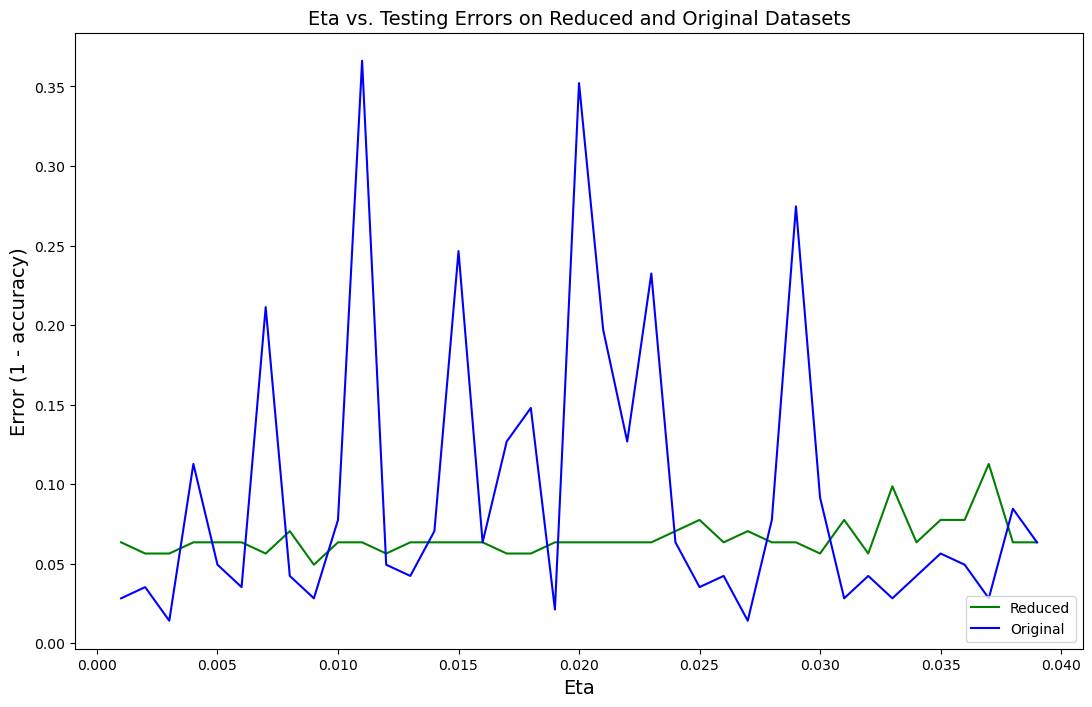

In [242]:
from sklearn.neural_network import MLPClassifier

etas = np.arange(.001, .04, .001)

test_error_1_r = []
test_error_1_o = []

for eta in etas:
    mlp = MLPClassifier(max_iter=1000, learning_rate_init=eta)
    mlp.fit(train_reduced.inputs, train_reduced.target.ravel())
    
    test_cm = my.confusion_matrix(test_reduced.target, mlp.predict(test_reduced.inputs))
    test_error_1_r.append(1-(np.trace(test_cm) / np.sum(test_cm)))
    
    mlp = MLPClassifier(max_iter=5000, learning_rate_init=eta)
    mlp.fit(train.inputs, train.target.ravel())
    
     
    test_cm = my.confusion_matrix(test.target, mlp.predict(test.inputs))
    test_error_1_o.append(1-(np.trace(test_cm) / np.sum(test_cm)))
    
fig = plt.figure(figsize=(13,8))
plt.style.use('default')
plt.plot(etas, test_error_1_r, 'g', label="Reduced")
plt.plot(etas, test_error_1_o, 'b', label="Original")
plt.title("Eta vs. Testing Errors on Reduced and Original Datasets", fontsize=14)
plt.xlabel("Eta", fontsize=14)
plt.ylabel("Error (1 - accuracy)", fontsize=14)
plt.legend(loc='lower right')

In [243]:
best_learning_rate_reduced = etas[np.argmin(np.array(test_error_1_r))]
best_learning_rate_original = etas[np.argmin(np.array(test_error_1_o))]

print("Learning rate corresponding to minimum test error - Reduced: ", round(best_learning_rate_reduced, 3))
print("Learning rate corresponding to minimum test error - Original: ", round(best_learning_rate_original, 3))

Learning rate corresponding to minimum test error - Reduced:  0.009
Learning rate corresponding to minimum test error - Original:  0.003


The other main hyperparameter we are concerned with is the number of hidden nodes. There is no rule that says what this value should be, so it requires testing different numbers and seeing which gives the best results. Let's use the best learning rates in the hyperparameter tuning for NHidden. We will test values from 10-100.

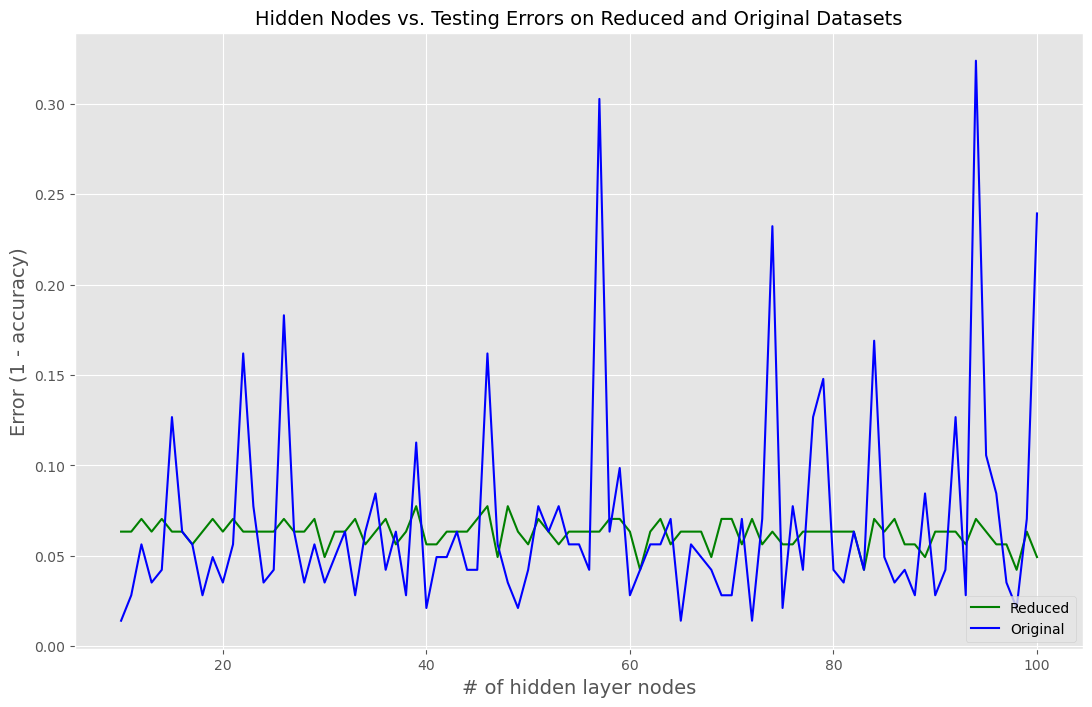

In [244]:
n = np.linspace(10, 100, 91)

test_error_2_r = []
test_error_2_o = []

for i in range(10, 101):
    mlp = MLPClassifier(max_iter=1000, learning_rate_init=best_learning_rate_reduced, hidden_layer_sizes=(i,))
    mlp.fit(train_reduced.inputs, train_reduced.target.ravel())
    
    train_cm = my.confusion_matrix(test_reduced.target, mlp.predict(test_reduced.inputs))
    test_error_2_r.append(1-(np.trace(train_cm) / np.sum(train_cm)))
    
    mlp = MLPClassifier(max_iter=5000, learning_rate_init=best_learning_rate_original, hidden_layer_sizes=(i,))
    mlp.fit(train.inputs, train.target.ravel())
    
    test_cm = my.confusion_matrix(test.target, mlp.predict(test.inputs))
    test_error_2_o.append(1-(np.trace(test_cm) / np.sum(test_cm)))
    
fig = plt.figure(figsize=(13,8))
plt.style.use('ggplot')
plt.plot(n, test_error_2_r, 'g', label="Reduced")
plt.plot(n, test_error_2_o, 'b', label="Original")
plt.title("Hidden Nodes vs. Testing Errors on Reduced and Original Datasets", fontsize=14)
plt.xlabel("# of hidden layer nodes", fontsize=14)
plt.ylabel("Error (1 - accuracy)", fontsize=14)
plt.legend(loc='lower right')

Notice how the errors jump all over the place. The NHidden can make a big difference in the performance of a MLP.

In [245]:
best_hidden_reduced = n[np.argmin(np.array(test_error_2_r))]
best_hidden_original = n[np.argmin(np.array(test_error_2_o))]

print("NHidden corresponding to minimum test error - Reduced: ", best_hidden_reduced)
print("NHidden corresponding to minimum test error - Original: ", best_hidden_original)

NHidden corresponding to minimum test error - Reduced:  61.0
NHidden corresponding to minimum test error - Original:  10.0


As we can see, the best number of hidden nodes for the reduced model is 61 and 10 for the original dataset-fitted model. We will take what we have tested and use it in our final models.

In [246]:
mlp_reduced = MLPClassifier(max_iter=1000, 
                    learning_rate_init=best_learning_rate_reduced, 
                    hidden_layer_sizes=(61,))

mlp_reduced.fit(train_reduced.inputs, train_reduced.target.ravel())

MLPClassifier(hidden_layer_sizes=(61,), learning_rate_init=0.009000000000000001,
              max_iter=1000)

Let's see how the MLP does:

In [247]:
cm = my.confusion_matrix(train_reduced.target, mlp_reduced.predict(train_reduced.inputs))
accuracy = np.trace(cm) / np.sum(cm)

print(cm)
print('Reduced data training accuracy: ', accuracy)

test_cm_reduced = my.confusion_matrix(test_reduced.target, mlp_reduced.predict(test_reduced.inputs))
accuracy = np.trace(test_cm_reduced) / np.sum(test_cm_reduced)

print(test_cm_reduced)
print('Reduced data test accuracy: ', accuracy)

[[132  29]
 [  6 260]]
Reduced data training accuracy:  0.9180327868852459
[[44  7]
 [ 1 90]]
Reduced data test accuracy:  0.9436619718309859


Not too bad! The training accuracy isn't great, but the test accuracy is better which is always good. We know we aren't overfitting.

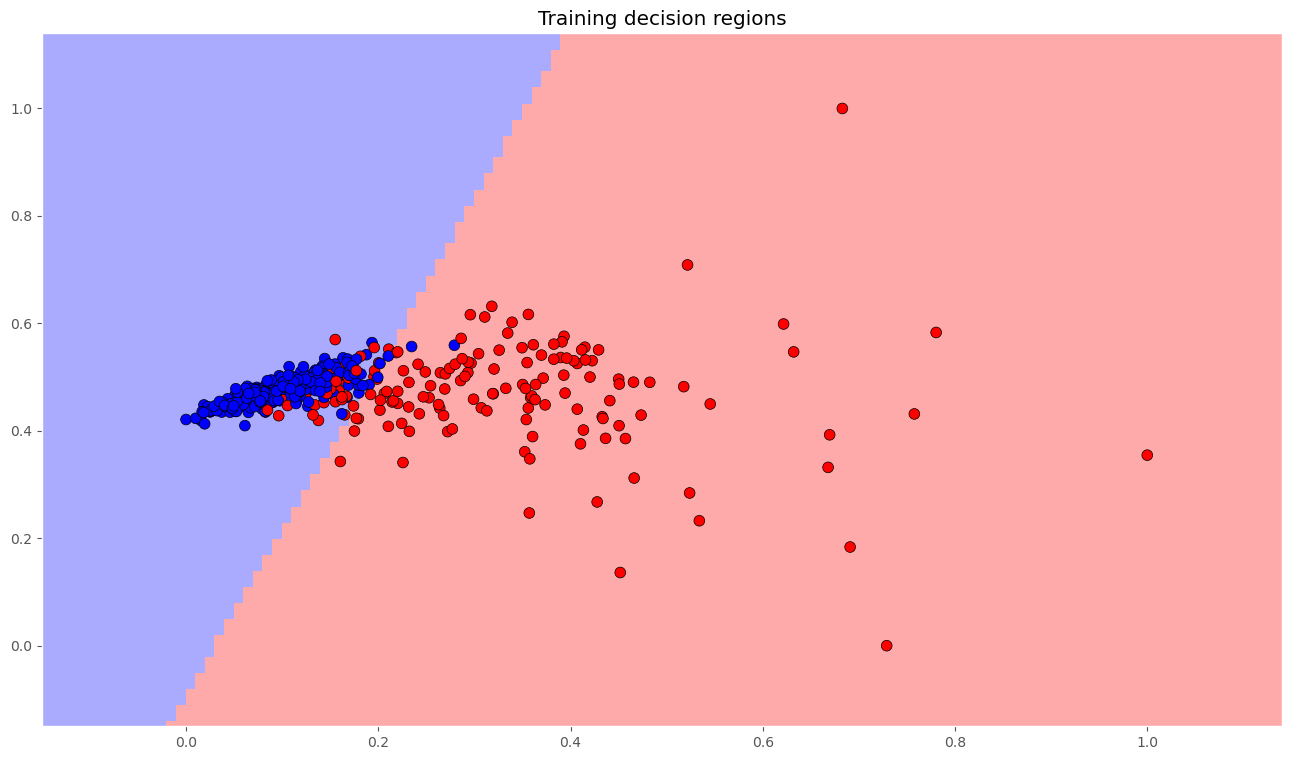

In [248]:
plot_decision_regions(train_reduced.inputs, train_reduced.target, mlp_reduced, resolution=0.01, title="Training decision regions")

Notice how the MLP still tries to separate the region with a straight line. And lastly we will use our tuned parameters for a model fit on the original dataset.

In [249]:
mlp_original = MLPClassifier(max_iter=5000, 
                    learning_rate_init=best_learning_rate_original, 
                    hidden_layer_sizes=(10,))

mlp_original.fit(train.inputs, train.target.ravel())

MLPClassifier(hidden_layer_sizes=(10,), learning_rate_init=0.003, max_iter=5000)

Test to see if we can beat the other model as we have been so far:

In [250]:
cm = my.confusion_matrix(train.target, mlp_original.predict(train.inputs))
accuracy = np.trace(cm) / np.sum(cm)

print(cm)
print('Original data training accuracy: ', accuracy)

test_cm = my.confusion_matrix(test.target, mlp_original.predict(test.inputs))
accuracy = np.trace(test_cm) / np.sum(test_cm)

print(test_cm)
print('Original data test accuracy: ', accuracy)

[[129  30]
 [  4 264]]
Original data training accuracy:  0.9203747072599532
[[51  2]
 [ 3 86]]
Original data test accuracy:  0.9647887323943662


These results surprisingly aren't much better than on the reduced. The MLP is a fascinatingly complex model with several different parameters. Unfortunately we didn't do the extensive hyperparameter tuning one might desire for an MLP, it simply takes too long and could be a project in of itself. So we will take what we can get and press on. Now the ROC plot:

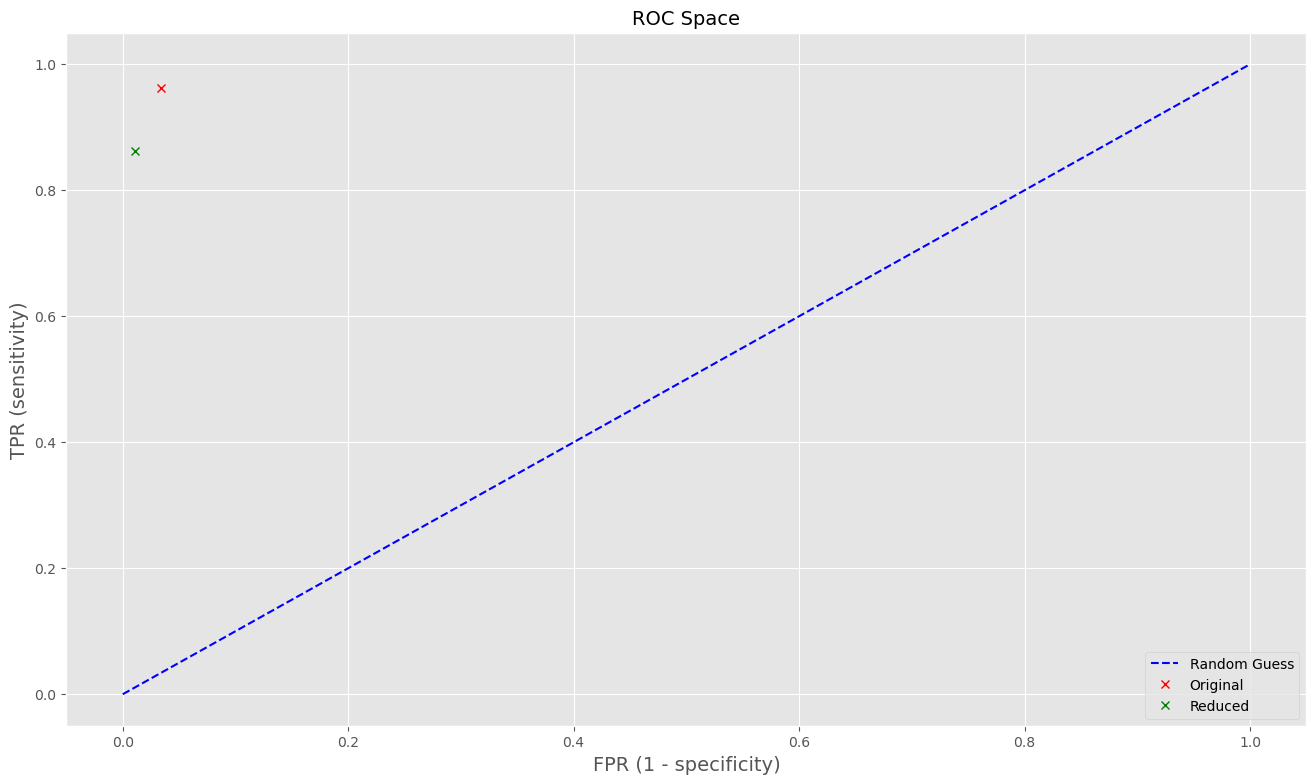

In [251]:
plot_ROC(test_cm, test_cm_reduced)

The two are in similar spots. Very interesting. Get the averages for our MLP classifiers:

In [252]:
mlp_avg_train_original, mlp_avg_train_reduced, mlp_avg_test_original, mlp_avg_test_reduced = compute_average_accuracies(mlp_original, mlp_reduced)

print("Average train accuracy on original dataset: ", mlp_avg_train_original)
print("Average train accuracy on reduced dataset: ", mlp_avg_train_reduced)
print("Average test accuracy on original dataset: ", mlp_avg_test_original)
print("Average test accuracy on reduced dataset: ", mlp_avg_test_reduced)

Average train accuracy on original dataset:  0.9250585480093678
Average train accuracy on reduced dataset:  0.922248243559719
Average test accuracy on original dataset:  0.9126760563380282
Average test accuracy on reduced dataset:  0.9112676056338028


And save the results again.

In [253]:
results[5,:] = [mlp_avg_train_original, mlp_avg_train_reduced, mlp_avg_test_original, mlp_avg_test_reduced]

## Support Vector Machine

The last classifier we will concern ourselves with is the very popular Support Vector Machine (SVM). It too is a linear classifier that seeks to find a separating hyperplane that has the largest margins between the support vectors and the plane itself. Support vectors are those examples that are on the "border" of classification and where the two different classes separate. The separators are represented by the equation $$\mathbf{w}^T \mathbf{x} + b = 0$$ where $\mathbf{w}$ are the weights.

To handle linearly inseparable data, we need to transform the data into a higher dimensional space in which the data becomes linearly separable. We, then, run maximum-margin classifier in that space. The SVM takes advantage of kernels and uses the 'kernel trick' to transform this data into a higher-dimensional representation. The four main kernels uses are:
* Radial Basis Function (RBF) 
* Linear 
* Polynomial 
* Sigmoid 

We will perform cross validation on the various parameters of each of these kernels and choose the kernel and parameter that give us the lowest error. Let's re-structure the cross validation function to work with the SVM and kernels.

In [254]:
from sklearn.svm import SVC

def tenFoldCrossValidationSVM(data, hparam, kernel):
    # Divide data into 10 equal sized folds (if not equal, will be close)
    split_data = np.array_split(data.examples, 10)
    
    err = 0
    for i in range(10):
        df_train = pd.concat([split_data[j] for j in range(10) if j != i], axis=0)
        df_validation = pd.concat([split_data[j] for j in range(10) if j == i], axis=0)
        
        train_set = my.DataSet(df_train, y=True)
        validation_set = my.DataSet(df_validation, y=True)
        
        learner = SVC()
        
        # Set the hyperparameter based on which kernel we are optimising
        if kernel == 'linear':
            learner.set_params(C=hparam, kernel='linear')
        elif kernel == 'rbf':
            learner.set_params(gamma=hparam, kernel='rbf')
        elif kernel == 'poly':
            learner.set_params(coef0=hparam, kernel='poly')
        else:
            learner.set_params(coef0=hparam, kernel='sigmoid')
            
        learner.fit(train_set.inputs, train_set.target.ravel())
        predicted = learner.predict(validation_set.inputs)
        
        err += errorMeasure(validation_set.target, predicted)
        
    return err / 10

### Choosing the Right Kernel

The first kernel we will test is the linear kernel. It has a hyperparameter C which is the regularization. Let's tune that and see what we get.

Text(0, 0.5, 'Error (1 - accuracy)')

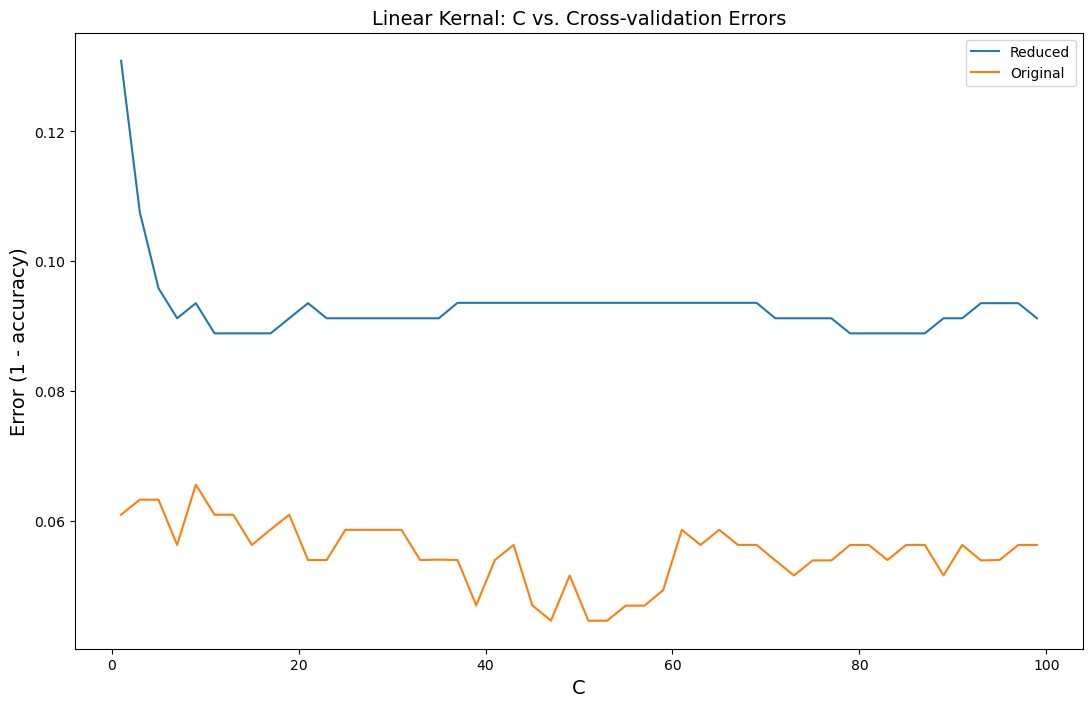

In [255]:
c_vals = np.arange(1, 101, 2)
y1 = np.array([tenFoldCrossValidationSVM(train_reduced, c, 'linear') for c in c_vals])
y2 = np.array([tenFoldCrossValidationSVM(train, c, 'linear') for c in c_vals])

fig = plt.figure(figsize=(13,8))
plt.style.use('default')
plt.plot(c_vals, y1, label='Reduced')
plt.plot(c_vals, y2, label='Original')
plt.title("Linear Kernal: C vs. Cross-validation Errors", fontsize=14)
plt.xlabel("C", fontsize=14)
plt.legend(loc='best')
plt.ylabel("Error (1 - accuracy)", fontsize=14)

In [256]:
best_linear_reduced = c_vals[np.argmin(y1)]
best_linear_original = c_vals[np.argmin(y2)]

print("Reduced: C corresponding to min error rate of " + str(round(min(y1), 3)) + " is: ", best_linear_reduced)
print("Original: C corresponding to min error rate of " + str(round(min(y2), 3)) + " is: ", best_linear_original)

Reduced: C corresponding to min error rate of 0.089 is:  13
Original: C corresponding to min error rate of 0.045 is:  47


Pretty good errors were obtained using a linear kernel. Let's try arguably the most popular/powerful kernel, the RBF, next and tune it's gamma parameter.

Text(0, 0.5, 'Error (1 - accuracy)')

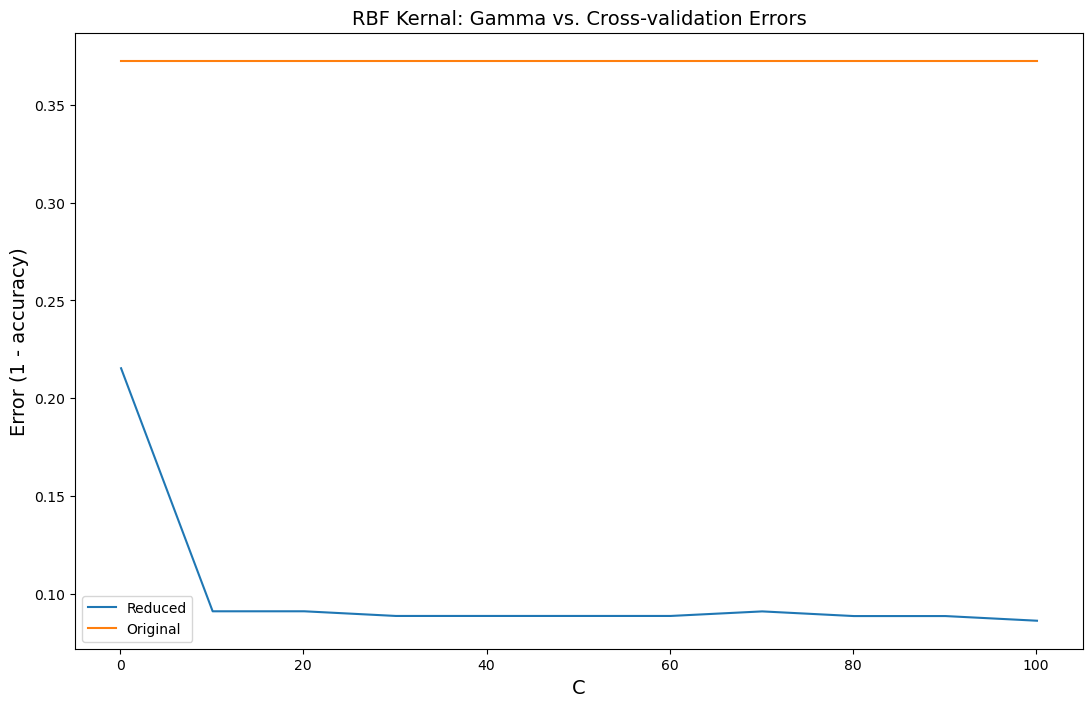

In [259]:
gammas = np.arange(.1, 101, 10)
y1 = np.array([tenFoldCrossValidationSVM(train_reduced, g, 'rbf') for g in gammas])
y2 = np.array([tenFoldCrossValidationSVM(train, g, 'rbf') for g in gammas])

fig = plt.figure(figsize=(13,8))
plt.plot(gammas, y1, label='Reduced')
plt.plot(gammas, y2, label='Original')
plt.title("RBF Kernal: Gamma vs. Cross-validation Errors", fontsize=14)
plt.legend(loc='best')
plt.xlabel("C", fontsize=14)
plt.ylabel("Error (1 - accuracy)", fontsize=14)

In [260]:
best_rbf_reduced = gammas[np.argmin(y1)]
best_rbf_original = gammas[np.argmin(y2)]

print("Reduced: Gamma corresponding to min error rate of " + str(round(min(y1), 3)) + " is: ", best_rbf_reduced)
print("Original: Gamma corresponding to min error rate of " + str(round(min(y2), 3)) + " is: ", best_rbf_original)

Reduced: Gamma corresponding to min error rate of 0.086 is:  100.1
Original: Gamma corresponding to min error rate of 0.372 is:  0.1


RBF did suprisingly poor on the original dataset. It is a very sensitive parameter and is very difficult to find an ideal value. Now to the next kernel, polynomial. We tune its parameter `coef0`, which is just a coefficient in the polynomial equation.

Text(0, 0.5, 'Error (1 - accuracy)')

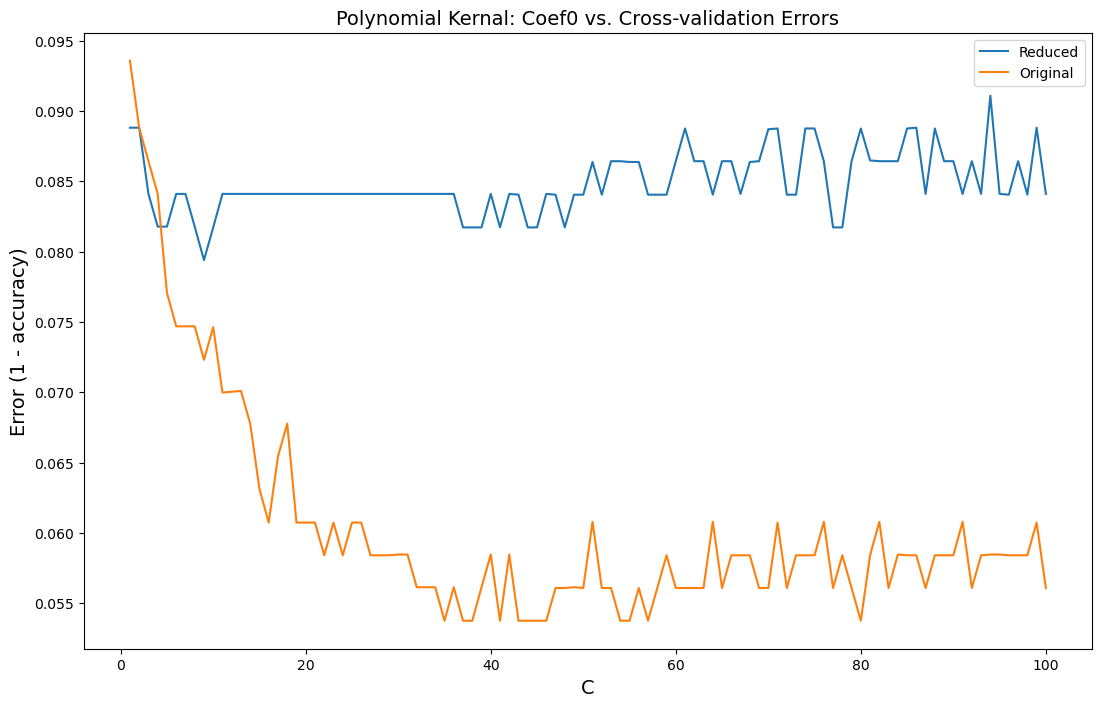

In [261]:
coefs = np.arange(1, 101)
y1 = np.array([tenFoldCrossValidationSVM(train_reduced, c, 'poly') for c in coefs])
y2 = np.array([tenFoldCrossValidationSVM(train, c, 'poly') for c in coefs])

fig = plt.figure(figsize=(13,8))
plt.plot(coefs, y1, label='Reduced')
plt.plot(coefs, y2, label='Original')
plt.title("Polynomial Kernal: Coef0 vs. Cross-validation Errors", fontsize=14)
plt.xlabel("C", fontsize=14)
plt.legend(loc='best')
plt.ylabel("Error (1 - accuracy)", fontsize=14)

In [262]:
best_poly_reduced = coefs[np.argmin(y1)]
best_poly_original = coefs[np.argmin(y2)]

print("Reduced: Gamma corresponding to min error rate of " + str(round(min(y1), 3)) + " is: ", best_poly_reduced)
print("Original: Gamma corresponding to min error rate of " + str(round(min(y2), 3)) + " is: ", best_poly_original)

Reduced: Gamma corresponding to min error rate of 0.079 is:  9
Original: Gamma corresponding to min error rate of 0.054 is:  35


Better results than the RBF and comparable to the linear kernel. Lastly we look at sigmoid with the same hyperparameter.

Text(0, 0.5, 'Error (1 - accuracy)')

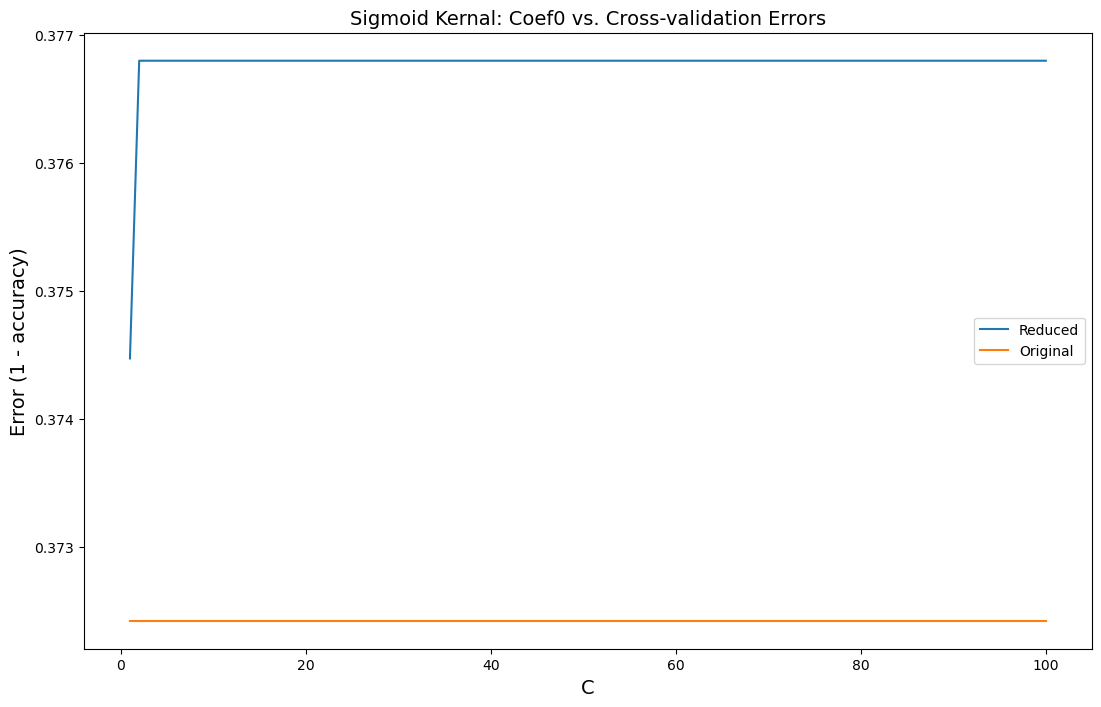

In [263]:
coefs = np.arange(1, 101)
y1 = np.array([tenFoldCrossValidationSVM(train_reduced, c, 'sigmoid') for c in coefs])
y2 = np.array([tenFoldCrossValidationSVM(train, c, 'sigmoid') for c in coefs])

fig = plt.figure(figsize=(13,8))
plt.plot(coefs, y1, label='Reduced')
plt.plot(coefs, y2, label='Original')
plt.title("Sigmoid Kernal: Coef0 vs. Cross-validation Errors", fontsize=14)
plt.xlabel("C", fontsize=14)
plt.legend(loc='best')
plt.ylabel("Error (1 - accuracy)", fontsize=14)

In [264]:
best_sig_reduced = c_vals[np.argmin(y1)]
best_sig_original = c_vals[np.argmin(y2)]

print("Reduced: Gamma corresponding to min error rate of " + str(round(min(y1), 3)) + " is: ", best_poly_reduced)
print("Original: Gamma corresponding to min error rate of " + str(round(min(y2), 3)) + " is: ", best_poly_original)

Reduced: Gamma corresponding to min error rate of 0.374 is:  9
Original: Gamma corresponding to min error rate of 0.372 is:  35


Strange results. Both sets had the exact same errors on each iteration. It looks like the linear kernel yielded the best results, so that is what we will go with. Let's fit an SVM on the reduced dataset with linear kernel and a C value of 13:

In [265]:
svm_reduced = SVC(kernel='linear', C=13)
svm_reduced.kernel
svm_reduced.fit(train_reduced.inputs, train_reduced.target.ravel())

SVC(C=13, kernel='linear')

Check the performance.

In [266]:
cm = my.confusion_matrix(train_reduced.target, svm_reduced.predict(train_reduced.inputs))
accuracy = np.trace(cm) / np.sum(cm)

print(cm)
print('Reduced data training accuracy: ', accuracy)

test_cm_reduced = my.confusion_matrix(test_reduced.target, svm_reduced.predict(test_reduced.inputs))
accuracy = np.trace(test_cm_reduced) / np.sum(test_cm_reduced)

print(test_cm_reduced)
print('Reduced data test accuracy: ', accuracy)

[[126  35]
 [  2 264]]
Reduced data training accuracy:  0.9133489461358314
[[44  7]
 [ 0 91]]
Reduced data test accuracy:  0.9507042253521126


These are consistent results. Let's plot the decision regions.

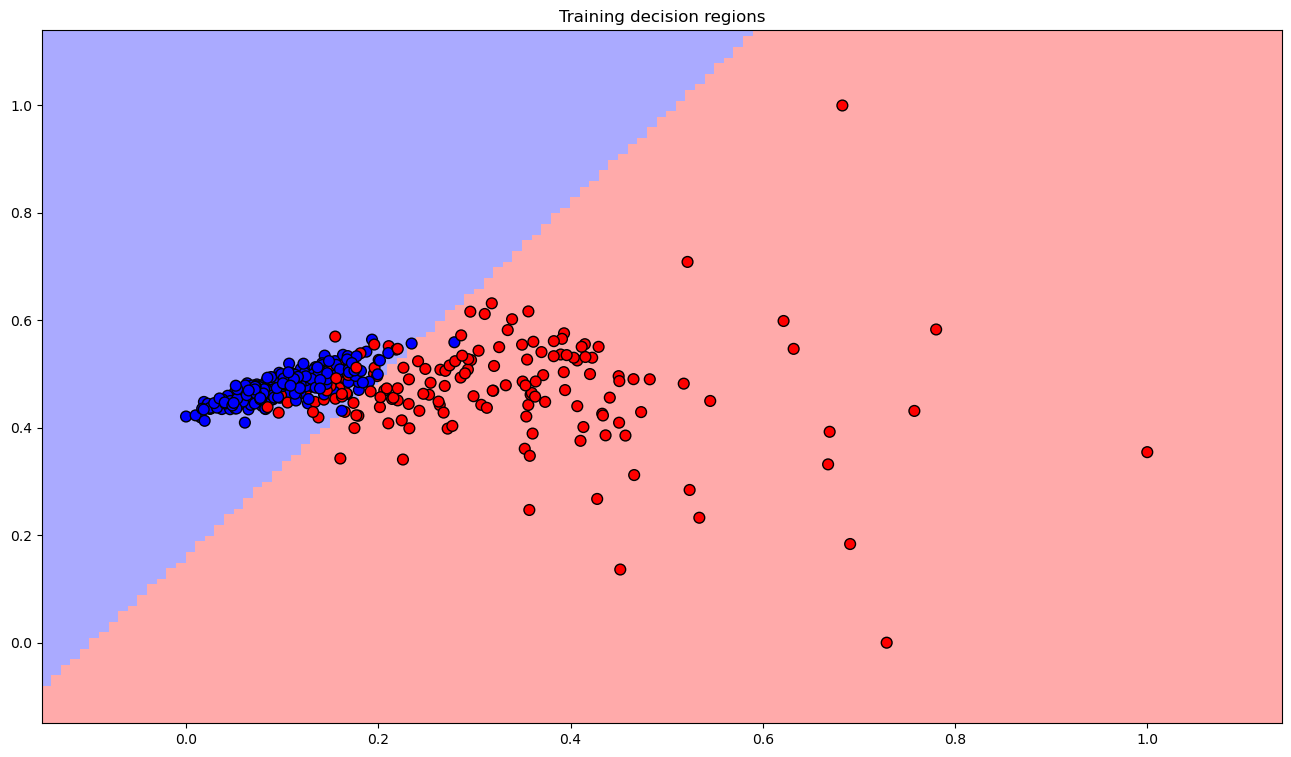

In [267]:
plot_decision_regions(train_reduced.inputs, train_reduced.target, svm_reduced, resolution=0.01, title="Training decision regions")

Notice again a line, as it is a linear classifier by nature, it will plot a line with a linear kernel. Different kernels would show a very different decision boundary. Here you can see the nature of the SVM, as the line appears to be the 'best' separator with the maximum margins. Lastly let's check the performance of a support vector machine on the original data, again with an optimized linear kernel.

In [268]:
svm_original = SVC(kernel='linear', C=47)
svm_original.kernel
svm_original.fit(train.inputs, train.target.ravel())

SVC(C=47, kernel='linear')

In [269]:
cm = my.confusion_matrix(train.target, svm_original.predict(train.inputs))
accuracy = np.trace(cm) / np.sum(cm)

print(cm)
print('Original data training accuracy: ', accuracy)

test_cm = my.confusion_matrix(test.target, svm_original.predict(test.inputs))
accuracy = np.trace(test_cm) / np.sum(test_cm)

print(test_cm)
print('Original data test accuracy: ', accuracy)

[[152   7]
 [ 10 258]]
Original data training accuracy:  0.9601873536299765
[[51  2]
 [ 0 89]]
Original data test accuracy:  0.9859154929577465


Very good results here with the SVM. In fact, they are the best yet and our test accuracy in this instance was almost 100%. They are extremely powerful learners, which is one reason why they have become so popular. Let's plot our last ROC plot before we conclude.

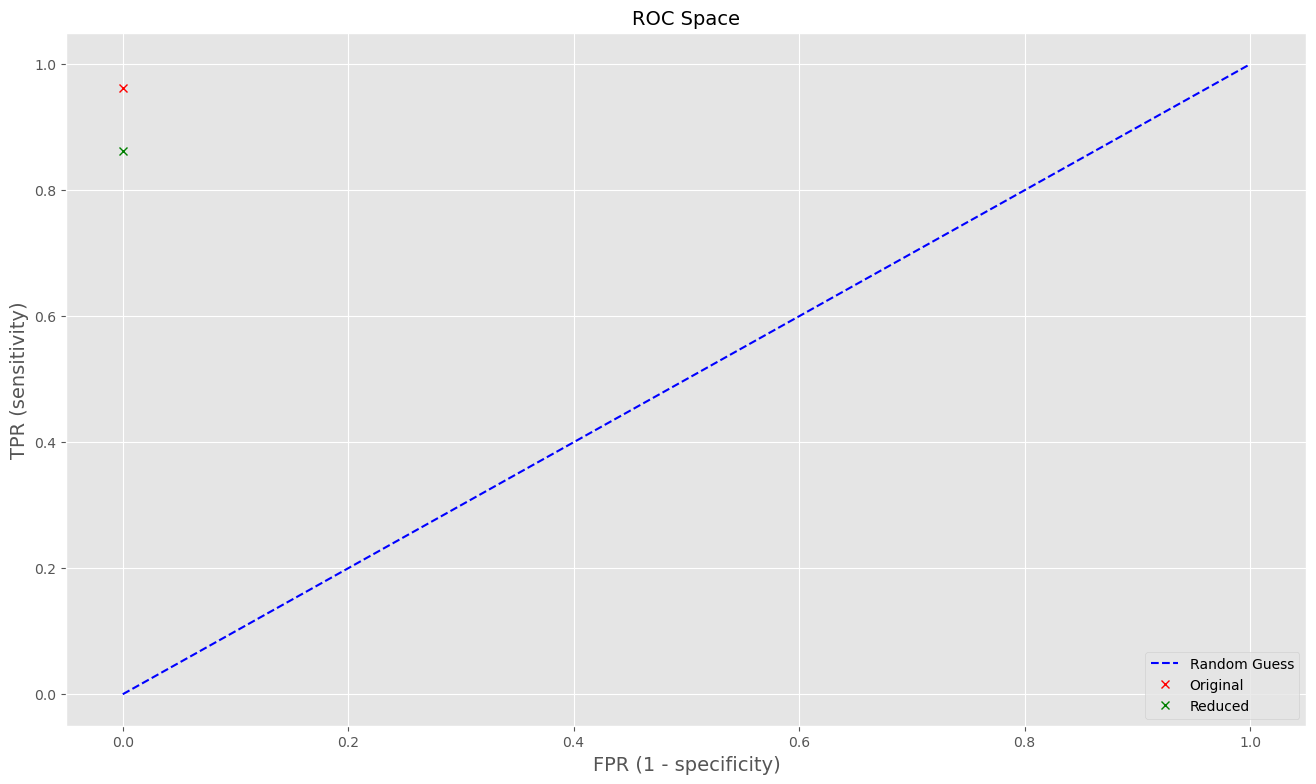

In [271]:
plot_ROC(test_cm, test_cm_reduced)

Compute the final set of averages.

In [272]:
svm_avg_train_original, svm_avg_train_reduced, svm_avg_test_original, svm_avg_test_reduced = compute_average_accuracies(svm_original, svm_reduced)

print("Average train accuracy on original dataset: ", svm_avg_train_original)
print("Average train accuracy on reduced dataset: ", svm_avg_train_reduced)
print("Average test accuracy on original dataset: ", svm_avg_test_original)
print("Average test accuracy on reduced dataset: ", svm_avg_test_reduced)

Average train accuracy on original dataset:  0.9695550351288056
Average train accuracy on reduced dataset:  0.9367681498829039
Average test accuracy on original dataset:  0.9577464788732394
Average test accuracy on reduced dataset:  0.8802816901408452


In [273]:
results[6,:] = [svm_avg_train_original, svm_avg_train_reduced, svm_avg_test_original, svm_avg_test_reduced]

# Conclusion

Let's wrap up by summarizing our results and discussing what we have learned. We will look at average performance across all of the supervised learners on the two datasets, and then discuss various pieces related to this project including challenges, remarks and final thoughts going forward.

## Results

Each classifier was ran 10 times on each dataset and the average train and test accuracies were computed. We present the conclusive results of the 7 classifiers in one table. The row indicates the classifier/model and the columns display the different average accuracies.

In [274]:

results_df = pd.DataFrame(data=results, 
                         index=['NN', 
                                'KNN', 
                                'GNB',
                                'LR',
                                'DT',
                                'MLP',
                                'SVM'],
                         columns=['Train Accuracy - Original',
                                  'Train Accuracy - Reduced',
                                  'Test Accuracy - Original',
                                  'Test Accuracy - Reduced'])

results_df

,Train Accuracy - Original,Train Accuracy - Reduced,Test Accuracy - Original,Test Accuracy - Reduced
NN,1.000000,1.000000,0.901408,0.901408
KNN,0.948478,0.941452,0.929577,0.915493
GNB,0.936768,0.894614,0.922535,0.922535
LR,0.985948,0.927400,0.929577,0.901408
DT,1.000000,1.000000,0.930986,0.887324
MLP,0.925059,0.922248,0.912676,0.911268
SVM,0.969555,0.936768,0.957746,0.880282


Here are the results in a double bar graph to better visualize the comparisons.

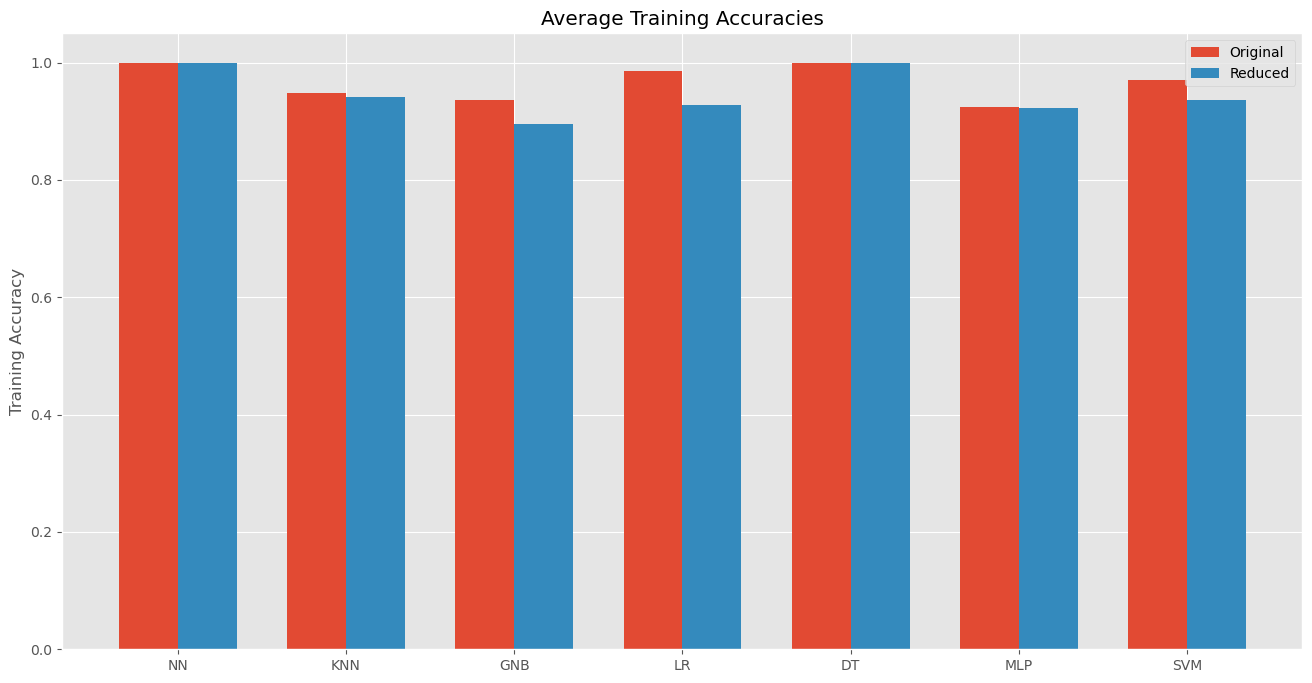

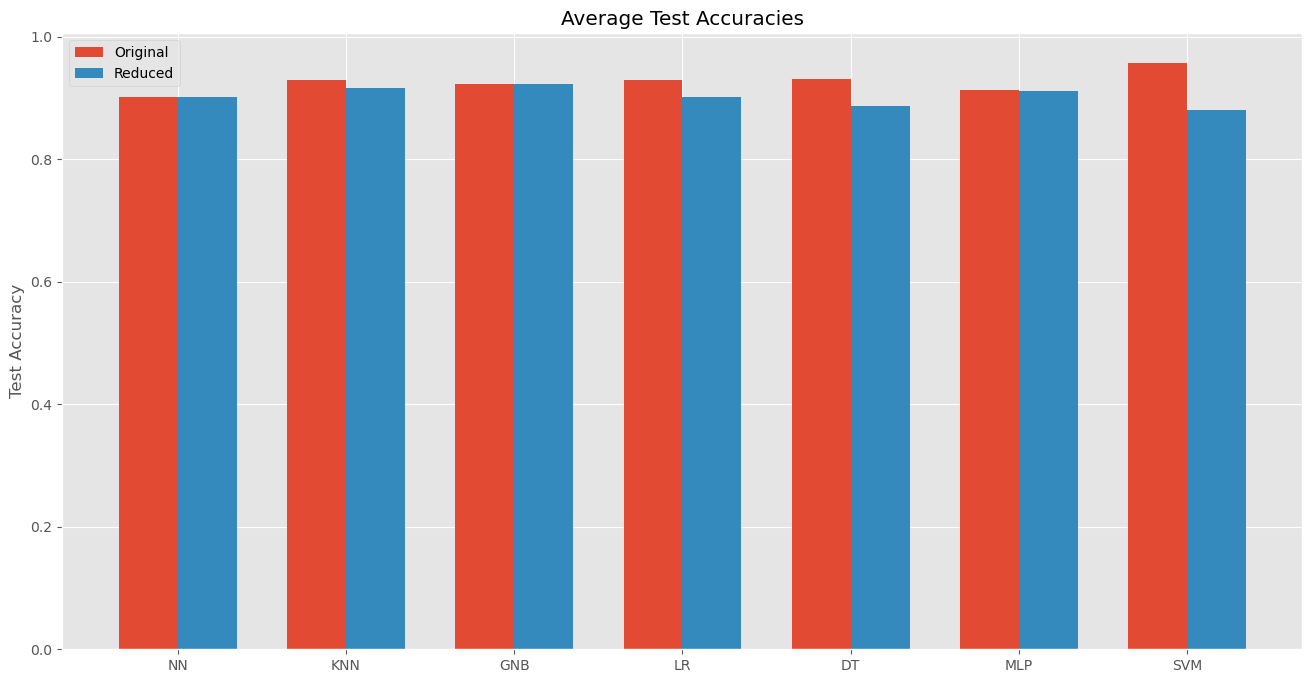

In [275]:
x = ['NN','KNN','GNB','LR','DT','MLP','SVM']

# Training accuracies
fig = plt.figure(figsize=(16,8))
plt.style.use('ggplot')
o_train = results_df['Train Accuracy - Original'].values
r_train = results_df['Train Accuracy - Reduced'].values

ind = np.arange(7) 
width = 0.35       
plt.bar(ind, o_train, width, label='Original')
plt.bar(ind + width, r_train, width,
    label='Reduced')

plt.ylabel('Training Accuracy')
plt.title('Average Training Accuracies')

plt.xticks(ind + width / 2, x)
plt.legend(loc='best')
plt.show()

# Test accuracies
fig = plt.figure(figsize=(16,8))
plt.style.use('ggplot')
o_test = results_df['Test Accuracy - Original'].values
r_test = results_df['Test Accuracy - Reduced'].values

ind = np.arange(7) 
width = 0.35       
plt.bar(ind, o_test, width, label='Original')
plt.bar(ind + width, r_test, width,
    label='Reduced')

plt.ylabel('Test Accuracy')
plt.title('Average Test Accuracies')

plt.xticks(ind + width / 2, x)
plt.legend(loc='best')
plt.show()

### How well can different models perform on a binary classification task with a small amount of data and a large number of features?

Our first question appears to have a positive answer. All of the models, on average, did quite well at diagnosing our patients correctly. All of the training accuracies were above 90%, with some as high as 100. Almost all of the test accuracies were above 90 percent as well, which is a good number. There were suprisingly not many outliers, and not many models that did poorly. The best classifier ended up being the Support Vector Machine, which yielded an average test accuracy of 95%! The worst model was the Nearest Neighbor classifier, sitting around 90%.

Given the nature of the problem, it is difficult to say how much we trust any of these algorithms. Obviously, when dealing with cancer, we would like to avoid ANY misclassifications at all costs, but that is simply inevitable, at least for now. If that is the case, then what do we care about more? False positives or false negatives? Obviously, false negatives are much worse here. We would never want a patient being diagnosed as not having cancer when in reality their tumor is actually malignant. Perhaps these algorithms can be used in conjunction with doctors to help guide them in the right direction rather than making the call on their own. Still, is it very interesting to put years of machine learning theory and algorithms to the test especially on a problem such as this.

### How will the models compare when fitted on a drastically dimension-reduced dataset?

Our other question was explored throughout the entire project and now we can see the results in one neat graph. I personally find it astonishing that a dataset that originally had 30 dimensions could be reduced to just TWO and still give the results it did on each of these classifiers. That is a true testament to the power of these algorithms. The classifiers fitted on our projected dataset, as you can see, performed very closely to the original ones. In fact, in the NN on training and testing, and MLP on training, it actually did exactly as good!  All the other models did perform worse, though just slightly.

What is the tradeoff here and what is the benefit? Well the tradeoff is certainly lower accuracy and performance for higher speed and ease of use.It may be difficult in times to gather all of the features needed for an example, so knowing that we can use such a smaller number of them is very handy. Is this tradeoff worth it, however? With something as serious as diagnosing cancer, we certainly want as high of an accuracy as we can get. So maybe we don't want the tradeoff in the sense of using them for pure classification. We might want to use the dimensionality reduction instead to narrow down those features that are most important. This could help doctors identify certain aspects of a cell that may be more indicative of cancer than others. In either case, both datasets and models have their own usefulness to them.

## Challenges

Most of the challenges with this project came at the beginning, especially with finding the right dataset. My original idea was to do a diagnosis exploration but for Alzheimer's instead of breast cancer. That required getting approval from a university to use their datasets in a rather extensive process that unfortunately didn't work out. I then had another dataset in mind that involved chess endgames, but the features were very odd and it would have been difficult to use. I then settled on my third choice, but it ended up being very interesting and fun to work with. 

I had a pretty clear idea in mind on how I wanted to go about the project and have it flow together, so that part of it went smoothly. The hardest part about it were the syntax errors and dealing with the differences in scikit-learn versus how we did things in class. I had a lot of small issues in how I was passing data, getting values, etc., especially in the fit and predict methods of many of the models.

## Lessons learned

I touched on some lessons taken away from this just above in answering our primary questions. As I was doing this project, I discovered some of the uses this particular type of problem can have when machine learning comes into play. Aside from simply just classifying examples, we can build a more general diagnostic system that can help us in other aspects of cancer, like discovering key features of cells; which ones are more useful in a diagnosis, which ones aren't, etc. I also learned some important ideas about what the scope of a machine learning project may entail. As our dataset only had just shy of 600 examples, given the results that the classifiers gave us it certainly isn't about having a bunch of data. This is extremely useful to understand since data can be hard to obtain and is often the bottleneck of many problems. With the right knowledge of the algorithms, you can get much better results than you might anticipate.

On the practical side, I also learned some helpful tricks with scikit-learns extensive library. Their API makes it super easy to use many of the algorithms. Seeing an API also helps clarify how some of these ML model can easily be used in actualy application, like a website or some sort of system.

## Going Forward

Combining many of the things we have learned into one real-life application really helped solidify a lot of the knowledge I have about these algorithms. It also makes me excited for the future. Machine learning is something that I am certainly interested in and would love to work with it more in the future, even in industry if possible. As far as future work on this assignment, it was a fairly brief analysis of each of the algorithms. It may be wise to go through and really perform some industry-level evaluation including more extensive hyperparameter tuning.